In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.test.is_gpu_available())
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

2025-04-09 11:33:45.725414: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True


2025-04-09 11:33:48.435641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-09 11:33:48.491166: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-09 11:33:48.491577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# import tensorflow as tf
# print(tf.keras.__version__)

import keras
print(keras.__version__)

In [2]:
df=pd.read_csv('annotations.csv')
df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,a64e73e6f2554ba29a89ad18af46d18e.jpg,384,384,disgust,52,47,344,384
1,6604c860818446e2927df379962de3db.jpg,384,384,surprised,84,103,281,372
2,c2de889f09204127b4f085cf1e80ab3c.jpg,384,384,disgust,52,88,296,367
3,612fd661b47b43a08fa7c9858c06ada3.jpg,384,384,neutral,54,58,296,370
4,43a883c8460d4094b5720bc2e0dfec75.jpg,384,384,sad,80,79,384,384
...,...,...,...,...,...,...,...,...
15619,aug_a041a7909f1648ecb9e38ac852558ec2.jpg,384,384,happy,44,22,306,372
15620,aug_dad808cc401a49d7b2d57e9645f10af9.jpg,384,384,happy,75,34,304,354
15621,aug_4b236c9291b6441ba372aaee06b4a476.jpg,384,384,happy,59,7,319,375
15622,aug_e517014b8c1d448ba5605aab5de47e13.jpg,384,384,happy,40,3,319,347


In [3]:
null_rows=df.isnull().any(axis=1).sum()
print('Number of null rows: ', null_rows)

Number of null rows:  0


In [ ]:
df= df.dropna(subset=['labels'])
print(df)

In [ ]:
df = df.reset_index(drop=True)
df.shape

In [4]:
print(df.head())
print(df['class'].value_counts())

                               filename  width  height      class  xmin  ymin  \
0  a64e73e6f2554ba29a89ad18af46d18e.jpg    384     384    disgust    52    47   
1  6604c860818446e2927df379962de3db.jpg    384     384  surprised    84   103   
2  c2de889f09204127b4f085cf1e80ab3c.jpg    384     384    disgust    52    88   
3  612fd661b47b43a08fa7c9858c06ada3.jpg    384     384    neutral    54    58   
4  43a883c8460d4094b5720bc2e0dfec75.jpg    384     384        sad    80    79   

   xmax  ymax  
0   344   384  
1   281   372  
2   296   367  
3   296   370  
4   384   384  
class
disgust      2232
surprised    2232
neutral      2232
sad          2232
fear         2232
angry        2232
happy        2232
Name: count, dtype: int64


In [5]:
image_data = []
bbox_data = []
label_data = []

image_dir = 'images'

label_map = ['surprised', 'happy', 'angry', 'disgust', 'fear', 'sad', 'neutral']

for df_index in range(len(df)):
    img_path=os.path.join(image_dir, df['filename'][df_index])
    img=cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    image_data.append(img)
    
    bbox=[
        (df['xmin'][df_index])/224,
        (df['ymin'][df_index])/224,
        (df['xmax'][df_index])/224,
        (df['ymax'][df_index])/224
    ]
    bbox_data.append(bbox)

    label_data.append(label_map.index(df['class'][df_index]))

x=np.array(image_data)
y_bbox=np.array(bbox_data)
y_class=np.array(label_data)

In [6]:
y_class = to_categorical(y_class, num_classes=len(label_map))

In [7]:
print(x.shape)
print(y_class.shape)
print(y_bbox.shape)

(15624, 224, 224, 3)
(15624, 7)
(15624, 4)


In [8]:
x_train, x_test, y_train_bbox, y_test_bbox, y_train_class, y_test_class = train_test_split(x, y_bbox, 
                                                                                           y_class,
                                                                                           test_size=0.15,
                                                                                           random_state=42)

In [9]:
x_train, x_val, y_train_bbox, y_val_bbox, y_train_class, y_val_class = train_test_split(x_train, 
                                                                                        y_train_bbox, 
                                                                                        y_train_class,
                                                                                        test_size=0.22, 
                                                                                        random_state=42)

In [10]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train_bbox.shape, y_val_bbox.shape, y_test_bbox.shape) #bbox
print(y_train_class.shape, y_val_class.shape, y_test_class.shape) #class

(10358, 224, 224, 3) (2922, 224, 224, 3) (2344, 224, 224, 3)
(10358, 4) (2922, 4) (2344, 4)
(10358, 7) (2922, 7) (2344, 7)


In [11]:
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras import regularizers


input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze first N layers
for layer in base_model.layers[:50]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)

# Output branches
bbox_output = Dense(4, activation='sigmoid', name='bbox_output', kernel_regularizer=regularizers.l2(1e-4))(x)
class_output = Dense(len(label_map), activation='softmax', name='class_output', kernel_regularizer=regularizers.l2(1e-4))(x)

model = Model(inputs=input_tensor, outputs=[bbox_output, class_output])

2025-04-09 11:35:07.805217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-09 11:35:07.805673: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-09 11:35:07.805909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            


 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             


 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           


 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          


 pool1_pool (MaxPooling2D)   (None, 56, 56, 64)           0         ['pool1_pad[0][0]']           


 conv2_block1_preact_bn (Ba  (None, 56, 56, 64)           256       ['pool1_pool[0][0]']          


 tchNormalization)                                                                                


 conv2_block1_preact_relu (  (None, 56, 56, 64)           0         ['conv2_block1_preact_bn[0][0]


 Activation)                                                        ']                            


 conv2_block1_1_conv (Conv2  (None, 56, 56, 64)           4096      ['conv2_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv2_block1_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_2_pad (ZeroPa  (None, 58, 58, 64)           0         ['conv2_block1_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv2_block1_2_conv (Conv2  (None, 56, 56, 64)           36864     ['conv2_block1_2_pad[0][0]']  


 D)                                                                                               


 conv2_block1_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block1_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block1_0_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv2_block1_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block1_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_0_conv[0][0]', 


                                                                     'conv2_block1_3_conv[0][0]'] 


 conv2_block2_preact_bn (Ba  (None, 56, 56, 256)          1024      ['conv2_block1_out[0][0]']    


 tchNormalization)                                                                                


 conv2_block2_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block2_preact_bn[0][0]


 Activation)                                                        ']                            


 conv2_block2_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block2_preact_relu[0][


 D)                                                                 0]']                          


 conv2_block2_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_2_pad (ZeroPa  (None, 58, 58, 64)           0         ['conv2_block2_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv2_block2_2_conv (Conv2  (None, 56, 56, 64)           36864     ['conv2_block2_2_pad[0][0]']  


 D)                                                                                               


 conv2_block2_2_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block2_2_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv2_block2_3_conv (Conv2  (None, 56, 56, 256)          16640     ['conv2_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block2_out (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    


                                                                     'conv2_block2_3_conv[0][0]'] 


 conv2_block3_preact_bn (Ba  (None, 56, 56, 256)          1024      ['conv2_block2_out[0][0]']    


 tchNormalization)                                                                                


 conv2_block3_preact_relu (  (None, 56, 56, 256)          0         ['conv2_block3_preact_bn[0][0]


 Activation)                                                        ']                            


 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16384     ['conv2_block3_preact_relu[0][


 D)                                                                 0]']                          


 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv2_block3_2_pad (ZeroPa  (None, 58, 58, 64)           0         ['conv2_block3_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv2_block3_2_conv (Conv2  (None, 28, 28, 64)           36864     ['conv2_block3_2_pad[0][0]']  


 D)                                                                                               


 conv2_block3_2_bn (BatchNo  (None, 28, 28, 64)           256       ['conv2_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv2_block3_2_relu (Activ  (None, 28, 28, 64)           0         ['conv2_block3_2_bn[0][0]']   


 ation)                                                                                           


 max_pooling2d (MaxPooling2  (None, 28, 28, 256)          0         ['conv2_block2_out[0][0]']    


 D)                                                                                               


 conv2_block3_3_conv (Conv2  (None, 28, 28, 256)          16640     ['conv2_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv2_block3_out (Add)      (None, 28, 28, 256)          0         ['max_pooling2d[0][0]',       


                                                                     'conv2_block3_3_conv[0][0]'] 


 conv3_block1_preact_bn (Ba  (None, 28, 28, 256)          1024      ['conv2_block3_out[0][0]']    


 tchNormalization)                                                                                


 conv3_block1_preact_relu (  (None, 28, 28, 256)          0         ['conv3_block1_preact_bn[0][0]


 Activation)                                                        ']                            


 conv3_block1_1_conv (Conv2  (None, 28, 28, 128)          32768     ['conv3_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv3_block1_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block1_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv3_block1_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block1_2_pad[0][0]']  


 D)                                                                                               


 conv3_block1_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block1_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block1_0_conv (Conv2  (None, 28, 28, 512)          131584    ['conv3_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv3_block1_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block1_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_0_conv[0][0]', 


                                                                     'conv3_block1_3_conv[0][0]'] 


 conv3_block2_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block1_out[0][0]']    


 tchNormalization)                                                                                


 conv3_block2_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block2_preact_bn[0][0]


 Activation)                                                        ']                            


 conv3_block2_1_conv (Conv2  (None, 28, 28, 128)          65536     ['conv3_block2_preact_relu[0][


 D)                                                                 0]']                          


 conv3_block2_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block2_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv3_block2_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block2_2_pad[0][0]']  


 D)                                                                                               


 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block2_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block2_out (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    


                                                                     'conv3_block2_3_conv[0][0]'] 


 conv3_block3_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block2_out[0][0]']    


 tchNormalization)                                                                                


 conv3_block3_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block3_preact_bn[0][0]


 Activation)                                                        ']                            


 conv3_block3_1_conv (Conv2  (None, 28, 28, 128)          65536     ['conv3_block3_preact_relu[0][


 D)                                                                 0]']                          


 conv3_block3_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block3_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv3_block3_2_conv (Conv2  (None, 28, 28, 128)          147456    ['conv3_block3_2_pad[0][0]']  


 D)                                                                                               


 conv3_block3_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block3_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv3_block3_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block3_out (Add)      (None, 28, 28, 512)          0         ['conv3_block2_out[0][0]',    


                                                                     'conv3_block3_3_conv[0][0]'] 


 conv3_block4_preact_bn (Ba  (None, 28, 28, 512)          2048      ['conv3_block3_out[0][0]']    


 tchNormalization)                                                                                


 conv3_block4_preact_relu (  (None, 28, 28, 512)          0         ['conv3_block4_preact_bn[0][0]


 Activation)                                                        ']                            


 conv3_block4_1_conv (Conv2  (None, 28, 28, 128)          65536     ['conv3_block4_preact_relu[0][


 D)                                                                 0]']                          


 conv3_block4_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv3_block4_2_pad (ZeroPa  (None, 30, 30, 128)          0         ['conv3_block4_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv3_block4_2_conv (Conv2  (None, 14, 14, 128)          147456    ['conv3_block4_2_pad[0][0]']  


 D)                                                                                               


 conv3_block4_2_bn (BatchNo  (None, 14, 14, 128)          512       ['conv3_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv3_block4_2_relu (Activ  (None, 14, 14, 128)          0         ['conv3_block4_2_bn[0][0]']   


 ation)                                                                                           


 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 512)          0         ['conv3_block3_out[0][0]']    


 g2D)                                                                                             


 conv3_block4_3_conv (Conv2  (None, 14, 14, 512)          66048     ['conv3_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv3_block4_out (Add)      (None, 14, 14, 512)          0         ['max_pooling2d_1[0][0]',     


                                                                     'conv3_block4_3_conv[0][0]'] 


 conv4_block1_preact_bn (Ba  (None, 14, 14, 512)          2048      ['conv3_block4_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block1_preact_relu (  (None, 14, 14, 512)          0         ['conv4_block1_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block1_1_conv (Conv2  (None, 14, 14, 256)          131072    ['conv4_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block1_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block1_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block1_2_pad[0][0]']  


 D)                                                                                               


 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv4_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block1_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block1_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_0_conv[0][0]', 


                                                                     'conv4_block1_3_conv[0][0]'] 


 conv4_block2_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block1_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block2_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block2_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block2_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block2_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block2_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block2_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block2_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block2_2_pad[0][0]']  


 D)                                                                                               


 conv4_block2_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block2_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block2_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block2_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block1_out[0][0]',    


                                                                     'conv4_block2_3_conv[0][0]'] 


 conv4_block3_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block2_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block3_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block3_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block3_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block3_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block3_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block3_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block3_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block3_2_pad[0][0]']  


 D)                                                                                               


 conv4_block3_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block3_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block3_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block3_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block2_out[0][0]',    


                                                                     'conv4_block3_3_conv[0][0]'] 


 conv4_block4_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block3_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block4_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block4_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block4_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block4_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block4_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block4_2_pad[0][0]']  


 D)                                                                                               


 conv4_block4_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block4_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block4_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block4_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block4_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block4_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block3_out[0][0]',    


                                                                     'conv4_block4_3_conv[0][0]'] 


 conv4_block5_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block4_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block5_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block5_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block5_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block5_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block5_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block5_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block5_2_conv (Conv2  (None, 14, 14, 256)          589824    ['conv4_block5_2_pad[0][0]']  


 D)                                                                                               


 conv4_block5_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block5_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block5_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block5_2_bn[0][0]']   


 ation)                                                                                           


 conv4_block5_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block5_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block5_out (Add)      (None, 14, 14, 1024)         0         ['conv4_block4_out[0][0]',    


                                                                     'conv4_block5_3_conv[0][0]'] 


 conv4_block6_preact_bn (Ba  (None, 14, 14, 1024)         4096      ['conv4_block5_out[0][0]']    


 tchNormalization)                                                                                


 conv4_block6_preact_relu (  (None, 14, 14, 1024)         0         ['conv4_block6_preact_bn[0][0]


 Activation)                                                        ']                            


 conv4_block6_1_conv (Conv2  (None, 14, 14, 256)          262144    ['conv4_block6_preact_relu[0][


 D)                                                                 0]']                          


 conv4_block6_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block6_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_1_bn[0][0]']   


 ation)                                                                                           


 conv4_block6_2_pad (ZeroPa  (None, 16, 16, 256)          0         ['conv4_block6_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv4_block6_2_conv (Conv2  (None, 7, 7, 256)            589824    ['conv4_block6_2_pad[0][0]']  


 D)                                                                                               


 conv4_block6_2_bn (BatchNo  (None, 7, 7, 256)            1024      ['conv4_block6_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv4_block6_2_relu (Activ  (None, 7, 7, 256)            0         ['conv4_block6_2_bn[0][0]']   


 ation)                                                                                           


 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 1024)           0         ['conv4_block5_out[0][0]']    


 g2D)                                                                                             


 conv4_block6_3_conv (Conv2  (None, 7, 7, 1024)           263168    ['conv4_block6_2_relu[0][0]'] 


 D)                                                                                               


 conv4_block6_out (Add)      (None, 7, 7, 1024)           0         ['max_pooling2d_2[0][0]',     


                                                                     'conv4_block6_3_conv[0][0]'] 


 conv5_block1_preact_bn (Ba  (None, 7, 7, 1024)           4096      ['conv4_block6_out[0][0]']    


 tchNormalization)                                                                                


 conv5_block1_preact_relu (  (None, 7, 7, 1024)           0         ['conv5_block1_preact_bn[0][0]


 Activation)                                                        ']                            


 conv5_block1_1_conv (Conv2  (None, 7, 7, 512)            524288    ['conv5_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv5_block1_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block1_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv5_block1_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block1_2_pad[0][0]']  


 D)                                                                                               


 conv5_block1_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block1_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block1_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block1_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block1_0_conv (Conv2  (None, 7, 7, 2048)           2099200   ['conv5_block1_preact_relu[0][


 D)                                                                 0]']                          


 conv5_block1_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block1_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block1_out (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_0_conv[0][0]', 


                                                                     'conv5_block1_3_conv[0][0]'] 


 conv5_block2_preact_bn (Ba  (None, 7, 7, 2048)           8192      ['conv5_block1_out[0][0]']    


 tchNormalization)                                                                                


 conv5_block2_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block2_preact_bn[0][0]


 Activation)                                                        ']                            


 conv5_block2_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block2_preact_relu[0][


 D)                                                                 0]']                          


 conv5_block2_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block2_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv5_block2_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block2_2_pad[0][0]']  


 D)                                                                                               


 conv5_block2_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block2_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block2_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block2_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block2_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block2_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block2_out (Add)      (None, 7, 7, 2048)           0         ['conv5_block1_out[0][0]',    


                                                                     'conv5_block2_3_conv[0][0]'] 


 conv5_block3_preact_bn (Ba  (None, 7, 7, 2048)           8192      ['conv5_block2_out[0][0]']    


 tchNormalization)                                                                                


 conv5_block3_preact_relu (  (None, 7, 7, 2048)           0         ['conv5_block3_preact_bn[0][0]


 Activation)                                                        ']                            


 conv5_block3_1_conv (Conv2  (None, 7, 7, 512)            1048576   ['conv5_block3_preact_relu[0][


 D)                                                                 0]']                          


 conv5_block3_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_1_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_2_pad (ZeroPa  (None, 9, 9, 512)            0         ['conv5_block3_1_relu[0][0]'] 


 dding2D)                                                                                         


 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359296   ['conv5_block3_2_pad[0][0]']  


 D)                                                                                               


 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 


 rmalization)                                                                                     


 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   


 ation)                                                                                           


 conv5_block3_3_conv (Conv2  (None, 7, 7, 2048)           1050624   ['conv5_block3_2_relu[0][0]'] 


 D)                                                                                               


 conv5_block3_out (Add)      (None, 7, 7, 2048)           0         ['conv5_block2_out[0][0]',    


                                                                     'conv5_block3_3_conv[0][0]'] 


 post_bn (BatchNormalizatio  (None, 7, 7, 2048)           8192      ['conv5_block3_out[0][0]']    


 n)                                                                                               


 post_relu (Activation)      (None, 7, 7, 2048)           0         ['post_bn[0][0]']             


 global_average_pooling2d (  (None, 2048)                 0         ['post_relu[0][0]']           


 GlobalAveragePooling2D)                                                                          


 dropout (Dropout)           (None, 2048)                 0         ['global_average_pooling2d[0][


                                                                    0]']                          


 dense (Dense)               (None, 256)                  524544    ['dropout[0][0]']             


 dropout_1 (Dropout)         (None, 256)                  0         ['dense[0][0]']               


 bbox_output (Dense)         (None, 4)                    1028      ['dropout_1[0][0]']           


 class_output (Dense)        (None, 7)                    1799      ['dropout_1[0][0]']           


Total params: 24092171 (91.90 MB)


Trainable params: 23508491 (89.68 MB)


Non-trainable params: 583680 (2.23 MB)


__________________________________________________________________________________________________


In [13]:
LR=0.00001

model.compile(
    optimizer=Adam(learning_rate=LR),
    loss={
        'bbox_output': 'mse',
        'class_output': 'categorical_crossentropy'
    },
    loss_weights={
        'bbox_output': 1.0,
        'class_output': 1.0
    },
    metrics={
        'bbox_output': ['mse'],
        'class_output': ['accuracy', Precision(name='precision'), Recall(name='recall')]
    }
)

In [14]:
checkpointer = [
#     EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True, mode="min", patience=60),
    ModelCheckpoint('best_model3_loss.keras', monitor="val_loss", verbose=1, save_best_only=True, mode="min"),
    ModelCheckpoint('best_model3_loss.h5', monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    
#     ModelCheckpoint('best_model3_acc.keras', monitor="val_class_output_accuracy", verbose=1, save_best_only=True, mode="max")
    
]

In [15]:
BS=16
EP=250

# Train the model
history = model.fit(
    x_train, {'bbox_output': y_train_bbox, 'class_output': y_train_class},
    validation_data=(x_val, {'bbox_output': y_val_bbox, 'class_output': y_val_class}),
    batch_size=BS,
    epochs=EP,
    verbose=1,
    callbacks=checkpointer
)

2025-04-09 11:35:37.659439: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6236676096 exceeds 10% of free system memory.
2025-04-09 11:35:44.574167: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6236676096 exceeds 10% of free system memory.


Epoch 1/250


2025-04-09 11:36:17.733173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90400


I0000 00:00:1744198579.493989    5080 service.cc:145] XLA service 0x76ce698423d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744198579.494032    5080 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-04-09 11:36:19.501189: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744198579.572292    5078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



  1/648 [..............................] - ETA: 6:44:30 - loss: 3.7759 - bbox_output_loss: 0.8560 - class_output_loss: 2.8724 - bbox_output_mse: 0.8560 - class_output_accuracy: 0.0625 - class_output_precision: 0.0000e+00 - class_output_recall: 0.0000e+00


  2/648 [..............................] - ETA: 4:03 - loss: 3.4832 - bbox_output_loss: 0.8124 - class_output_loss: 2.6233 - bbox_output_mse: 0.8124 - class_output_accuracy: 0.0625 - class_output_precision: 0.1111 - class_output_recall: 0.0312           


  3/648 [..............................] - ETA: 2:31 - loss: 3.3148 - bbox_output_loss: 0.8112 - class_output_loss: 2.4561 - bbox_output_mse: 0.8112 - class_output_accuracy: 0.1250 - class_output_precision: 0.2308 - class_output_recall: 0.0625


  4/648 [..............................] - ETA: 1:52 - loss: 3.3146 - bbox_output_loss: 0.8061 - class_output_loss: 2.4610 - bbox_output_mse: 0.8061 - class_output_accuracy: 0.1250 - class_output_precision: 0.2000 - class_output_recall: 0.0469


  6/648 [..............................] - ETA: 1:15 - loss: 3.1908 - bbox_output_loss: 0.7776 - class_output_loss: 2.3657 - bbox_output_mse: 0.7776 - class_output_accuracy: 0.1458 - class_output_precision: 0.2105 - class_output_recall: 0.0417


  8/648 [..............................] - ETA: 59s - loss: 3.2303 - bbox_output_loss: 0.7645 - class_output_loss: 2.4183 - bbox_output_mse: 0.7645 - class_output_accuracy: 0.1328 - class_output_precision: 0.1667 - class_output_recall: 0.0391 


 10/648 [..............................] - ETA: 50s - loss: 3.1999 - bbox_output_loss: 0.7632 - class_output_loss: 2.3893 - bbox_output_mse: 0.7632 - class_output_accuracy: 0.1500 - class_output_precision: 0.1842 - class_output_recall: 0.0437


 12/648 [..............................] - ETA: 44s - loss: 3.2096 - bbox_output_loss: 0.7517 - class_output_loss: 2.4103 - bbox_output_mse: 0.7517 - class_output_accuracy: 0.1458 - class_output_precision: 0.2041 - class_output_recall: 0.0521


 14/648 [..............................] - ETA: 41s - loss: 3.1863 - bbox_output_loss: 0.7446 - class_output_loss: 2.3942 - bbox_output_mse: 0.7446 - class_output_accuracy: 0.1429 - class_output_precision: 0.2281 - class_output_recall: 0.0580


 16/648 [..............................] - ETA: 38s - loss: 3.1992 - bbox_output_loss: 0.7382 - class_output_loss: 2.4135 - bbox_output_mse: 0.7382 - class_output_accuracy: 0.1406 - class_output_precision: 0.2388 - class_output_recall: 0.0625


 18/648 [..............................] - ETA: 35s - loss: 3.1691 - bbox_output_loss: 0.7327 - class_output_loss: 2.3889 - bbox_output_mse: 0.7327 - class_output_accuracy: 0.1528 - class_output_precision: 0.2400 - class_output_recall: 0.0625


 20/648 [..............................] - ETA: 34s - loss: 3.1998 - bbox_output_loss: 0.7375 - class_output_loss: 2.4149 - bbox_output_mse: 0.7375 - class_output_accuracy: 0.1531 - class_output_precision: 0.2375 - class_output_recall: 0.0594


 22/648 [>.............................] - ETA: 32s - loss: 3.2129 - bbox_output_loss: 0.7350 - class_output_loss: 2.4304 - bbox_output_mse: 0.7350 - class_output_accuracy: 0.1562 - class_output_precision: 0.2353 - class_output_recall: 0.0568


 24/648 [>.............................] - ETA: 31s - loss: 3.1914 - bbox_output_loss: 0.7281 - class_output_loss: 2.4158 - bbox_output_mse: 0.7281 - class_output_accuracy: 0.1510 - class_output_precision: 0.2340 - class_output_recall: 0.0573


 26/648 [>.............................] - ETA: 30s - loss: 3.1906 - bbox_output_loss: 0.7242 - class_output_loss: 2.4189 - bbox_output_mse: 0.7242 - class_output_accuracy: 0.1466 - class_output_precision: 0.2222 - class_output_recall: 0.0529


 28/648 [>.............................] - ETA: 29s - loss: 3.1938 - bbox_output_loss: 0.7237 - class_output_loss: 2.4227 - bbox_output_mse: 0.7237 - class_output_accuracy: 0.1451 - class_output_precision: 0.2150 - class_output_recall: 0.0513


 30/648 [>.............................] - ETA: 28s - loss: 3.1954 - bbox_output_loss: 0.7210 - class_output_loss: 2.4269 - bbox_output_mse: 0.7210 - class_output_accuracy: 0.1396 - class_output_precision: 0.2105 - class_output_recall: 0.0500


 32/648 [>.............................] - ETA: 27s - loss: 3.1817 - bbox_output_loss: 0.7153 - class_output_loss: 2.4189 - bbox_output_mse: 0.7153 - class_output_accuracy: 0.1406 - class_output_precision: 0.2126 - class_output_recall: 0.0527


 34/648 [>.............................] - ETA: 27s - loss: 3.1679 - bbox_output_loss: 0.7109 - class_output_loss: 2.4094 - bbox_output_mse: 0.7109 - class_output_accuracy: 0.1452 - class_output_precision: 0.2190 - class_output_recall: 0.0551


 36/648 [>.............................] - ETA: 26s - loss: 3.1722 - bbox_output_loss: 0.7103 - class_output_loss: 2.4143 - bbox_output_mse: 0.7103 - class_output_accuracy: 0.1476 - class_output_precision: 0.2245 - class_output_recall: 0.0573


 38/648 [>.............................] - ETA: 26s - loss: 3.2011 - bbox_output_loss: 0.7077 - class_output_loss: 2.4458 - bbox_output_mse: 0.7077 - class_output_accuracy: 0.1431 - class_output_precision: 0.2115 - class_output_recall: 0.0543


 40/648 [>.............................] - ETA: 25s - loss: 3.2101 - bbox_output_loss: 0.7073 - class_output_loss: 2.4554 - bbox_output_mse: 0.7073 - class_output_accuracy: 0.1391 - class_output_precision: 0.2050 - class_output_recall: 0.0516


 42/648 [>.............................] - ETA: 25s - loss: 3.2117 - bbox_output_loss: 0.7074 - class_output_loss: 2.4568 - bbox_output_mse: 0.7074 - class_output_accuracy: 0.1399 - class_output_precision: 0.2012 - class_output_recall: 0.0506


 44/648 [=>............................] - ETA: 25s - loss: 3.2035 - bbox_output_loss: 0.7060 - class_output_loss: 2.4500 - bbox_output_mse: 0.7060 - class_output_accuracy: 0.1449 - class_output_precision: 0.2123 - class_output_recall: 0.0540


 46/648 [=>............................] - ETA: 24s - loss: 3.2168 - bbox_output_loss: 0.7048 - class_output_loss: 2.4645 - bbox_output_mse: 0.7048 - class_output_accuracy: 0.1399 - class_output_precision: 0.2011 - class_output_recall: 0.0516


 48/648 [=>............................] - ETA: 24s - loss: 3.2164 - bbox_output_loss: 0.7043 - class_output_loss: 2.4647 - bbox_output_mse: 0.7043 - class_output_accuracy: 0.1380 - class_output_precision: 0.1910 - class_output_recall: 0.0495


 50/648 [=>............................] - ETA: 23s - loss: 3.2112 - bbox_output_loss: 0.7004 - class_output_loss: 2.4633 - bbox_output_mse: 0.7004 - class_output_accuracy: 0.1412 - class_output_precision: 0.1836 - class_output_recall: 0.0475


 52/648 [=>............................] - ETA: 23s - loss: 3.2070 - bbox_output_loss: 0.6997 - class_output_loss: 2.4599 - bbox_output_mse: 0.6997 - class_output_accuracy: 0.1442 - class_output_precision: 0.1822 - class_output_recall: 0.0469


 54/648 [=>............................] - ETA: 23s - loss: 3.2070 - bbox_output_loss: 0.6954 - class_output_loss: 2.4642 - bbox_output_mse: 0.6954 - class_output_accuracy: 0.1458 - class_output_precision: 0.1749 - class_output_recall: 0.0451


 56/648 [=>............................] - ETA: 23s - loss: 3.1990 - bbox_output_loss: 0.6927 - class_output_loss: 2.4589 - bbox_output_mse: 0.6927 - class_output_accuracy: 0.1462 - class_output_precision: 0.1724 - class_output_recall: 0.0446


 58/648 [=>............................] - ETA: 22s - loss: 3.2012 - bbox_output_loss: 0.6900 - class_output_loss: 2.4638 - bbox_output_mse: 0.6900 - class_output_accuracy: 0.1487 - class_output_precision: 0.1695 - class_output_recall: 0.0431


 60/648 [=>............................] - ETA: 22s - loss: 3.1905 - bbox_output_loss: 0.6888 - class_output_loss: 2.4542 - bbox_output_mse: 0.6888 - class_output_accuracy: 0.1552 - class_output_precision: 0.1770 - class_output_recall: 0.0448


 62/648 [=>............................] - ETA: 22s - loss: 3.1937 - bbox_output_loss: 0.6873 - class_output_loss: 2.4590 - bbox_output_mse: 0.6873 - class_output_accuracy: 0.1552 - class_output_precision: 0.1713 - class_output_recall: 0.0433


 64/648 [=>............................] - ETA: 22s - loss: 3.1871 - bbox_output_loss: 0.6851 - class_output_loss: 2.4545 - bbox_output_mse: 0.6851 - class_output_accuracy: 0.1553 - class_output_precision: 0.1719 - class_output_recall: 0.0430


 66/648 [==>...........................] - ETA: 21s - loss: 3.1784 - bbox_output_loss: 0.6832 - class_output_loss: 2.4477 - bbox_output_mse: 0.6832 - class_output_accuracy: 0.1572 - class_output_precision: 0.1685 - class_output_recall: 0.0426


 68/648 [==>...........................] - ETA: 21s - loss: 3.1765 - bbox_output_loss: 0.6795 - class_output_loss: 2.4495 - bbox_output_mse: 0.6795 - class_output_accuracy: 0.1562 - class_output_precision: 0.1703 - class_output_recall: 0.0432


 70/648 [==>...........................] - ETA: 21s - loss: 3.1806 - bbox_output_loss: 0.6804 - class_output_loss: 2.4527 - bbox_output_mse: 0.6804 - class_output_accuracy: 0.1554 - class_output_precision: 0.1679 - class_output_recall: 0.0420


 72/648 [==>...........................] - ETA: 21s - loss: 3.1775 - bbox_output_loss: 0.6784 - class_output_loss: 2.4516 - bbox_output_mse: 0.6784 - class_output_accuracy: 0.1536 - class_output_precision: 0.1638 - class_output_recall: 0.0408


 74/648 [==>...........................] - ETA: 21s - loss: 3.1778 - bbox_output_loss: 0.6782 - class_output_loss: 2.4521 - bbox_output_mse: 0.6782 - class_output_accuracy: 0.1546 - class_output_precision: 0.1633 - class_output_recall: 0.0405


 76/648 [==>...........................] - ETA: 20s - loss: 3.1699 - bbox_output_loss: 0.6771 - class_output_loss: 2.4453 - bbox_output_mse: 0.6771 - class_output_accuracy: 0.1562 - class_output_precision: 0.1661 - class_output_recall: 0.0411


 78/648 [==>...........................] - ETA: 20s - loss: 3.1619 - bbox_output_loss: 0.6759 - class_output_loss: 2.4386 - bbox_output_mse: 0.6759 - class_output_accuracy: 0.1571 - class_output_precision: 0.1677 - class_output_recall: 0.0417


 80/648 [==>...........................] - ETA: 20s - loss: 3.1676 - bbox_output_loss: 0.6743 - class_output_loss: 2.4459 - bbox_output_mse: 0.6743 - class_output_accuracy: 0.1547 - class_output_precision: 0.1656 - class_output_recall: 0.0414


 82/648 [==>...........................] - ETA: 20s - loss: 3.1643 - bbox_output_loss: 0.6721 - class_output_loss: 2.4447 - bbox_output_mse: 0.6721 - class_output_accuracy: 0.1547 - class_output_precision: 0.1616 - class_output_recall: 0.0404


 84/648 [==>...........................] - ETA: 20s - loss: 3.1582 - bbox_output_loss: 0.6698 - class_output_loss: 2.4409 - bbox_output_mse: 0.6698 - class_output_accuracy: 0.1555 - class_output_precision: 0.1647 - class_output_recall: 0.0409


 86/648 [==>...........................] - ETA: 20s - loss: 3.1493 - bbox_output_loss: 0.6671 - class_output_loss: 2.4347 - bbox_output_mse: 0.6671 - class_output_accuracy: 0.1562 - class_output_precision: 0.1686 - class_output_recall: 0.0422


 88/648 [===>..........................] - ETA: 20s - loss: 3.1496 - bbox_output_loss: 0.6656 - class_output_loss: 2.4366 - bbox_output_mse: 0.6656 - class_output_accuracy: 0.1548 - class_output_precision: 0.1648 - class_output_recall: 0.0412


 90/648 [===>..........................] - ETA: 19s - loss: 3.1426 - bbox_output_loss: 0.6656 - class_output_loss: 2.4295 - bbox_output_mse: 0.6656 - class_output_accuracy: 0.1562 - class_output_precision: 0.1653 - class_output_recall: 0.0410


 92/648 [===>..........................] - ETA: 19s - loss: 3.1380 - bbox_output_loss: 0.6632 - class_output_loss: 2.4273 - bbox_output_mse: 0.6632 - class_output_accuracy: 0.1590 - class_output_precision: 0.1635 - class_output_recall: 0.0408


 94/648 [===>..........................] - ETA: 19s - loss: 3.1325 - bbox_output_loss: 0.6614 - class_output_loss: 2.4237 - bbox_output_mse: 0.6614 - class_output_accuracy: 0.1596 - class_output_precision: 0.1698 - class_output_recall: 0.0419


 96/648 [===>..........................] - ETA: 19s - loss: 3.1301 - bbox_output_loss: 0.6601 - class_output_loss: 2.4226 - bbox_output_mse: 0.6601 - class_output_accuracy: 0.1582 - class_output_precision: 0.1667 - class_output_recall: 0.0410


 98/648 [===>..........................] - ETA: 19s - loss: 3.1287 - bbox_output_loss: 0.6586 - class_output_loss: 2.4226 - bbox_output_mse: 0.6586 - class_output_accuracy: 0.1582 - class_output_precision: 0.1671 - class_output_recall: 0.0408


100/648 [===>..........................] - ETA: 19s - loss: 3.1309 - bbox_output_loss: 0.6573 - class_output_loss: 2.4261 - bbox_output_mse: 0.6573 - class_output_accuracy: 0.1569 - class_output_precision: 0.1649 - class_output_recall: 0.0400


102/648 [===>..........................] - ETA: 19s - loss: 3.1281 - bbox_output_loss: 0.6563 - class_output_loss: 2.4244 - bbox_output_mse: 0.6563 - class_output_accuracy: 0.1581 - class_output_precision: 0.1641 - class_output_recall: 0.0398


104/648 [===>..........................] - ETA: 18s - loss: 3.1250 - bbox_output_loss: 0.6548 - class_output_loss: 2.4227 - bbox_output_mse: 0.6548 - class_output_accuracy: 0.1575 - class_output_precision: 0.1679 - class_output_recall: 0.0403


106/648 [===>..........................] - ETA: 18s - loss: 3.1251 - bbox_output_loss: 0.6544 - class_output_loss: 2.4232 - bbox_output_mse: 0.6544 - class_output_accuracy: 0.1586 - class_output_precision: 0.1683 - class_output_recall: 0.0407


108/648 [====>.........................] - ETA: 18s - loss: 3.1189 - bbox_output_loss: 0.6521 - class_output_loss: 2.4194 - bbox_output_mse: 0.6521 - class_output_accuracy: 0.1580 - class_output_precision: 0.1707 - class_output_recall: 0.0411


110/648 [====>.........................] - ETA: 18s - loss: 3.1139 - bbox_output_loss: 0.6496 - class_output_loss: 2.4168 - bbox_output_mse: 0.6496 - class_output_accuracy: 0.1585 - class_output_precision: 0.1695 - class_output_recall: 0.0403


112/648 [====>.........................] - ETA: 18s - loss: 3.1097 - bbox_output_loss: 0.6478 - class_output_loss: 2.4145 - bbox_output_mse: 0.6478 - class_output_accuracy: 0.1585 - class_output_precision: 0.1690 - class_output_recall: 0.0402


114/648 [====>.........................] - ETA: 18s - loss: 3.1087 - bbox_output_loss: 0.6478 - class_output_loss: 2.4134 - bbox_output_mse: 0.6478 - class_output_accuracy: 0.1590 - class_output_precision: 0.1686 - class_output_recall: 0.0400


116/648 [====>.........................] - ETA: 18s - loss: 3.1005 - bbox_output_loss: 0.6450 - class_output_loss: 2.4080 - bbox_output_mse: 0.6450 - class_output_accuracy: 0.1595 - class_output_precision: 0.1697 - class_output_recall: 0.0399


118/648 [====>.........................] - ETA: 18s - loss: 3.0952 - bbox_output_loss: 0.6436 - class_output_loss: 2.4041 - bbox_output_mse: 0.6436 - class_output_accuracy: 0.1589 - class_output_precision: 0.1727 - class_output_recall: 0.0403


120/648 [====>.........................] - ETA: 18s - loss: 3.0943 - bbox_output_loss: 0.6421 - class_output_loss: 2.4047 - bbox_output_mse: 0.6421 - class_output_accuracy: 0.1589 - class_output_precision: 0.1723 - class_output_recall: 0.0401


122/648 [====>.........................] - ETA: 17s - loss: 3.0900 - bbox_output_loss: 0.6399 - class_output_loss: 2.4026 - bbox_output_mse: 0.6399 - class_output_accuracy: 0.1588 - class_output_precision: 0.1685 - class_output_recall: 0.0394


124/648 [====>.........................] - ETA: 17s - loss: 3.0869 - bbox_output_loss: 0.6381 - class_output_loss: 2.4013 - bbox_output_mse: 0.6381 - class_output_accuracy: 0.1588 - class_output_precision: 0.1678 - class_output_recall: 0.0388


126/648 [====>.........................] - ETA: 17s - loss: 3.0872 - bbox_output_loss: 0.6371 - class_output_loss: 2.4027 - bbox_output_mse: 0.6371 - class_output_accuracy: 0.1577 - class_output_precision: 0.1656 - class_output_recall: 0.0382


128/648 [====>.........................] - ETA: 17s - loss: 3.0828 - bbox_output_loss: 0.6352 - class_output_loss: 2.4001 - bbox_output_mse: 0.6352 - class_output_accuracy: 0.1582 - class_output_precision: 0.1663 - class_output_recall: 0.0381


130/648 [=====>........................] - ETA: 17s - loss: 3.0825 - bbox_output_loss: 0.6339 - class_output_loss: 2.4011 - bbox_output_mse: 0.6339 - class_output_accuracy: 0.1572 - class_output_precision: 0.1653 - class_output_recall: 0.0375


132/648 [=====>........................] - ETA: 17s - loss: 3.0801 - bbox_output_loss: 0.6324 - class_output_loss: 2.4002 - bbox_output_mse: 0.6324 - class_output_accuracy: 0.1577 - class_output_precision: 0.1663 - class_output_recall: 0.0374


134/648 [=====>........................] - ETA: 17s - loss: 3.0758 - bbox_output_loss: 0.6318 - class_output_loss: 2.3965 - bbox_output_mse: 0.6318 - class_output_accuracy: 0.1567 - class_output_precision: 0.1649 - class_output_recall: 0.0368


136/648 [=====>........................] - ETA: 17s - loss: 3.0731 - bbox_output_loss: 0.6298 - class_output_loss: 2.3959 - bbox_output_mse: 0.6298 - class_output_accuracy: 0.1558 - class_output_precision: 0.1642 - class_output_recall: 0.0363


138/648 [=====>........................] - ETA: 17s - loss: 3.0718 - bbox_output_loss: 0.6282 - class_output_loss: 2.3962 - bbox_output_mse: 0.6282 - class_output_accuracy: 0.1558 - class_output_precision: 0.1643 - class_output_recall: 0.0362


140/648 [=====>........................] - ETA: 17s - loss: 3.0708 - bbox_output_loss: 0.6267 - class_output_loss: 2.3966 - bbox_output_mse: 0.6267 - class_output_accuracy: 0.1549 - class_output_precision: 0.1646 - class_output_recall: 0.0362


142/648 [=====>........................] - ETA: 17s - loss: 3.0657 - bbox_output_loss: 0.6260 - class_output_loss: 2.3922 - bbox_output_mse: 0.6260 - class_output_accuracy: 0.1554 - class_output_precision: 0.1670 - class_output_recall: 0.0365


144/648 [=====>........................] - ETA: 16s - loss: 3.0644 - bbox_output_loss: 0.6246 - class_output_loss: 2.3923 - bbox_output_mse: 0.6246 - class_output_accuracy: 0.1554 - class_output_precision: 0.1673 - class_output_recall: 0.0365


146/648 [=====>........................] - ETA: 16s - loss: 3.0619 - bbox_output_loss: 0.6232 - class_output_loss: 2.3912 - bbox_output_mse: 0.6232 - class_output_accuracy: 0.1562 - class_output_precision: 0.1696 - class_output_recall: 0.0368


148/648 [=====>........................] - ETA: 16s - loss: 3.0576 - bbox_output_loss: 0.6216 - class_output_loss: 2.3886 - bbox_output_mse: 0.6216 - class_output_accuracy: 0.1554 - class_output_precision: 0.1686 - class_output_recall: 0.0363


150/648 [=====>........................] - ETA: 16s - loss: 3.0558 - bbox_output_loss: 0.6202 - class_output_loss: 2.3882 - bbox_output_mse: 0.6202 - class_output_accuracy: 0.1546 - class_output_precision: 0.1670 - class_output_recall: 0.0358


152/648 [======>.......................] - ETA: 16s - loss: 3.0495 - bbox_output_loss: 0.6183 - class_output_loss: 2.3837 - bbox_output_mse: 0.6183 - class_output_accuracy: 0.1562 - class_output_precision: 0.1689 - class_output_recall: 0.0362


154/648 [======>.......................] - ETA: 16s - loss: 3.0493 - bbox_output_loss: 0.6170 - class_output_loss: 2.3848 - bbox_output_mse: 0.6170 - class_output_accuracy: 0.1550 - class_output_precision: 0.1664 - class_output_recall: 0.0357


156/648 [======>.......................] - ETA: 16s - loss: 3.0435 - bbox_output_loss: 0.6154 - class_output_loss: 2.3806 - bbox_output_mse: 0.6154 - class_output_accuracy: 0.1550 - class_output_precision: 0.1657 - class_output_recall: 0.0353


158/648 [======>.......................] - ETA: 16s - loss: 3.0428 - bbox_output_loss: 0.6141 - class_output_loss: 2.3812 - bbox_output_mse: 0.6141 - class_output_accuracy: 0.1547 - class_output_precision: 0.1645 - class_output_recall: 0.0348


160/648 [======>.......................] - ETA: 16s - loss: 3.0400 - bbox_output_loss: 0.6128 - class_output_loss: 2.3798 - bbox_output_mse: 0.6128 - class_output_accuracy: 0.1531 - class_output_precision: 0.1630 - class_output_recall: 0.0344


162/648 [======>.......................] - ETA: 16s - loss: 3.0361 - bbox_output_loss: 0.6126 - class_output_loss: 2.3761 - bbox_output_mse: 0.6126 - class_output_accuracy: 0.1532 - class_output_precision: 0.1633 - class_output_recall: 0.0343


164/648 [======>.......................] - ETA: 16s - loss: 3.0334 - bbox_output_loss: 0.6113 - class_output_loss: 2.3746 - bbox_output_mse: 0.6113 - class_output_accuracy: 0.1532 - class_output_precision: 0.1624 - class_output_recall: 0.0339


166/648 [======>.......................] - ETA: 15s - loss: 3.0271 - bbox_output_loss: 0.6098 - class_output_loss: 2.3699 - bbox_output_mse: 0.6098 - class_output_accuracy: 0.1544 - class_output_precision: 0.1636 - class_output_recall: 0.0339


168/648 [======>.......................] - ETA: 15s - loss: 3.0241 - bbox_output_loss: 0.6082 - class_output_loss: 2.3684 - bbox_output_mse: 0.6082 - class_output_accuracy: 0.1540 - class_output_precision: 0.1630 - class_output_recall: 0.0335


170/648 [======>.......................] - ETA: 15s - loss: 3.0181 - bbox_output_loss: 0.6070 - class_output_loss: 2.3637 - bbox_output_mse: 0.6070 - class_output_accuracy: 0.1548 - class_output_precision: 0.1643 - class_output_recall: 0.0335


172/648 [======>.......................] - ETA: 15s - loss: 3.0169 - bbox_output_loss: 0.6057 - class_output_loss: 2.3638 - bbox_output_mse: 0.6057 - class_output_accuracy: 0.1537 - class_output_precision: 0.1631 - class_output_recall: 0.0331


174/648 [=======>......................] - ETA: 15s - loss: 3.0128 - bbox_output_loss: 0.6040 - class_output_loss: 2.3614 - bbox_output_mse: 0.6040 - class_output_accuracy: 0.1530 - class_output_precision: 0.1640 - class_output_recall: 0.0330


176/648 [=======>......................] - ETA: 15s - loss: 3.0079 - bbox_output_loss: 0.6032 - class_output_loss: 2.3572 - bbox_output_mse: 0.6032 - class_output_accuracy: 0.1538 - class_output_precision: 0.1640 - class_output_recall: 0.0327


178/648 [=======>......................] - ETA: 15s - loss: 3.0079 - bbox_output_loss: 0.6021 - class_output_loss: 2.3583 - bbox_output_mse: 0.6021 - class_output_accuracy: 0.1520 - class_output_precision: 0.1620 - class_output_recall: 0.0323


180/648 [=======>......................] - ETA: 15s - loss: 3.0065 - bbox_output_loss: 0.6010 - class_output_loss: 2.3580 - bbox_output_mse: 0.6010 - class_output_accuracy: 0.1528 - class_output_precision: 0.1614 - class_output_recall: 0.0319


182/648 [=======>......................] - ETA: 15s - loss: 3.0007 - bbox_output_loss: 0.6000 - class_output_loss: 2.3533 - bbox_output_mse: 0.6000 - class_output_accuracy: 0.1532 - class_output_precision: 0.1611 - class_output_recall: 0.0316


184/648 [=======>......................] - ETA: 15s - loss: 2.9959 - bbox_output_loss: 0.5986 - class_output_loss: 2.3498 - bbox_output_mse: 0.5986 - class_output_accuracy: 0.1542 - class_output_precision: 0.1608 - class_output_recall: 0.0312


186/648 [=======>......................] - ETA: 15s - loss: 2.9903 - bbox_output_loss: 0.5970 - class_output_loss: 2.3459 - bbox_output_mse: 0.5970 - class_output_accuracy: 0.1556 - class_output_precision: 0.1606 - class_output_recall: 0.0309


188/648 [=======>......................] - ETA: 15s - loss: 2.9858 - bbox_output_loss: 0.5957 - class_output_loss: 2.3427 - bbox_output_mse: 0.5957 - class_output_accuracy: 0.1556 - class_output_precision: 0.1632 - class_output_recall: 0.0312


190/648 [=======>......................] - ETA: 15s - loss: 2.9824 - bbox_output_loss: 0.5943 - class_output_loss: 2.3406 - bbox_output_mse: 0.5943 - class_output_accuracy: 0.1553 - class_output_precision: 0.1641 - class_output_recall: 0.0312


192/648 [=======>......................] - ETA: 14s - loss: 2.9799 - bbox_output_loss: 0.5936 - class_output_loss: 2.3389 - bbox_output_mse: 0.5936 - class_output_accuracy: 0.1556 - class_output_precision: 0.1655 - class_output_recall: 0.0312


194/648 [=======>......................] - ETA: 14s - loss: 2.9773 - bbox_output_loss: 0.5924 - class_output_loss: 2.3375 - bbox_output_mse: 0.5924 - class_output_accuracy: 0.1553 - class_output_precision: 0.1652 - class_output_recall: 0.0309


196/648 [========>.....................] - ETA: 14s - loss: 2.9750 - bbox_output_loss: 0.5910 - class_output_loss: 2.3366 - bbox_output_mse: 0.5910 - class_output_accuracy: 0.1543 - class_output_precision: 0.1652 - class_output_recall: 0.0306


198/648 [========>.....................] - ETA: 14s - loss: 2.9727 - bbox_output_loss: 0.5899 - class_output_loss: 2.3354 - bbox_output_mse: 0.5899 - class_output_accuracy: 0.1537 - class_output_precision: 0.1658 - class_output_recall: 0.0306


200/648 [========>.....................] - ETA: 14s - loss: 2.9689 - bbox_output_loss: 0.5888 - class_output_loss: 2.3327 - bbox_output_mse: 0.5888 - class_output_accuracy: 0.1541 - class_output_precision: 0.1658 - class_output_recall: 0.0306


202/648 [========>.....................] - ETA: 14s - loss: 2.9648 - bbox_output_loss: 0.5876 - class_output_loss: 2.3297 - bbox_output_mse: 0.5876 - class_output_accuracy: 0.1547 - class_output_precision: 0.1658 - class_output_recall: 0.0303


204/648 [========>.....................] - ETA: 14s - loss: 2.9615 - bbox_output_loss: 0.5863 - class_output_loss: 2.3278 - bbox_output_mse: 0.5863 - class_output_accuracy: 0.1547 - class_output_precision: 0.1658 - class_output_recall: 0.0300


206/648 [========>.....................] - ETA: 14s - loss: 2.9563 - bbox_output_loss: 0.5851 - class_output_loss: 2.3238 - bbox_output_mse: 0.5851 - class_output_accuracy: 0.1550 - class_output_precision: 0.1669 - class_output_recall: 0.0300


208/648 [========>.....................] - ETA: 14s - loss: 2.9515 - bbox_output_loss: 0.5841 - class_output_loss: 2.3200 - bbox_output_mse: 0.5841 - class_output_accuracy: 0.1559 - class_output_precision: 0.1695 - class_output_recall: 0.0303


210/648 [========>.....................] - ETA: 14s - loss: 2.9482 - bbox_output_loss: 0.5828 - class_output_loss: 2.3179 - bbox_output_mse: 0.5828 - class_output_accuracy: 0.1565 - class_output_precision: 0.1689 - class_output_recall: 0.0301


212/648 [========>.....................] - ETA: 14s - loss: 2.9454 - bbox_output_loss: 0.5820 - class_output_loss: 2.3160 - bbox_output_mse: 0.5820 - class_output_accuracy: 0.1568 - class_output_precision: 0.1686 - class_output_recall: 0.0298


214/648 [========>.....................] - ETA: 14s - loss: 2.9425 - bbox_output_loss: 0.5810 - class_output_loss: 2.3141 - bbox_output_mse: 0.5810 - class_output_accuracy: 0.1565 - class_output_precision: 0.1697 - class_output_recall: 0.0298


216/648 [=========>....................] - ETA: 14s - loss: 2.9384 - bbox_output_loss: 0.5797 - class_output_loss: 2.3112 - bbox_output_mse: 0.5797 - class_output_accuracy: 0.1560 - class_output_precision: 0.1694 - class_output_recall: 0.0295


218/648 [=========>....................] - ETA: 13s - loss: 2.9349 - bbox_output_loss: 0.5787 - class_output_loss: 2.3087 - bbox_output_mse: 0.5787 - class_output_accuracy: 0.1562 - class_output_precision: 0.1692 - class_output_recall: 0.0292


220/648 [=========>....................] - ETA: 13s - loss: 2.9311 - bbox_output_loss: 0.5782 - class_output_loss: 2.3054 - bbox_output_mse: 0.5782 - class_output_accuracy: 0.1565 - class_output_precision: 0.1692 - class_output_recall: 0.0290


222/648 [=========>....................] - ETA: 13s - loss: 2.9266 - bbox_output_loss: 0.5772 - class_output_loss: 2.3019 - bbox_output_mse: 0.5772 - class_output_accuracy: 0.1571 - class_output_precision: 0.1689 - class_output_recall: 0.0287


224/648 [=========>....................] - ETA: 13s - loss: 2.9246 - bbox_output_loss: 0.5766 - class_output_loss: 2.3006 - bbox_output_mse: 0.5766 - class_output_accuracy: 0.1565 - class_output_precision: 0.1686 - class_output_recall: 0.0285


226/648 [=========>....................] - ETA: 13s - loss: 2.9230 - bbox_output_loss: 0.5755 - class_output_loss: 2.3000 - bbox_output_mse: 0.5755 - class_output_accuracy: 0.1562 - class_output_precision: 0.1686 - class_output_recall: 0.0282


228/648 [=========>....................] - ETA: 13s - loss: 2.9206 - bbox_output_loss: 0.5744 - class_output_loss: 2.2988 - bbox_output_mse: 0.5744 - class_output_accuracy: 0.1560 - class_output_precision: 0.1697 - class_output_recall: 0.0282


230/648 [=========>....................] - ETA: 13s - loss: 2.9179 - bbox_output_loss: 0.5736 - class_output_loss: 2.2969 - bbox_output_mse: 0.5736 - class_output_accuracy: 0.1557 - class_output_precision: 0.1694 - class_output_recall: 0.0280


232/648 [=========>....................] - ETA: 13s - loss: 2.9152 - bbox_output_loss: 0.5726 - class_output_loss: 2.2952 - bbox_output_mse: 0.5726 - class_output_accuracy: 0.1554 - class_output_precision: 0.1694 - class_output_recall: 0.0277


234/648 [=========>....................] - ETA: 13s - loss: 2.9133 - bbox_output_loss: 0.5716 - class_output_loss: 2.2942 - bbox_output_mse: 0.5716 - class_output_accuracy: 0.1549 - class_output_precision: 0.1694 - class_output_recall: 0.0275


236/648 [=========>....................] - ETA: 13s - loss: 2.9098 - bbox_output_loss: 0.5703 - class_output_loss: 2.2921 - bbox_output_mse: 0.5703 - class_output_accuracy: 0.1544 - class_output_precision: 0.1708 - class_output_recall: 0.0275


238/648 [==========>...................] - ETA: 13s - loss: 2.9069 - bbox_output_loss: 0.5690 - class_output_loss: 2.2905 - bbox_output_mse: 0.5690 - class_output_accuracy: 0.1541 - class_output_precision: 0.1708 - class_output_recall: 0.0273


240/648 [==========>...................] - ETA: 13s - loss: 2.9034 - bbox_output_loss: 0.5680 - class_output_loss: 2.2879 - bbox_output_mse: 0.5680 - class_output_accuracy: 0.1552 - class_output_precision: 0.1708 - class_output_recall: 0.0271


242/648 [==========>...................] - ETA: 13s - loss: 2.9001 - bbox_output_loss: 0.5672 - class_output_loss: 2.2855 - bbox_output_mse: 0.5672 - class_output_accuracy: 0.1560 - class_output_precision: 0.1705 - class_output_recall: 0.0269


244/648 [==========>...................] - ETA: 13s - loss: 2.8986 - bbox_output_loss: 0.5662 - class_output_loss: 2.2850 - bbox_output_mse: 0.5662 - class_output_accuracy: 0.1560 - class_output_precision: 0.1702 - class_output_recall: 0.0266


246/648 [==========>...................] - ETA: 12s - loss: 2.8961 - bbox_output_loss: 0.5652 - class_output_loss: 2.2835 - bbox_output_mse: 0.5652 - class_output_accuracy: 0.1557 - class_output_precision: 0.1702 - class_output_recall: 0.0264


248/648 [==========>...................] - ETA: 12s - loss: 2.8929 - bbox_output_loss: 0.5641 - class_output_loss: 2.2814 - bbox_output_mse: 0.5641 - class_output_accuracy: 0.1557 - class_output_precision: 0.1694 - class_output_recall: 0.0262


250/648 [==========>...................] - ETA: 12s - loss: 2.8896 - bbox_output_loss: 0.5631 - class_output_loss: 2.2790 - bbox_output_mse: 0.5631 - class_output_accuracy: 0.1562 - class_output_precision: 0.1705 - class_output_recall: 0.0262


252/648 [==========>...................] - ETA: 12s - loss: 2.8864 - bbox_output_loss: 0.5621 - class_output_loss: 2.2768 - bbox_output_mse: 0.5621 - class_output_accuracy: 0.1567 - class_output_precision: 0.1705 - class_output_recall: 0.0260


254/648 [==========>...................] - ETA: 12s - loss: 2.8849 - bbox_output_loss: 0.5614 - class_output_loss: 2.2760 - bbox_output_mse: 0.5614 - class_output_accuracy: 0.1560 - class_output_precision: 0.1705 - class_output_recall: 0.0258


256/648 [==========>...................] - ETA: 12s - loss: 2.8826 - bbox_output_loss: 0.5602 - class_output_loss: 2.2750 - bbox_output_mse: 0.5602 - class_output_accuracy: 0.1558 - class_output_precision: 0.1718 - class_output_recall: 0.0259


258/648 [==========>...................] - ETA: 12s - loss: 2.8800 - bbox_output_loss: 0.5596 - class_output_loss: 2.2729 - bbox_output_mse: 0.5596 - class_output_accuracy: 0.1560 - class_output_precision: 0.1718 - class_output_recall: 0.0257


260/648 [===========>..................] - ETA: 12s - loss: 2.8778 - bbox_output_loss: 0.5586 - class_output_loss: 2.2718 - bbox_output_mse: 0.5586 - class_output_accuracy: 0.1558 - class_output_precision: 0.1718 - class_output_recall: 0.0255


262/648 [===========>..................] - ETA: 12s - loss: 2.8749 - bbox_output_loss: 0.5577 - class_output_loss: 2.2698 - bbox_output_mse: 0.5577 - class_output_accuracy: 0.1560 - class_output_precision: 0.1715 - class_output_recall: 0.0253


264/648 [===========>..................] - ETA: 12s - loss: 2.8722 - bbox_output_loss: 0.5569 - class_output_loss: 2.2679 - bbox_output_mse: 0.5569 - class_output_accuracy: 0.1555 - class_output_precision: 0.1715 - class_output_recall: 0.0251


266/648 [===========>..................] - ETA: 12s - loss: 2.8692 - bbox_output_loss: 0.5561 - class_output_loss: 2.2657 - bbox_output_mse: 0.5561 - class_output_accuracy: 0.1560 - class_output_precision: 0.1715 - class_output_recall: 0.0249


268/648 [===========>..................] - ETA: 12s - loss: 2.8667 - bbox_output_loss: 0.5554 - class_output_loss: 2.2640 - bbox_output_mse: 0.5554 - class_output_accuracy: 0.1565 - class_output_precision: 0.1715 - class_output_recall: 0.0247


270/648 [===========>..................] - ETA: 12s - loss: 2.8629 - bbox_output_loss: 0.5545 - class_output_loss: 2.2610 - bbox_output_mse: 0.5545 - class_output_accuracy: 0.1569 - class_output_precision: 0.1729 - class_output_recall: 0.0248


272/648 [===========>..................] - ETA: 12s - loss: 2.8607 - bbox_output_loss: 0.5537 - class_output_loss: 2.2596 - bbox_output_mse: 0.5537 - class_output_accuracy: 0.1565 - class_output_precision: 0.1726 - class_output_recall: 0.0246


274/648 [===========>..................] - ETA: 11s - loss: 2.8581 - bbox_output_loss: 0.5530 - class_output_loss: 2.2577 - bbox_output_mse: 0.5530 - class_output_accuracy: 0.1576 - class_output_precision: 0.1726 - class_output_recall: 0.0244


276/648 [===========>..................] - ETA: 11s - loss: 2.8563 - bbox_output_loss: 0.5520 - class_output_loss: 2.2568 - bbox_output_mse: 0.5520 - class_output_accuracy: 0.1567 - class_output_precision: 0.1726 - class_output_recall: 0.0242


278/648 [===========>..................] - ETA: 11s - loss: 2.8546 - bbox_output_loss: 0.5513 - class_output_loss: 2.2559 - bbox_output_mse: 0.5513 - class_output_accuracy: 0.1560 - class_output_precision: 0.1726 - class_output_recall: 0.0241


280/648 [===========>..................] - ETA: 11s - loss: 2.8523 - bbox_output_loss: 0.5505 - class_output_loss: 2.2543 - bbox_output_mse: 0.5505 - class_output_accuracy: 0.1560 - class_output_precision: 0.1723 - class_output_recall: 0.0239


282/648 [============>.................] - ETA: 11s - loss: 2.8499 - bbox_output_loss: 0.5499 - class_output_loss: 2.2526 - bbox_output_mse: 0.5499 - class_output_accuracy: 0.1565 - class_output_precision: 0.1720 - class_output_recall: 0.0237


284/648 [============>.................] - ETA: 11s - loss: 2.8489 - bbox_output_loss: 0.5492 - class_output_loss: 2.2522 - bbox_output_mse: 0.5492 - class_output_accuracy: 0.1565 - class_output_precision: 0.1720 - class_output_recall: 0.0235


286/648 [============>.................] - ETA: 11s - loss: 2.8457 - bbox_output_loss: 0.5485 - class_output_loss: 2.2498 - bbox_output_mse: 0.5485 - class_output_accuracy: 0.1565 - class_output_precision: 0.1715 - class_output_recall: 0.0234


288/648 [============>.................] - ETA: 11s - loss: 2.8436 - bbox_output_loss: 0.5477 - class_output_loss: 2.2484 - bbox_output_mse: 0.5477 - class_output_accuracy: 0.1560 - class_output_precision: 0.1715 - class_output_recall: 0.0232


290/648 [============>.................] - ETA: 11s - loss: 2.8403 - bbox_output_loss: 0.5469 - class_output_loss: 2.2460 - bbox_output_mse: 0.5469 - class_output_accuracy: 0.1562 - class_output_precision: 0.1725 - class_output_recall: 0.0233


292/648 [============>.................] - ETA: 11s - loss: 2.8381 - bbox_output_loss: 0.5464 - class_output_loss: 2.2443 - bbox_output_mse: 0.5464 - class_output_accuracy: 0.1562 - class_output_precision: 0.1725 - class_output_recall: 0.0231


294/648 [============>.................] - ETA: 11s - loss: 2.8367 - bbox_output_loss: 0.5459 - class_output_loss: 2.2433 - bbox_output_mse: 0.5459 - class_output_accuracy: 0.1558 - class_output_precision: 0.1725 - class_output_recall: 0.0230


296/648 [============>.................] - ETA: 11s - loss: 2.8331 - bbox_output_loss: 0.5453 - class_output_loss: 2.2404 - bbox_output_mse: 0.5453 - class_output_accuracy: 0.1565 - class_output_precision: 0.1722 - class_output_recall: 0.0228


298/648 [============>.................] - ETA: 11s - loss: 2.8300 - bbox_output_loss: 0.5444 - class_output_loss: 2.2382 - bbox_output_mse: 0.5444 - class_output_accuracy: 0.1573 - class_output_precision: 0.1736 - class_output_recall: 0.0229


300/648 [============>.................] - ETA: 11s - loss: 2.8269 - bbox_output_loss: 0.5435 - class_output_loss: 2.2360 - bbox_output_mse: 0.5435 - class_output_accuracy: 0.1577 - class_output_precision: 0.1736 - class_output_recall: 0.0227


302/648 [============>.................] - ETA: 11s - loss: 2.8245 - bbox_output_loss: 0.5430 - class_output_loss: 2.2341 - bbox_output_mse: 0.5430 - class_output_accuracy: 0.1575 - class_output_precision: 0.1749 - class_output_recall: 0.0228


304/648 [=============>................] - ETA: 10s - loss: 2.8231 - bbox_output_loss: 0.5424 - class_output_loss: 2.2333 - bbox_output_mse: 0.5424 - class_output_accuracy: 0.1571 - class_output_precision: 0.1746 - class_output_recall: 0.0226


306/648 [=============>................] - ETA: 10s - loss: 2.8208 - bbox_output_loss: 0.5416 - class_output_loss: 2.2318 - bbox_output_mse: 0.5416 - class_output_accuracy: 0.1579 - class_output_precision: 0.1746 - class_output_recall: 0.0225


308/648 [=============>................] - ETA: 10s - loss: 2.8187 - bbox_output_loss: 0.5409 - class_output_loss: 2.2304 - bbox_output_mse: 0.5409 - class_output_accuracy: 0.1577 - class_output_precision: 0.1759 - class_output_recall: 0.0225


310/648 [=============>................] - ETA: 10s - loss: 2.8165 - bbox_output_loss: 0.5400 - class_output_loss: 2.2291 - bbox_output_mse: 0.5400 - class_output_accuracy: 0.1575 - class_output_precision: 0.1759 - class_output_recall: 0.0224


312/648 [=============>................] - ETA: 10s - loss: 2.8143 - bbox_output_loss: 0.5394 - class_output_loss: 2.2275 - bbox_output_mse: 0.5394 - class_output_accuracy: 0.1581 - class_output_precision: 0.1759 - class_output_recall: 0.0222


314/648 [=============>................] - ETA: 10s - loss: 2.8118 - bbox_output_loss: 0.5388 - class_output_loss: 2.2256 - bbox_output_mse: 0.5388 - class_output_accuracy: 0.1580 - class_output_precision: 0.1759 - class_output_recall: 0.0221


316/648 [=============>................] - ETA: 10s - loss: 2.8094 - bbox_output_loss: 0.5379 - class_output_loss: 2.2241 - bbox_output_mse: 0.5379 - class_output_accuracy: 0.1586 - class_output_precision: 0.1759 - class_output_recall: 0.0220


318/648 [=============>................] - ETA: 10s - loss: 2.8062 - bbox_output_loss: 0.5372 - class_output_loss: 2.2216 - bbox_output_mse: 0.5372 - class_output_accuracy: 0.1586 - class_output_precision: 0.1772 - class_output_recall: 0.0220


320/648 [=============>................] - ETA: 10s - loss: 2.8035 - bbox_output_loss: 0.5363 - class_output_loss: 2.2198 - bbox_output_mse: 0.5363 - class_output_accuracy: 0.1588 - class_output_precision: 0.1769 - class_output_recall: 0.0219


322/648 [=============>................] - ETA: 10s - loss: 2.8011 - bbox_output_loss: 0.5353 - class_output_loss: 2.2184 - bbox_output_mse: 0.5353 - class_output_accuracy: 0.1588 - class_output_precision: 0.1769 - class_output_recall: 0.0217


324/648 [==============>...............] - ETA: 10s - loss: 2.7994 - bbox_output_loss: 0.5346 - class_output_loss: 2.2174 - bbox_output_mse: 0.5346 - class_output_accuracy: 0.1582 - class_output_precision: 0.1767 - class_output_recall: 0.0216


326/648 [==============>...............] - ETA: 10s - loss: 2.7982 - bbox_output_loss: 0.5339 - class_output_loss: 2.2169 - bbox_output_mse: 0.5339 - class_output_accuracy: 0.1586 - class_output_precision: 0.1767 - class_output_recall: 0.0215


328/648 [==============>...............] - ETA: 10s - loss: 2.7949 - bbox_output_loss: 0.5329 - class_output_loss: 2.2146 - bbox_output_mse: 0.5329 - class_output_accuracy: 0.1591 - class_output_precision: 0.1767 - class_output_recall: 0.0213


330/648 [==============>...............] - ETA: 10s - loss: 2.7923 - bbox_output_loss: 0.5322 - class_output_loss: 2.2126 - bbox_output_mse: 0.5322 - class_output_accuracy: 0.1598 - class_output_precision: 0.1764 - class_output_recall: 0.0212


332/648 [==============>...............] - ETA: 10s - loss: 2.7901 - bbox_output_loss: 0.5315 - class_output_loss: 2.2112 - bbox_output_mse: 0.5315 - class_output_accuracy: 0.1598 - class_output_precision: 0.1764 - class_output_recall: 0.0211


334/648 [==============>...............] - ETA: 9s - loss: 2.7870 - bbox_output_loss: 0.5307 - class_output_loss: 2.2089 - bbox_output_mse: 0.5307 - class_output_accuracy: 0.1604 - class_output_precision: 0.1777 - class_output_recall: 0.0211 


336/648 [==============>...............] - ETA: 9s - loss: 2.7853 - bbox_output_loss: 0.5302 - class_output_loss: 2.2077 - bbox_output_mse: 0.5302 - class_output_accuracy: 0.1602 - class_output_precision: 0.1777 - class_output_recall: 0.0210


338/648 [==============>...............] - ETA: 9s - loss: 2.7841 - bbox_output_loss: 0.5296 - class_output_loss: 2.2071 - bbox_output_mse: 0.5296 - class_output_accuracy: 0.1607 - class_output_precision: 0.1777 - class_output_recall: 0.0209


340/648 [==============>...............] - ETA: 9s - loss: 2.7819 - bbox_output_loss: 0.5289 - class_output_loss: 2.2056 - bbox_output_mse: 0.5289 - class_output_accuracy: 0.1612 - class_output_precision: 0.1774 - class_output_recall: 0.0208


342/648 [==============>...............] - ETA: 9s - loss: 2.7805 - bbox_output_loss: 0.5283 - class_output_loss: 2.2048 - bbox_output_mse: 0.5283 - class_output_accuracy: 0.1612 - class_output_precision: 0.1771 - class_output_recall: 0.0207


344/648 [==============>...............] - ETA: 9s - loss: 2.7778 - bbox_output_loss: 0.5275 - class_output_loss: 2.2028 - bbox_output_mse: 0.5275 - class_output_accuracy: 0.1617 - class_output_precision: 0.1768 - class_output_recall: 0.0205


346/648 [===============>..............] - ETA: 9s - loss: 2.7765 - bbox_output_loss: 0.5268 - class_output_loss: 2.2023 - bbox_output_mse: 0.5268 - class_output_accuracy: 0.1613 - class_output_precision: 0.1768 - class_output_recall: 0.0204


348/648 [===============>..............] - ETA: 9s - loss: 2.7742 - bbox_output_loss: 0.5261 - class_output_loss: 2.2006 - bbox_output_mse: 0.5261 - class_output_accuracy: 0.1613 - class_output_precision: 0.1766 - class_output_recall: 0.0203


350/648 [===============>..............] - ETA: 9s - loss: 2.7726 - bbox_output_loss: 0.5254 - class_output_loss: 2.1999 - bbox_output_mse: 0.5254 - class_output_accuracy: 0.1611 - class_output_precision: 0.1760 - class_output_recall: 0.0202


352/648 [===============>..............] - ETA: 9s - loss: 2.7708 - bbox_output_loss: 0.5246 - class_output_loss: 2.1987 - bbox_output_mse: 0.5246 - class_output_accuracy: 0.1612 - class_output_precision: 0.1757 - class_output_recall: 0.0201


354/648 [===============>..............] - ETA: 9s - loss: 2.7688 - bbox_output_loss: 0.5237 - class_output_loss: 2.1977 - bbox_output_mse: 0.5237 - class_output_accuracy: 0.1607 - class_output_precision: 0.1757 - class_output_recall: 0.0200


356/648 [===============>..............] - ETA: 9s - loss: 2.7663 - bbox_output_loss: 0.5228 - class_output_loss: 2.1960 - bbox_output_mse: 0.5228 - class_output_accuracy: 0.1605 - class_output_precision: 0.1757 - class_output_recall: 0.0198


358/648 [===============>..............] - ETA: 9s - loss: 2.7643 - bbox_output_loss: 0.5221 - class_output_loss: 2.1948 - bbox_output_mse: 0.5221 - class_output_accuracy: 0.1604 - class_output_precision: 0.1757 - class_output_recall: 0.0197


360/648 [===============>..............] - ETA: 9s - loss: 2.7623 - bbox_output_loss: 0.5213 - class_output_loss: 2.1935 - bbox_output_mse: 0.5213 - class_output_accuracy: 0.1602 - class_output_precision: 0.1757 - class_output_recall: 0.0196


362/648 [===============>..............] - ETA: 9s - loss: 2.7611 - bbox_output_loss: 0.5206 - class_output_loss: 2.1931 - bbox_output_mse: 0.5206 - class_output_accuracy: 0.1602 - class_output_precision: 0.1757 - class_output_recall: 0.0195


364/648 [===============>..............] - ETA: 8s - loss: 2.7589 - bbox_output_loss: 0.5197 - class_output_loss: 2.1918 - bbox_output_mse: 0.5197 - class_output_accuracy: 0.1602 - class_output_precision: 0.1757 - class_output_recall: 0.0194


366/648 [===============>..............] - ETA: 8s - loss: 2.7576 - bbox_output_loss: 0.5190 - class_output_loss: 2.1912 - bbox_output_mse: 0.5190 - class_output_accuracy: 0.1607 - class_output_precision: 0.1757 - class_output_recall: 0.0193


368/648 [================>.............] - ETA: 8s - loss: 2.7551 - bbox_output_loss: 0.5183 - class_output_loss: 2.1894 - bbox_output_mse: 0.5183 - class_output_accuracy: 0.1615 - class_output_precision: 0.1757 - class_output_recall: 0.0192


370/648 [================>.............] - ETA: 8s - loss: 2.7535 - bbox_output_loss: 0.5176 - class_output_loss: 2.1885 - bbox_output_mse: 0.5176 - class_output_accuracy: 0.1611 - class_output_precision: 0.1757 - class_output_recall: 0.0191


372/648 [================>.............] - ETA: 8s - loss: 2.7520 - bbox_output_loss: 0.5171 - class_output_loss: 2.1875 - bbox_output_mse: 0.5171 - class_output_accuracy: 0.1613 - class_output_precision: 0.1755 - class_output_recall: 0.0190


374/648 [================>.............] - ETA: 8s - loss: 2.7504 - bbox_output_loss: 0.5164 - class_output_loss: 2.1867 - bbox_output_mse: 0.5164 - class_output_accuracy: 0.1616 - class_output_precision: 0.1755 - class_output_recall: 0.0189


376/648 [================>.............] - ETA: 8s - loss: 2.7487 - bbox_output_loss: 0.5157 - class_output_loss: 2.1856 - bbox_output_mse: 0.5157 - class_output_accuracy: 0.1621 - class_output_precision: 0.1752 - class_output_recall: 0.0188


378/648 [================>.............] - ETA: 8s - loss: 2.7466 - bbox_output_loss: 0.5151 - class_output_loss: 2.1841 - bbox_output_mse: 0.5151 - class_output_accuracy: 0.1619 - class_output_precision: 0.1762 - class_output_recall: 0.0188


380/648 [================>.............] - ETA: 8s - loss: 2.7443 - bbox_output_loss: 0.5143 - class_output_loss: 2.1826 - bbox_output_mse: 0.5143 - class_output_accuracy: 0.1620 - class_output_precision: 0.1759 - class_output_recall: 0.0188


382/648 [================>.............] - ETA: 8s - loss: 2.7422 - bbox_output_loss: 0.5135 - class_output_loss: 2.1812 - bbox_output_mse: 0.5135 - class_output_accuracy: 0.1623 - class_output_precision: 0.1759 - class_output_recall: 0.0187


384/648 [================>.............] - ETA: 8s - loss: 2.7398 - bbox_output_loss: 0.5128 - class_output_loss: 2.1796 - bbox_output_mse: 0.5128 - class_output_accuracy: 0.1624 - class_output_precision: 0.1759 - class_output_recall: 0.0186


386/648 [================>.............] - ETA: 8s - loss: 2.7382 - bbox_output_loss: 0.5122 - class_output_loss: 2.1786 - bbox_output_mse: 0.5122 - class_output_accuracy: 0.1621 - class_output_precision: 0.1759 - class_output_recall: 0.0185


388/648 [================>.............] - ETA: 8s - loss: 2.7368 - bbox_output_loss: 0.5116 - class_output_loss: 2.1778 - bbox_output_mse: 0.5116 - class_output_accuracy: 0.1620 - class_output_precision: 0.1759 - class_output_recall: 0.0184


390/648 [=================>............] - ETA: 8s - loss: 2.7345 - bbox_output_loss: 0.5109 - class_output_loss: 2.1762 - bbox_output_mse: 0.5109 - class_output_accuracy: 0.1623 - class_output_precision: 0.1757 - class_output_recall: 0.0183


392/648 [=================>............] - ETA: 8s - loss: 2.7340 - bbox_output_loss: 0.5102 - class_output_loss: 2.1764 - bbox_output_mse: 0.5102 - class_output_accuracy: 0.1620 - class_output_precision: 0.1748 - class_output_recall: 0.0182


394/648 [=================>............] - ETA: 8s - loss: 2.7325 - bbox_output_loss: 0.5092 - class_output_loss: 2.1759 - bbox_output_mse: 0.5092 - class_output_accuracy: 0.1620 - class_output_precision: 0.1746 - class_output_recall: 0.0181


396/648 [=================>............] - ETA: 7s - loss: 2.7302 - bbox_output_loss: 0.5084 - class_output_loss: 2.1744 - bbox_output_mse: 0.5084 - class_output_accuracy: 0.1621 - class_output_precision: 0.1746 - class_output_recall: 0.0180


398/648 [=================>............] - ETA: 7s - loss: 2.7288 - bbox_output_loss: 0.5078 - class_output_loss: 2.1736 - bbox_output_mse: 0.5078 - class_output_accuracy: 0.1621 - class_output_precision: 0.1746 - class_output_recall: 0.0179


400/648 [=================>............] - ETA: 7s - loss: 2.7266 - bbox_output_loss: 0.5071 - class_output_loss: 2.1721 - bbox_output_mse: 0.5071 - class_output_accuracy: 0.1619 - class_output_precision: 0.1743 - class_output_recall: 0.0178


402/648 [=================>............] - ETA: 7s - loss: 2.7249 - bbox_output_loss: 0.5065 - class_output_loss: 2.1711 - bbox_output_mse: 0.5065 - class_output_accuracy: 0.1622 - class_output_precision: 0.1756 - class_output_recall: 0.0179


404/648 [=================>............] - ETA: 7s - loss: 2.7232 - bbox_output_loss: 0.5058 - class_output_loss: 2.1700 - bbox_output_mse: 0.5058 - class_output_accuracy: 0.1626 - class_output_precision: 0.1753 - class_output_recall: 0.0178


406/648 [=================>............] - ETA: 7s - loss: 2.7217 - bbox_output_loss: 0.5053 - class_output_loss: 2.1690 - bbox_output_mse: 0.5053 - class_output_accuracy: 0.1626 - class_output_precision: 0.1750 - class_output_recall: 0.0177


408/648 [=================>............] - ETA: 7s - loss: 2.7199 - bbox_output_loss: 0.5045 - class_output_loss: 2.1680 - bbox_output_mse: 0.5045 - class_output_accuracy: 0.1628 - class_output_precision: 0.1750 - class_output_recall: 0.0176


410/648 [=================>............] - ETA: 7s - loss: 2.7184 - bbox_output_loss: 0.5038 - class_output_loss: 2.1672 - bbox_output_mse: 0.5038 - class_output_accuracy: 0.1630 - class_output_precision: 0.1750 - class_output_recall: 0.0175


412/648 [==================>...........] - ETA: 7s - loss: 2.7174 - bbox_output_loss: 0.5032 - class_output_loss: 2.1669 - bbox_output_mse: 0.5032 - class_output_accuracy: 0.1625 - class_output_precision: 0.1750 - class_output_recall: 0.0174


414/648 [==================>...........] - ETA: 7s - loss: 2.7157 - bbox_output_loss: 0.5025 - class_output_loss: 2.1658 - bbox_output_mse: 0.5025 - class_output_accuracy: 0.1621 - class_output_precision: 0.1750 - class_output_recall: 0.0174


416/648 [==================>...........] - ETA: 7s - loss: 2.7138 - bbox_output_loss: 0.5019 - class_output_loss: 2.1644 - bbox_output_mse: 0.5019 - class_output_accuracy: 0.1632 - class_output_precision: 0.1750 - class_output_recall: 0.0173


418/648 [==================>...........] - ETA: 7s - loss: 2.7126 - bbox_output_loss: 0.5013 - class_output_loss: 2.1640 - bbox_output_mse: 0.5013 - class_output_accuracy: 0.1636 - class_output_precision: 0.1745 - class_output_recall: 0.0172


420/648 [==================>...........] - ETA: 7s - loss: 2.7107 - bbox_output_loss: 0.5005 - class_output_loss: 2.1629 - bbox_output_mse: 0.5005 - class_output_accuracy: 0.1635 - class_output_precision: 0.1742 - class_output_recall: 0.0171


422/648 [==================>...........] - ETA: 7s - loss: 2.7096 - bbox_output_loss: 0.4999 - class_output_loss: 2.1623 - bbox_output_mse: 0.4999 - class_output_accuracy: 0.1635 - class_output_precision: 0.1740 - class_output_recall: 0.0170


424/648 [==================>...........] - ETA: 7s - loss: 2.7078 - bbox_output_loss: 0.4991 - class_output_loss: 2.1612 - bbox_output_mse: 0.4991 - class_output_accuracy: 0.1633 - class_output_precision: 0.1740 - class_output_recall: 0.0170


426/648 [==================>...........] - ETA: 6s - loss: 2.7058 - bbox_output_loss: 0.4984 - class_output_loss: 2.1600 - bbox_output_mse: 0.4984 - class_output_accuracy: 0.1640 - class_output_precision: 0.1737 - class_output_recall: 0.0169


428/648 [==================>...........] - ETA: 6s - loss: 2.7034 - bbox_output_loss: 0.4978 - class_output_loss: 2.1582 - bbox_output_mse: 0.4978 - class_output_accuracy: 0.1647 - class_output_precision: 0.1735 - class_output_recall: 0.0168


430/648 [==================>...........] - ETA: 6s - loss: 2.7016 - bbox_output_loss: 0.4972 - class_output_loss: 2.1570 - bbox_output_mse: 0.4972 - class_output_accuracy: 0.1653 - class_output_precision: 0.1735 - class_output_recall: 0.0167


432/648 [===================>..........] - ETA: 6s - loss: 2.7000 - bbox_output_loss: 0.4963 - class_output_loss: 2.1563 - bbox_output_mse: 0.4963 - class_output_accuracy: 0.1652 - class_output_precision: 0.1747 - class_output_recall: 0.0168


434/648 [===================>..........] - ETA: 6s - loss: 2.6987 - bbox_output_loss: 0.4955 - class_output_loss: 2.1557 - bbox_output_mse: 0.4955 - class_output_accuracy: 0.1649 - class_output_precision: 0.1747 - class_output_recall: 0.0167


436/648 [===================>..........] - ETA: 6s - loss: 2.6979 - bbox_output_loss: 0.4948 - class_output_loss: 2.1557 - bbox_output_mse: 0.4948 - class_output_accuracy: 0.1646 - class_output_precision: 0.1744 - class_output_recall: 0.0166


438/648 [===================>..........] - ETA: 6s - loss: 2.6963 - bbox_output_loss: 0.4942 - class_output_loss: 2.1547 - bbox_output_mse: 0.4942 - class_output_accuracy: 0.1647 - class_output_precision: 0.1742 - class_output_recall: 0.0166


440/648 [===================>..........] - ETA: 6s - loss: 2.6953 - bbox_output_loss: 0.4935 - class_output_loss: 2.1544 - bbox_output_mse: 0.4935 - class_output_accuracy: 0.1646 - class_output_precision: 0.1742 - class_output_recall: 0.0165


442/648 [===================>..........] - ETA: 6s - loss: 2.6936 - bbox_output_loss: 0.4929 - class_output_loss: 2.1533 - bbox_output_mse: 0.4929 - class_output_accuracy: 0.1650 - class_output_precision: 0.1742 - class_output_recall: 0.0164


444/648 [===================>..........] - ETA: 6s - loss: 2.6926 - bbox_output_loss: 0.4922 - class_output_loss: 2.1529 - bbox_output_mse: 0.4922 - class_output_accuracy: 0.1650 - class_output_precision: 0.1742 - class_output_recall: 0.0163


446/648 [===================>..........] - ETA: 6s - loss: 2.6913 - bbox_output_loss: 0.4916 - class_output_loss: 2.1523 - bbox_output_mse: 0.4916 - class_output_accuracy: 0.1649 - class_output_precision: 0.1742 - class_output_recall: 0.0163


448/648 [===================>..........] - ETA: 6s - loss: 2.6904 - bbox_output_loss: 0.4911 - class_output_loss: 2.1520 - bbox_output_mse: 0.4911 - class_output_accuracy: 0.1648 - class_output_precision: 0.1742 - class_output_recall: 0.0162


450/648 [===================>..........] - ETA: 6s - loss: 2.6886 - bbox_output_loss: 0.4905 - class_output_loss: 2.1507 - bbox_output_mse: 0.4905 - class_output_accuracy: 0.1650 - class_output_precision: 0.1742 - class_output_recall: 0.0161


452/648 [===================>..........] - ETA: 6s - loss: 2.6865 - bbox_output_loss: 0.4897 - class_output_loss: 2.1494 - bbox_output_mse: 0.4897 - class_output_accuracy: 0.1654 - class_output_precision: 0.1754 - class_output_recall: 0.0162


454/648 [====================>.........] - ETA: 6s - loss: 2.6847 - bbox_output_loss: 0.4892 - class_output_loss: 2.1481 - bbox_output_mse: 0.4892 - class_output_accuracy: 0.1656 - class_output_precision: 0.1766 - class_output_recall: 0.0162


456/648 [====================>.........] - ETA: 6s - loss: 2.6837 - bbox_output_loss: 0.4885 - class_output_loss: 2.1478 - bbox_output_mse: 0.4885 - class_output_accuracy: 0.1653 - class_output_precision: 0.1766 - class_output_recall: 0.0162


458/648 [====================>.........] - ETA: 5s - loss: 2.6812 - bbox_output_loss: 0.4879 - class_output_loss: 2.1459 - bbox_output_mse: 0.4879 - class_output_accuracy: 0.1658 - class_output_precision: 0.1766 - class_output_recall: 0.0161


460/648 [====================>.........] - ETA: 5s - loss: 2.6799 - bbox_output_loss: 0.4872 - class_output_loss: 2.1453 - bbox_output_mse: 0.4872 - class_output_accuracy: 0.1658 - class_output_precision: 0.1766 - class_output_recall: 0.0160


462/648 [====================>.........] - ETA: 5s - loss: 2.6782 - bbox_output_loss: 0.4865 - class_output_loss: 2.1443 - bbox_output_mse: 0.4865 - class_output_accuracy: 0.1657 - class_output_precision: 0.1779 - class_output_recall: 0.0161


464/648 [====================>.........] - ETA: 5s - loss: 2.6772 - bbox_output_loss: 0.4858 - class_output_loss: 2.1440 - bbox_output_mse: 0.4858 - class_output_accuracy: 0.1653 - class_output_precision: 0.1779 - class_output_recall: 0.0160


466/648 [====================>.........] - ETA: 5s - loss: 2.6758 - bbox_output_loss: 0.4853 - class_output_loss: 2.1431 - bbox_output_mse: 0.4853 - class_output_accuracy: 0.1655 - class_output_precision: 0.1779 - class_output_recall: 0.0160


468/648 [====================>.........] - ETA: 5s - loss: 2.6745 - bbox_output_loss: 0.4846 - class_output_loss: 2.1426 - bbox_output_mse: 0.4846 - class_output_accuracy: 0.1653 - class_output_precision: 0.1779 - class_output_recall: 0.0159


470/648 [====================>.........] - ETA: 5s - loss: 2.6728 - bbox_output_loss: 0.4841 - class_output_loss: 2.1413 - bbox_output_mse: 0.4841 - class_output_accuracy: 0.1656 - class_output_precision: 0.1779 - class_output_recall: 0.0158


472/648 [====================>.........] - ETA: 5s - loss: 2.6720 - bbox_output_loss: 0.4835 - class_output_loss: 2.1410 - bbox_output_mse: 0.4835 - class_output_accuracy: 0.1657 - class_output_precision: 0.1779 - class_output_recall: 0.0158


474/648 [====================>.........] - ETA: 5s - loss: 2.6704 - bbox_output_loss: 0.4828 - class_output_loss: 2.1402 - bbox_output_mse: 0.4828 - class_output_accuracy: 0.1660 - class_output_precision: 0.1776 - class_output_recall: 0.0157


476/648 [=====================>........] - ETA: 5s - loss: 2.6694 - bbox_output_loss: 0.4822 - class_output_loss: 2.1399 - bbox_output_mse: 0.4822 - class_output_accuracy: 0.1660 - class_output_precision: 0.1788 - class_output_recall: 0.0158


478/648 [=====================>........] - ETA: 5s - loss: 2.6683 - bbox_output_loss: 0.4814 - class_output_loss: 2.1396 - bbox_output_mse: 0.4814 - class_output_accuracy: 0.1662 - class_output_precision: 0.1786 - class_output_recall: 0.0157


480/648 [=====================>........] - ETA: 5s - loss: 2.6668 - bbox_output_loss: 0.4808 - class_output_loss: 2.1386 - bbox_output_mse: 0.4808 - class_output_accuracy: 0.1664 - class_output_precision: 0.1780 - class_output_recall: 0.0156


482/648 [=====================>........] - ETA: 5s - loss: 2.6652 - bbox_output_loss: 0.4802 - class_output_loss: 2.1376 - bbox_output_mse: 0.4802 - class_output_accuracy: 0.1666 - class_output_precision: 0.1793 - class_output_recall: 0.0157


484/648 [=====================>........] - ETA: 5s - loss: 2.6639 - bbox_output_loss: 0.4796 - class_output_loss: 2.1369 - bbox_output_mse: 0.4796 - class_output_accuracy: 0.1665 - class_output_precision: 0.1793 - class_output_recall: 0.0156


486/648 [=====================>........] - ETA: 5s - loss: 2.6620 - bbox_output_loss: 0.4789 - class_output_loss: 2.1357 - bbox_output_mse: 0.4789 - class_output_accuracy: 0.1667 - class_output_precision: 0.1793 - class_output_recall: 0.0156


488/648 [=====================>........] - ETA: 5s - loss: 2.6605 - bbox_output_loss: 0.4784 - class_output_loss: 2.1347 - bbox_output_mse: 0.4784 - class_output_accuracy: 0.1673 - class_output_precision: 0.1793 - class_output_recall: 0.0155


490/648 [=====================>........] - ETA: 4s - loss: 2.6597 - bbox_output_loss: 0.4778 - class_output_loss: 2.1345 - bbox_output_mse: 0.4778 - class_output_accuracy: 0.1668 - class_output_precision: 0.1790 - class_output_recall: 0.0154


492/648 [=====================>........] - ETA: 4s - loss: 2.6579 - bbox_output_loss: 0.4772 - class_output_loss: 2.1333 - bbox_output_mse: 0.4772 - class_output_accuracy: 0.1672 - class_output_precision: 0.1787 - class_output_recall: 0.0154


494/648 [=====================>........] - ETA: 4s - loss: 2.6570 - bbox_output_loss: 0.4766 - class_output_loss: 2.1329 - bbox_output_mse: 0.4766 - class_output_accuracy: 0.1668 - class_output_precision: 0.1782 - class_output_recall: 0.0153


496/648 [=====================>........] - ETA: 4s - loss: 2.6552 - bbox_output_loss: 0.4760 - class_output_loss: 2.1318 - bbox_output_mse: 0.4760 - class_output_accuracy: 0.1671 - class_output_precision: 0.1779 - class_output_recall: 0.0152


498/648 [======================>.......] - ETA: 4s - loss: 2.6540 - bbox_output_loss: 0.4754 - class_output_loss: 2.1312 - bbox_output_mse: 0.4754 - class_output_accuracy: 0.1672 - class_output_precision: 0.1779 - class_output_recall: 0.0152


500/648 [======================>.......] - ETA: 4s - loss: 2.6532 - bbox_output_loss: 0.4749 - class_output_loss: 2.1309 - bbox_output_mse: 0.4749 - class_output_accuracy: 0.1670 - class_output_precision: 0.1779 - class_output_recall: 0.0151


502/648 [======================>.......] - ETA: 4s - loss: 2.6528 - bbox_output_loss: 0.4745 - class_output_loss: 2.1309 - bbox_output_mse: 0.4745 - class_output_accuracy: 0.1670 - class_output_precision: 0.1772 - class_output_recall: 0.0151


504/648 [======================>.......] - ETA: 4s - loss: 2.6514 - bbox_output_loss: 0.4739 - class_output_loss: 2.1302 - bbox_output_mse: 0.4739 - class_output_accuracy: 0.1669 - class_output_precision: 0.1772 - class_output_recall: 0.0150


506/648 [======================>.......] - ETA: 4s - loss: 2.6502 - bbox_output_loss: 0.4734 - class_output_loss: 2.1294 - bbox_output_mse: 0.4734 - class_output_accuracy: 0.1671 - class_output_precision: 0.1769 - class_output_recall: 0.0149


508/648 [======================>.......] - ETA: 4s - loss: 2.6492 - bbox_output_loss: 0.4729 - class_output_loss: 2.1289 - bbox_output_mse: 0.4729 - class_output_accuracy: 0.1673 - class_output_precision: 0.1778 - class_output_recall: 0.0150


510/648 [======================>.......] - ETA: 4s - loss: 2.6479 - bbox_output_loss: 0.4723 - class_output_loss: 2.1282 - bbox_output_mse: 0.4723 - class_output_accuracy: 0.1675 - class_output_precision: 0.1790 - class_output_recall: 0.0151


512/648 [======================>.......] - ETA: 4s - loss: 2.6472 - bbox_output_loss: 0.4718 - class_output_loss: 2.1280 - bbox_output_mse: 0.4718 - class_output_accuracy: 0.1675 - class_output_precision: 0.1790 - class_output_recall: 0.0150


514/648 [======================>.......] - ETA: 4s - loss: 2.6464 - bbox_output_loss: 0.4712 - class_output_loss: 2.1279 - bbox_output_mse: 0.4712 - class_output_accuracy: 0.1672 - class_output_precision: 0.1790 - class_output_recall: 0.0150


516/648 [======================>.......] - ETA: 4s - loss: 2.6451 - bbox_output_loss: 0.4706 - class_output_loss: 2.1272 - bbox_output_mse: 0.4706 - class_output_accuracy: 0.1675 - class_output_precision: 0.1788 - class_output_recall: 0.0149


518/648 [======================>.......] - ETA: 4s - loss: 2.6437 - bbox_output_loss: 0.4700 - class_output_loss: 2.1263 - bbox_output_mse: 0.4700 - class_output_accuracy: 0.1674 - class_output_precision: 0.1797 - class_output_recall: 0.0150


520/648 [=======================>......] - ETA: 3s - loss: 2.6424 - bbox_output_loss: 0.4695 - class_output_loss: 2.1255 - bbox_output_mse: 0.4695 - class_output_accuracy: 0.1674 - class_output_precision: 0.1797 - class_output_recall: 0.0149


522/648 [=======================>......] - ETA: 3s - loss: 2.6419 - bbox_output_loss: 0.4690 - class_output_loss: 2.1255 - bbox_output_mse: 0.4690 - class_output_accuracy: 0.1671 - class_output_precision: 0.1797 - class_output_recall: 0.0148


524/648 [=======================>......] - ETA: 3s - loss: 2.6413 - bbox_output_loss: 0.4685 - class_output_loss: 2.1254 - bbox_output_mse: 0.4685 - class_output_accuracy: 0.1671 - class_output_precision: 0.1797 - class_output_recall: 0.0148


526/648 [=======================>......] - ETA: 3s - loss: 2.6400 - bbox_output_loss: 0.4680 - class_output_loss: 2.1247 - bbox_output_mse: 0.4680 - class_output_accuracy: 0.1669 - class_output_precision: 0.1795 - class_output_recall: 0.0147


528/648 [=======================>......] - ETA: 3s - loss: 2.6390 - bbox_output_loss: 0.4675 - class_output_loss: 2.1242 - bbox_output_mse: 0.4675 - class_output_accuracy: 0.1670 - class_output_precision: 0.1792 - class_output_recall: 0.0147


530/648 [=======================>......] - ETA: 3s - loss: 2.6377 - bbox_output_loss: 0.4670 - class_output_loss: 2.1234 - bbox_output_mse: 0.4670 - class_output_accuracy: 0.1672 - class_output_precision: 0.1789 - class_output_recall: 0.0146


532/648 [=======================>......] - ETA: 3s - loss: 2.6369 - bbox_output_loss: 0.4665 - class_output_loss: 2.1230 - bbox_output_mse: 0.4665 - class_output_accuracy: 0.1671 - class_output_precision: 0.1789 - class_output_recall: 0.0146


534/648 [=======================>......] - ETA: 3s - loss: 2.6360 - bbox_output_loss: 0.4659 - class_output_loss: 2.1227 - bbox_output_mse: 0.4659 - class_output_accuracy: 0.1669 - class_output_precision: 0.1789 - class_output_recall: 0.0145


536/648 [=======================>......] - ETA: 3s - loss: 2.6350 - bbox_output_loss: 0.4655 - class_output_loss: 2.1221 - bbox_output_mse: 0.4655 - class_output_accuracy: 0.1673 - class_output_precision: 0.1784 - class_output_recall: 0.0145


538/648 [=======================>......] - ETA: 3s - loss: 2.6340 - bbox_output_loss: 0.4649 - class_output_loss: 2.1217 - bbox_output_mse: 0.4649 - class_output_accuracy: 0.1675 - class_output_precision: 0.1784 - class_output_recall: 0.0144


540/648 [========================>.....] - ETA: 3s - loss: 2.6329 - bbox_output_loss: 0.4644 - class_output_loss: 2.1212 - bbox_output_mse: 0.4644 - class_output_accuracy: 0.1678 - class_output_precision: 0.1782 - class_output_recall: 0.0144


542/648 [========================>.....] - ETA: 3s - loss: 2.6320 - bbox_output_loss: 0.4638 - class_output_loss: 2.1208 - bbox_output_mse: 0.4638 - class_output_accuracy: 0.1676 - class_output_precision: 0.1782 - class_output_recall: 0.0143


544/648 [========================>.....] - ETA: 3s - loss: 2.6311 - bbox_output_loss: 0.4633 - class_output_loss: 2.1204 - bbox_output_mse: 0.4633 - class_output_accuracy: 0.1676 - class_output_precision: 0.1782 - class_output_recall: 0.0142


546/648 [========================>.....] - ETA: 3s - loss: 2.6303 - bbox_output_loss: 0.4629 - class_output_loss: 2.1201 - bbox_output_mse: 0.4629 - class_output_accuracy: 0.1674 - class_output_precision: 0.1782 - class_output_recall: 0.0142


548/648 [========================>.....] - ETA: 3s - loss: 2.6291 - bbox_output_loss: 0.4624 - class_output_loss: 2.1194 - bbox_output_mse: 0.4624 - class_output_accuracy: 0.1677 - class_output_precision: 0.1779 - class_output_recall: 0.0141


550/648 [========================>.....] - ETA: 3s - loss: 2.6278 - bbox_output_loss: 0.4618 - class_output_loss: 2.1187 - bbox_output_mse: 0.4618 - class_output_accuracy: 0.1680 - class_output_precision: 0.1779 - class_output_recall: 0.0141


552/648 [========================>.....] - ETA: 2s - loss: 2.6261 - bbox_output_loss: 0.4612 - class_output_loss: 2.1175 - bbox_output_mse: 0.4612 - class_output_accuracy: 0.1684 - class_output_precision: 0.1779 - class_output_recall: 0.0140


554/648 [========================>.....] - ETA: 2s - loss: 2.6248 - bbox_output_loss: 0.4607 - class_output_loss: 2.1168 - bbox_output_mse: 0.4607 - class_output_accuracy: 0.1685 - class_output_precision: 0.1779 - class_output_recall: 0.0140


556/648 [========================>.....] - ETA: 2s - loss: 2.6238 - bbox_output_loss: 0.4603 - class_output_loss: 2.1162 - bbox_output_mse: 0.4603 - class_output_accuracy: 0.1687 - class_output_precision: 0.1779 - class_output_recall: 0.0139


558/648 [========================>.....] - ETA: 2s - loss: 2.6216 - bbox_output_loss: 0.4596 - class_output_loss: 2.1146 - bbox_output_mse: 0.4596 - class_output_accuracy: 0.1691 - class_output_precision: 0.1791 - class_output_recall: 0.0140


560/648 [========================>.....] - ETA: 2s - loss: 2.6206 - bbox_output_loss: 0.4591 - class_output_loss: 2.1141 - bbox_output_mse: 0.4591 - class_output_accuracy: 0.1688 - class_output_precision: 0.1791 - class_output_recall: 0.0140


562/648 [=========================>....] - ETA: 2s - loss: 2.6190 - bbox_output_loss: 0.4585 - class_output_loss: 2.1131 - bbox_output_mse: 0.4585 - class_output_accuracy: 0.1689 - class_output_precision: 0.1803 - class_output_recall: 0.0140


564/648 [=========================>....] - ETA: 2s - loss: 2.6181 - bbox_output_loss: 0.4579 - class_output_loss: 2.1128 - bbox_output_mse: 0.4579 - class_output_accuracy: 0.1689 - class_output_precision: 0.1803 - class_output_recall: 0.0140


566/648 [=========================>....] - ETA: 2s - loss: 2.6168 - bbox_output_loss: 0.4574 - class_output_loss: 2.1120 - bbox_output_mse: 0.4574 - class_output_accuracy: 0.1696 - class_output_precision: 0.1803 - class_output_recall: 0.0139


568/648 [=========================>....] - ETA: 2s - loss: 2.6157 - bbox_output_loss: 0.4568 - class_output_loss: 2.1116 - bbox_output_mse: 0.4568 - class_output_accuracy: 0.1695 - class_output_precision: 0.1803 - class_output_recall: 0.0139


570/648 [=========================>....] - ETA: 2s - loss: 2.6145 - bbox_output_loss: 0.4563 - class_output_loss: 2.1109 - bbox_output_mse: 0.4563 - class_output_accuracy: 0.1696 - class_output_precision: 0.1803 - class_output_recall: 0.0138


572/648 [=========================>....] - ETA: 2s - loss: 2.6138 - bbox_output_loss: 0.4558 - class_output_loss: 2.1106 - bbox_output_mse: 0.4558 - class_output_accuracy: 0.1696 - class_output_precision: 0.1797 - class_output_recall: 0.0138


574/648 [=========================>....] - ETA: 2s - loss: 2.6128 - bbox_output_loss: 0.4552 - class_output_loss: 2.1102 - bbox_output_mse: 0.4552 - class_output_accuracy: 0.1696 - class_output_precision: 0.1795 - class_output_recall: 0.0137


576/648 [=========================>....] - ETA: 2s - loss: 2.6116 - bbox_output_loss: 0.4546 - class_output_loss: 2.1096 - bbox_output_mse: 0.4546 - class_output_accuracy: 0.1699 - class_output_precision: 0.1795 - class_output_recall: 0.0137


578/648 [=========================>....] - ETA: 2s - loss: 2.6101 - bbox_output_loss: 0.4541 - class_output_loss: 2.1086 - bbox_output_mse: 0.4541 - class_output_accuracy: 0.1705 - class_output_precision: 0.1795 - class_output_recall: 0.0136


580/648 [=========================>....] - ETA: 2s - loss: 2.6090 - bbox_output_loss: 0.4537 - class_output_loss: 2.1080 - bbox_output_mse: 0.4537 - class_output_accuracy: 0.1704 - class_output_precision: 0.1795 - class_output_recall: 0.0136


582/648 [=========================>....] - ETA: 2s - loss: 2.6082 - bbox_output_loss: 0.4532 - class_output_loss: 2.1077 - bbox_output_mse: 0.4532 - class_output_accuracy: 0.1701 - class_output_precision: 0.1792 - class_output_recall: 0.0135


584/648 [==========================>...] - ETA: 1s - loss: 2.6075 - bbox_output_loss: 0.4527 - class_output_loss: 2.1075 - bbox_output_mse: 0.4527 - class_output_accuracy: 0.1705 - class_output_precision: 0.1790 - class_output_recall: 0.0135


586/648 [==========================>...] - ETA: 1s - loss: 2.6063 - bbox_output_loss: 0.4522 - class_output_loss: 2.1068 - bbox_output_mse: 0.4522 - class_output_accuracy: 0.1708 - class_output_precision: 0.1790 - class_output_recall: 0.0134


588/648 [==========================>...] - ETA: 1s - loss: 2.6053 - bbox_output_loss: 0.4516 - class_output_loss: 2.1063 - bbox_output_mse: 0.4516 - class_output_accuracy: 0.1709 - class_output_precision: 0.1787 - class_output_recall: 0.0134


590/648 [==========================>...] - ETA: 1s - loss: 2.6039 - bbox_output_loss: 0.4511 - class_output_loss: 2.1054 - bbox_output_mse: 0.4511 - class_output_accuracy: 0.1714 - class_output_precision: 0.1799 - class_output_recall: 0.0135


592/648 [==========================>...] - ETA: 1s - loss: 2.6029 - bbox_output_loss: 0.4506 - class_output_loss: 2.1049 - bbox_output_mse: 0.4506 - class_output_accuracy: 0.1716 - class_output_precision: 0.1794 - class_output_recall: 0.0134


594/648 [==========================>...] - ETA: 1s - loss: 2.6021 - bbox_output_loss: 0.4500 - class_output_loss: 2.1047 - bbox_output_mse: 0.4500 - class_output_accuracy: 0.1713 - class_output_precision: 0.1794 - class_output_recall: 0.0134


596/648 [==========================>...] - ETA: 1s - loss: 2.6015 - bbox_output_loss: 0.4495 - class_output_loss: 2.1046 - bbox_output_mse: 0.4495 - class_output_accuracy: 0.1715 - class_output_precision: 0.1791 - class_output_recall: 0.0133


598/648 [==========================>...] - ETA: 1s - loss: 2.5998 - bbox_output_loss: 0.4489 - class_output_loss: 2.1036 - bbox_output_mse: 0.4489 - class_output_accuracy: 0.1719 - class_output_precision: 0.1791 - class_output_recall: 0.0133


600/648 [==========================>...] - ETA: 1s - loss: 2.5992 - bbox_output_loss: 0.4484 - class_output_loss: 2.1034 - bbox_output_mse: 0.4484 - class_output_accuracy: 0.1720 - class_output_precision: 0.1791 - class_output_recall: 0.0132


602/648 [==========================>...] - ETA: 1s - loss: 2.5984 - bbox_output_loss: 0.4479 - class_output_loss: 2.1031 - bbox_output_mse: 0.4479 - class_output_accuracy: 0.1718 - class_output_precision: 0.1791 - class_output_recall: 0.0132


604/648 [==========================>...] - ETA: 1s - loss: 2.5967 - bbox_output_loss: 0.4474 - class_output_loss: 2.1020 - bbox_output_mse: 0.4474 - class_output_accuracy: 0.1727 - class_output_precision: 0.1791 - class_output_recall: 0.0131


606/648 [===========================>..] - ETA: 1s - loss: 2.5955 - bbox_output_loss: 0.4469 - class_output_loss: 2.1012 - bbox_output_mse: 0.4469 - class_output_accuracy: 0.1730 - class_output_precision: 0.1791 - class_output_recall: 0.0131


608/648 [===========================>..] - ETA: 1s - loss: 2.5945 - bbox_output_loss: 0.4464 - class_output_loss: 2.1007 - bbox_output_mse: 0.4464 - class_output_accuracy: 0.1732 - class_output_precision: 0.1791 - class_output_recall: 0.0131


610/648 [===========================>..] - ETA: 1s - loss: 2.5934 - bbox_output_loss: 0.4459 - class_output_loss: 2.1001 - bbox_output_mse: 0.4459 - class_output_accuracy: 0.1738 - class_output_precision: 0.1791 - class_output_recall: 0.0130


612/648 [===========================>..] - ETA: 1s - loss: 2.5925 - bbox_output_loss: 0.4454 - class_output_loss: 2.0997 - bbox_output_mse: 0.4454 - class_output_accuracy: 0.1739 - class_output_precision: 0.1789 - class_output_recall: 0.0130


614/648 [===========================>..] - ETA: 1s - loss: 2.5916 - bbox_output_loss: 0.4450 - class_output_loss: 2.0993 - bbox_output_mse: 0.4450 - class_output_accuracy: 0.1740 - class_output_precision: 0.1789 - class_output_recall: 0.0129


616/648 [===========================>..] - ETA: 0s - loss: 2.5903 - bbox_output_loss: 0.4445 - class_output_loss: 2.0985 - bbox_output_mse: 0.4445 - class_output_accuracy: 0.1742 - class_output_precision: 0.1789 - class_output_recall: 0.0129


618/648 [===========================>..] - ETA: 0s - loss: 2.5895 - bbox_output_loss: 0.4440 - class_output_loss: 2.0981 - bbox_output_mse: 0.4440 - class_output_accuracy: 0.1743 - class_output_precision: 0.1798 - class_output_recall: 0.0129


620/648 [===========================>..] - ETA: 0s - loss: 2.5885 - bbox_output_loss: 0.4436 - class_output_loss: 2.0975 - bbox_output_mse: 0.4436 - class_output_accuracy: 0.1745 - class_output_precision: 0.1795 - class_output_recall: 0.0129


622/648 [===========================>..] - ETA: 0s - loss: 2.5873 - bbox_output_loss: 0.4431 - class_output_loss: 2.0969 - bbox_output_mse: 0.4431 - class_output_accuracy: 0.1747 - class_output_precision: 0.1795 - class_output_recall: 0.0129


624/648 [===========================>..] - ETA: 0s - loss: 2.5860 - bbox_output_loss: 0.4425 - class_output_loss: 2.0962 - bbox_output_mse: 0.4425 - class_output_accuracy: 0.1748 - class_output_precision: 0.1807 - class_output_recall: 0.0129


626/648 [===========================>..] - ETA: 0s - loss: 2.5852 - bbox_output_loss: 0.4421 - class_output_loss: 2.0958 - bbox_output_mse: 0.4421 - class_output_accuracy: 0.1748 - class_output_precision: 0.1816 - class_output_recall: 0.0130


628/648 [============================>.] - ETA: 0s - loss: 2.5840 - bbox_output_loss: 0.4416 - class_output_loss: 2.0951 - bbox_output_mse: 0.4416 - class_output_accuracy: 0.1749 - class_output_precision: 0.1813 - class_output_recall: 0.0129


630/648 [============================>.] - ETA: 0s - loss: 2.5829 - bbox_output_loss: 0.4411 - class_output_loss: 2.0944 - bbox_output_mse: 0.4411 - class_output_accuracy: 0.1750 - class_output_precision: 0.1813 - class_output_recall: 0.0129


632/648 [============================>.] - ETA: 0s - loss: 2.5817 - bbox_output_loss: 0.4406 - class_output_loss: 2.0938 - bbox_output_mse: 0.4406 - class_output_accuracy: 0.1754 - class_output_precision: 0.1813 - class_output_recall: 0.0129


634/648 [============================>.] - ETA: 0s - loss: 2.5808 - bbox_output_loss: 0.4400 - class_output_loss: 2.0934 - bbox_output_mse: 0.4400 - class_output_accuracy: 0.1756 - class_output_precision: 0.1813 - class_output_recall: 0.0128


636/648 [============================>.] - ETA: 0s - loss: 2.5802 - bbox_output_loss: 0.4395 - class_output_loss: 2.0933 - bbox_output_mse: 0.4395 - class_output_accuracy: 0.1757 - class_output_precision: 0.1813 - class_output_recall: 0.0128


638/648 [============================>.] - ETA: 0s - loss: 2.5792 - bbox_output_loss: 0.4390 - class_output_loss: 2.0929 - bbox_output_mse: 0.4390 - class_output_accuracy: 0.1756 - class_output_precision: 0.1819 - class_output_recall: 0.0128


640/648 [============================>.] - ETA: 0s - loss: 2.5779 - bbox_output_loss: 0.4385 - class_output_loss: 2.0921 - bbox_output_mse: 0.4385 - class_output_accuracy: 0.1759 - class_output_precision: 0.1817 - class_output_recall: 0.0128


642/648 [============================>.] - ETA: 0s - loss: 2.5772 - bbox_output_loss: 0.4380 - class_output_loss: 2.0918 - bbox_output_mse: 0.4380 - class_output_accuracy: 0.1759 - class_output_precision: 0.1814 - class_output_recall: 0.0128


644/648 [============================>.] - ETA: 0s - loss: 2.5758 - bbox_output_loss: 0.4376 - class_output_loss: 2.0909 - bbox_output_mse: 0.4376 - class_output_accuracy: 0.1763 - class_output_precision: 0.1823 - class_output_recall: 0.0128


646/648 [============================>.] - ETA: 0s - loss: 2.5753 - bbox_output_loss: 0.4371 - class_output_loss: 2.0909 - bbox_output_mse: 0.4371 - class_output_accuracy: 0.1766 - class_output_precision: 0.1823 - class_output_recall: 0.0128


648/648 [==============================] - ETA: 0s - loss: 2.5743 - bbox_output_loss: 0.4368 - class_output_loss: 2.0902 - bbox_output_mse: 0.4368 - class_output_accuracy: 0.1771 - class_output_precision: 0.1823 - class_output_recall: 0.0127


Epoch 1: val_loss improved from inf to 2.07902, saving model to best_model3_loss.keras



Epoch 1: val_loss improved from inf to 2.07902, saving model to best_model3_loss.h5


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



648/648 [==============================] - 71s 52ms/step - loss: 2.5743 - bbox_output_loss: 0.4368 - class_output_loss: 2.0902 - bbox_output_mse: 0.4368 - class_output_accuracy: 0.1771 - class_output_precision: 0.1823 - class_output_recall: 0.0127 - val_loss: 2.0790 - val_bbox_output_loss: 0.2588 - val_class_output_loss: 1.7730 - val_bbox_output_mse: 0.2588 - val_class_output_accuracy: 0.3217 - val_class_output_precision: 0.0000e+00 - val_class_output_recall: 0.0000e+00


Epoch 2/250



  1/648 [..............................] - ETA: 20s - loss: 2.1912 - bbox_output_loss: 0.3069 - class_output_loss: 1.8370 - bbox_output_mse: 0.3069 - class_output_accuracy: 0.3125 - class_output_precision: 0.0000e+00 - class_output_recall: 0.0000e+00


  3/648 [..............................] - ETA: 23s - loss: 2.1123 - bbox_output_loss: 0.2963 - class_output_loss: 1.7688 - bbox_output_mse: 0.2963 - class_output_accuracy: 0.3125 - class_output_precision: 1.0000 - class_output_recall: 0.0417        


  5/648 [..............................] - ETA: 21s - loss: 2.1833 - bbox_output_loss: 0.2922 - class_output_loss: 1.8438 - bbox_output_mse: 0.2922 - class_output_accuracy: 0.2750 - class_output_precision: 1.0000 - class_output_recall: 0.0250


  7/648 [..............................] - ETA: 20s - loss: 2.1967 - bbox_output_loss: 0.2935 - class_output_loss: 1.8560 - bbox_output_mse: 0.2935 - class_output_accuracy: 0.2946 - class_output_precision: 1.0000 - class_output_recall: 0.0179


  9/648 [..............................] - ETA: 20s - loss: 2.2114 - bbox_output_loss: 0.2883 - class_output_loss: 1.8758 - bbox_output_mse: 0.2883 - class_output_accuracy: 0.2986 - class_output_precision: 1.0000 - class_output_recall: 0.0139


 11/648 [..............................] - ETA: 20s - loss: 2.2034 - bbox_output_loss: 0.2870 - class_output_loss: 1.8692 - bbox_output_mse: 0.2870 - class_output_accuracy: 0.2841 - class_output_precision: 1.0000 - class_output_recall: 0.0114


 13/648 [..............................] - ETA: 19s - loss: 2.1957 - bbox_output_loss: 0.2862 - class_output_loss: 1.8623 - bbox_output_mse: 0.2862 - class_output_accuracy: 0.2788 - class_output_precision: 0.6667 - class_output_recall: 0.0096


 15/648 [..............................] - ETA: 20s - loss: 2.2111 - bbox_output_loss: 0.2862 - class_output_loss: 1.8777 - bbox_output_mse: 0.2862 - class_output_accuracy: 0.2750 - class_output_precision: 0.4000 - class_output_recall: 0.0083


 17/648 [..............................] - ETA: 20s - loss: 2.1866 - bbox_output_loss: 0.2837 - class_output_loss: 1.8556 - bbox_output_mse: 0.2837 - class_output_accuracy: 0.2831 - class_output_precision: 0.4000 - class_output_recall: 0.0074


 19/648 [..............................] - ETA: 20s - loss: 2.1898 - bbox_output_loss: 0.2827 - class_output_loss: 1.8599 - bbox_output_mse: 0.2827 - class_output_accuracy: 0.2763 - class_output_precision: 0.4000 - class_output_recall: 0.0066


 21/648 [..............................] - ETA: 20s - loss: 2.1877 - bbox_output_loss: 0.2826 - class_output_loss: 1.8578 - bbox_output_mse: 0.2826 - class_output_accuracy: 0.2798 - class_output_precision: 0.5000 - class_output_recall: 0.0089


 23/648 [>.............................] - ETA: 19s - loss: 2.1962 - bbox_output_loss: 0.2820 - class_output_loss: 1.8670 - bbox_output_mse: 0.2820 - class_output_accuracy: 0.2717 - class_output_precision: 0.3333 - class_output_recall: 0.0082


 25/648 [>.............................] - ETA: 20s - loss: 2.1983 - bbox_output_loss: 0.2815 - class_output_loss: 1.8696 - bbox_output_mse: 0.2815 - class_output_accuracy: 0.2700 - class_output_precision: 0.3333 - class_output_recall: 0.0075


 27/648 [>.............................] - ETA: 20s - loss: 2.2083 - bbox_output_loss: 0.2812 - class_output_loss: 1.8799 - bbox_output_mse: 0.2812 - class_output_accuracy: 0.2616 - class_output_precision: 0.3333 - class_output_recall: 0.0069


 29/648 [>.............................] - ETA: 20s - loss: 2.2023 - bbox_output_loss: 0.2820 - class_output_loss: 1.8730 - bbox_output_mse: 0.2820 - class_output_accuracy: 0.2651 - class_output_precision: 0.3333 - class_output_recall: 0.0065


 31/648 [>.............................] - ETA: 19s - loss: 2.2019 - bbox_output_loss: 0.2825 - class_output_loss: 1.8722 - bbox_output_mse: 0.2825 - class_output_accuracy: 0.2560 - class_output_precision: 0.3077 - class_output_recall: 0.0081


 33/648 [>.............................] - ETA: 19s - loss: 2.1992 - bbox_output_loss: 0.2812 - class_output_loss: 1.8707 - bbox_output_mse: 0.2812 - class_output_accuracy: 0.2557 - class_output_precision: 0.3077 - class_output_recall: 0.0076


 35/648 [>.............................] - ETA: 19s - loss: 2.1963 - bbox_output_loss: 0.2803 - class_output_loss: 1.8687 - bbox_output_mse: 0.2803 - class_output_accuracy: 0.2554 - class_output_precision: 0.3571 - class_output_recall: 0.0089


 37/648 [>.............................] - ETA: 19s - loss: 2.2035 - bbox_output_loss: 0.2795 - class_output_loss: 1.8768 - bbox_output_mse: 0.2795 - class_output_accuracy: 0.2517 - class_output_precision: 0.4000 - class_output_recall: 0.0101


 39/648 [>.............................] - ETA: 19s - loss: 2.1955 - bbox_output_loss: 0.2780 - class_output_loss: 1.8703 - bbox_output_mse: 0.2780 - class_output_accuracy: 0.2580 - class_output_precision: 0.3529 - class_output_recall: 0.0096


 41/648 [>.............................] - ETA: 19s - loss: 2.1949 - bbox_output_loss: 0.2793 - class_output_loss: 1.8683 - bbox_output_mse: 0.2793 - class_output_accuracy: 0.2607 - class_output_precision: 0.3529 - class_output_recall: 0.0091


 43/648 [>.............................] - ETA: 19s - loss: 2.1927 - bbox_output_loss: 0.2810 - class_output_loss: 1.8645 - bbox_output_mse: 0.2810 - class_output_accuracy: 0.2645 - class_output_precision: 0.3333 - class_output_recall: 0.0087


 45/648 [=>............................] - ETA: 19s - loss: 2.1923 - bbox_output_loss: 0.2807 - class_output_loss: 1.8643 - bbox_output_mse: 0.2807 - class_output_accuracy: 0.2639 - class_output_precision: 0.3500 - class_output_recall: 0.0097


 47/648 [=>............................] - ETA: 18s - loss: 2.1928 - bbox_output_loss: 0.2796 - class_output_loss: 1.8659 - bbox_output_mse: 0.2796 - class_output_accuracy: 0.2606 - class_output_precision: 0.4348 - class_output_recall: 0.0133


 49/648 [=>............................] - ETA: 18s - loss: 2.1990 - bbox_output_loss: 0.2797 - class_output_loss: 1.8721 - bbox_output_mse: 0.2797 - class_output_accuracy: 0.2589 - class_output_precision: 0.4348 - class_output_recall: 0.0128


 51/648 [=>............................] - ETA: 18s - loss: 2.2004 - bbox_output_loss: 0.2795 - class_output_loss: 1.8736 - bbox_output_mse: 0.2795 - class_output_accuracy: 0.2561 - class_output_precision: 0.4348 - class_output_recall: 0.0123


 53/648 [=>............................] - ETA: 18s - loss: 2.2018 - bbox_output_loss: 0.2797 - class_output_loss: 1.8749 - bbox_output_mse: 0.2797 - class_output_accuracy: 0.2512 - class_output_precision: 0.4167 - class_output_recall: 0.0118


 55/648 [=>............................] - ETA: 18s - loss: 2.2003 - bbox_output_loss: 0.2795 - class_output_loss: 1.8736 - bbox_output_mse: 0.2795 - class_output_accuracy: 0.2511 - class_output_precision: 0.4400 - class_output_recall: 0.0125


 57/648 [=>............................] - ETA: 18s - loss: 2.1926 - bbox_output_loss: 0.2786 - class_output_loss: 1.8668 - bbox_output_mse: 0.2786 - class_output_accuracy: 0.2544 - class_output_precision: 0.4400 - class_output_recall: 0.0121


 59/648 [=>............................] - ETA: 18s - loss: 2.1897 - bbox_output_loss: 0.2784 - class_output_loss: 1.8641 - bbox_output_mse: 0.2784 - class_output_accuracy: 0.2553 - class_output_precision: 0.4615 - class_output_recall: 0.0127


 61/648 [=>............................] - ETA: 18s - loss: 2.1966 - bbox_output_loss: 0.2782 - class_output_loss: 1.8711 - bbox_output_mse: 0.2782 - class_output_accuracy: 0.2490 - class_output_precision: 0.4615 - class_output_recall: 0.0123


 63/648 [=>............................] - ETA: 18s - loss: 2.1966 - bbox_output_loss: 0.2776 - class_output_loss: 1.8718 - bbox_output_mse: 0.2776 - class_output_accuracy: 0.2470 - class_output_precision: 0.4615 - class_output_recall: 0.0119


 65/648 [==>...........................] - ETA: 18s - loss: 2.1953 - bbox_output_loss: 0.2767 - class_output_loss: 1.8713 - bbox_output_mse: 0.2767 - class_output_accuracy: 0.2462 - class_output_precision: 0.4286 - class_output_recall: 0.0115


 67/648 [==>...........................] - ETA: 18s - loss: 2.1959 - bbox_output_loss: 0.2768 - class_output_loss: 1.8718 - bbox_output_mse: 0.2768 - class_output_accuracy: 0.2444 - class_output_precision: 0.4286 - class_output_recall: 0.0112


 69/648 [==>...........................] - ETA: 17s - loss: 2.1930 - bbox_output_loss: 0.2765 - class_output_loss: 1.8693 - bbox_output_mse: 0.2765 - class_output_accuracy: 0.2446 - class_output_precision: 0.4483 - class_output_recall: 0.0118


 71/648 [==>...........................] - ETA: 17s - loss: 2.1863 - bbox_output_loss: 0.2755 - class_output_loss: 1.8636 - bbox_output_mse: 0.2755 - class_output_accuracy: 0.2482 - class_output_precision: 0.4839 - class_output_recall: 0.0132


 73/648 [==>...........................] - ETA: 17s - loss: 2.1884 - bbox_output_loss: 0.2753 - class_output_loss: 1.8659 - bbox_output_mse: 0.2753 - class_output_accuracy: 0.2466 - class_output_precision: 0.4688 - class_output_recall: 0.0128


 75/648 [==>...........................] - ETA: 17s - loss: 2.1858 - bbox_output_loss: 0.2747 - class_output_loss: 1.8638 - bbox_output_mse: 0.2747 - class_output_accuracy: 0.2492 - class_output_precision: 0.4545 - class_output_recall: 0.0125


 77/648 [==>...........................] - ETA: 17s - loss: 2.1849 - bbox_output_loss: 0.2741 - class_output_loss: 1.8636 - bbox_output_mse: 0.2741 - class_output_accuracy: 0.2508 - class_output_precision: 0.4054 - class_output_recall: 0.0122


 79/648 [==>...........................] - ETA: 17s - loss: 2.1838 - bbox_output_loss: 0.2736 - class_output_loss: 1.8629 - bbox_output_mse: 0.2736 - class_output_accuracy: 0.2524 - class_output_precision: 0.4103 - class_output_recall: 0.0127


 81/648 [==>...........................] - ETA: 17s - loss: 2.1820 - bbox_output_loss: 0.2735 - class_output_loss: 1.8613 - bbox_output_mse: 0.2735 - class_output_accuracy: 0.2546 - class_output_precision: 0.4103 - class_output_recall: 0.0123


 83/648 [==>...........................] - ETA: 17s - loss: 2.1854 - bbox_output_loss: 0.2727 - class_output_loss: 1.8655 - bbox_output_mse: 0.2727 - class_output_accuracy: 0.2538 - class_output_precision: 0.3902 - class_output_recall: 0.0120


 85/648 [==>...........................] - ETA: 17s - loss: 2.1823 - bbox_output_loss: 0.2719 - class_output_loss: 1.8632 - bbox_output_mse: 0.2719 - class_output_accuracy: 0.2529 - class_output_precision: 0.4048 - class_output_recall: 0.0125


 87/648 [===>..........................] - ETA: 17s - loss: 2.1809 - bbox_output_loss: 0.2721 - class_output_loss: 1.8615 - bbox_output_mse: 0.2721 - class_output_accuracy: 0.2543 - class_output_precision: 0.3953 - class_output_recall: 0.0122


 89/648 [===>..........................] - ETA: 17s - loss: 2.1773 - bbox_output_loss: 0.2723 - class_output_loss: 1.8578 - bbox_output_mse: 0.2723 - class_output_accuracy: 0.2549 - class_output_precision: 0.4222 - class_output_recall: 0.0133


 91/648 [===>..........................] - ETA: 17s - loss: 2.1808 - bbox_output_loss: 0.2718 - class_output_loss: 1.8618 - bbox_output_mse: 0.2718 - class_output_accuracy: 0.2521 - class_output_precision: 0.4130 - class_output_recall: 0.0130


 93/648 [===>..........................] - ETA: 17s - loss: 2.1859 - bbox_output_loss: 0.2718 - class_output_loss: 1.8669 - bbox_output_mse: 0.2718 - class_output_accuracy: 0.2500 - class_output_precision: 0.4043 - class_output_recall: 0.0128


 95/648 [===>..........................] - ETA: 17s - loss: 2.1871 - bbox_output_loss: 0.2718 - class_output_loss: 1.8681 - bbox_output_mse: 0.2718 - class_output_accuracy: 0.2507 - class_output_precision: 0.4167 - class_output_recall: 0.0132


 97/648 [===>..........................] - ETA: 17s - loss: 2.1858 - bbox_output_loss: 0.2715 - class_output_loss: 1.8670 - bbox_output_mse: 0.2715 - class_output_accuracy: 0.2494 - class_output_precision: 0.4082 - class_output_recall: 0.0129


 99/648 [===>..........................] - ETA: 17s - loss: 2.1853 - bbox_output_loss: 0.2712 - class_output_loss: 1.8669 - bbox_output_mse: 0.2712 - class_output_accuracy: 0.2506 - class_output_precision: 0.4038 - class_output_recall: 0.0133


101/648 [===>..........................] - ETA: 17s - loss: 2.1868 - bbox_output_loss: 0.2714 - class_output_loss: 1.8682 - bbox_output_mse: 0.2714 - class_output_accuracy: 0.2506 - class_output_precision: 0.4074 - class_output_recall: 0.0136


103/648 [===>..........................] - ETA: 17s - loss: 2.1863 - bbox_output_loss: 0.2712 - class_output_loss: 1.8680 - bbox_output_mse: 0.2712 - class_output_accuracy: 0.2488 - class_output_precision: 0.4107 - class_output_recall: 0.0140


105/648 [===>..........................] - ETA: 16s - loss: 2.1900 - bbox_output_loss: 0.2709 - class_output_loss: 1.8718 - bbox_output_mse: 0.2709 - class_output_accuracy: 0.2476 - class_output_precision: 0.3966 - class_output_recall: 0.0137


107/648 [===>..........................] - ETA: 16s - loss: 2.1893 - bbox_output_loss: 0.2710 - class_output_loss: 1.8711 - bbox_output_mse: 0.2710 - class_output_accuracy: 0.2482 - class_output_precision: 0.4000 - class_output_recall: 0.0140


109/648 [====>.........................] - ETA: 16s - loss: 2.1866 - bbox_output_loss: 0.2707 - class_output_loss: 1.8687 - bbox_output_mse: 0.2707 - class_output_accuracy: 0.2489 - class_output_precision: 0.3934 - class_output_recall: 0.0138


111/648 [====>.........................] - ETA: 16s - loss: 2.1858 - bbox_output_loss: 0.2703 - class_output_loss: 1.8683 - bbox_output_mse: 0.2703 - class_output_accuracy: 0.2489 - class_output_precision: 0.3871 - class_output_recall: 0.0135


113/648 [====>.........................] - ETA: 16s - loss: 2.1845 - bbox_output_loss: 0.2702 - class_output_loss: 1.8671 - bbox_output_mse: 0.2702 - class_output_accuracy: 0.2483 - class_output_precision: 0.3871 - class_output_recall: 0.0133


115/648 [====>.........................] - ETA: 16s - loss: 2.1826 - bbox_output_loss: 0.2699 - class_output_loss: 1.8654 - bbox_output_mse: 0.2699 - class_output_accuracy: 0.2505 - class_output_precision: 0.3906 - class_output_recall: 0.0136


117/648 [====>.........................] - ETA: 16s - loss: 2.1792 - bbox_output_loss: 0.2697 - class_output_loss: 1.8622 - bbox_output_mse: 0.2697 - class_output_accuracy: 0.2527 - class_output_precision: 0.3906 - class_output_recall: 0.0134


119/648 [====>.........................] - ETA: 16s - loss: 2.1792 - bbox_output_loss: 0.2697 - class_output_loss: 1.8623 - bbox_output_mse: 0.2697 - class_output_accuracy: 0.2542 - class_output_precision: 0.3846 - class_output_recall: 0.0131


121/648 [====>.........................] - ETA: 16s - loss: 2.1829 - bbox_output_loss: 0.2697 - class_output_loss: 1.8659 - bbox_output_mse: 0.2697 - class_output_accuracy: 0.2526 - class_output_precision: 0.3788 - class_output_recall: 0.0129


123/648 [====>.........................] - ETA: 16s - loss: 2.1843 - bbox_output_loss: 0.2696 - class_output_loss: 1.8675 - bbox_output_mse: 0.2696 - class_output_accuracy: 0.2520 - class_output_precision: 0.3731 - class_output_recall: 0.0127


125/648 [====>.........................] - ETA: 16s - loss: 2.1820 - bbox_output_loss: 0.2693 - class_output_loss: 1.8655 - bbox_output_mse: 0.2693 - class_output_accuracy: 0.2525 - class_output_precision: 0.3731 - class_output_recall: 0.0125


127/648 [====>.........................] - ETA: 16s - loss: 2.1832 - bbox_output_loss: 0.2688 - class_output_loss: 1.8672 - bbox_output_mse: 0.2688 - class_output_accuracy: 0.2505 - class_output_precision: 0.3768 - class_output_recall: 0.0128


129/648 [====>.........................] - ETA: 16s - loss: 2.1818 - bbox_output_loss: 0.2684 - class_output_loss: 1.8662 - bbox_output_mse: 0.2684 - class_output_accuracy: 0.2515 - class_output_precision: 0.3836 - class_output_recall: 0.0136


131/648 [=====>........................] - ETA: 16s - loss: 2.1801 - bbox_output_loss: 0.2682 - class_output_loss: 1.8647 - bbox_output_mse: 0.2682 - class_output_accuracy: 0.2519 - class_output_precision: 0.4026 - class_output_recall: 0.0148


133/648 [=====>........................] - ETA: 16s - loss: 2.1796 - bbox_output_loss: 0.2678 - class_output_loss: 1.8646 - bbox_output_mse: 0.2678 - class_output_accuracy: 0.2533 - class_output_precision: 0.4074 - class_output_recall: 0.0155


135/648 [=====>........................] - ETA: 15s - loss: 2.1786 - bbox_output_loss: 0.2674 - class_output_loss: 1.8640 - bbox_output_mse: 0.2674 - class_output_accuracy: 0.2537 - class_output_precision: 0.4048 - class_output_recall: 0.0157


137/648 [=====>........................] - ETA: 15s - loss: 2.1799 - bbox_output_loss: 0.2671 - class_output_loss: 1.8656 - bbox_output_mse: 0.2671 - class_output_accuracy: 0.2532 - class_output_precision: 0.4118 - class_output_recall: 0.0160


139/648 [=====>........................] - ETA: 15s - loss: 2.1809 - bbox_output_loss: 0.2667 - class_output_loss: 1.8670 - bbox_output_mse: 0.2667 - class_output_accuracy: 0.2531 - class_output_precision: 0.4023 - class_output_recall: 0.0157


141/648 [=====>........................] - ETA: 15s - loss: 2.1818 - bbox_output_loss: 0.2667 - class_output_loss: 1.8679 - bbox_output_mse: 0.2667 - class_output_accuracy: 0.2522 - class_output_precision: 0.3977 - class_output_recall: 0.0155


143/648 [=====>........................] - ETA: 15s - loss: 2.1826 - bbox_output_loss: 0.2663 - class_output_loss: 1.8691 - bbox_output_mse: 0.2663 - class_output_accuracy: 0.2526 - class_output_precision: 0.3956 - class_output_recall: 0.0157


145/648 [=====>........................] - ETA: 15s - loss: 2.1817 - bbox_output_loss: 0.2661 - class_output_loss: 1.8683 - bbox_output_mse: 0.2661 - class_output_accuracy: 0.2534 - class_output_precision: 0.3978 - class_output_recall: 0.0159


147/648 [=====>........................] - ETA: 15s - loss: 2.1816 - bbox_output_loss: 0.2661 - class_output_loss: 1.8683 - bbox_output_mse: 0.2661 - class_output_accuracy: 0.2538 - class_output_precision: 0.4043 - class_output_recall: 0.0162


149/648 [=====>........................] - ETA: 15s - loss: 2.1820 - bbox_output_loss: 0.2662 - class_output_loss: 1.8686 - bbox_output_mse: 0.2662 - class_output_accuracy: 0.2550 - class_output_precision: 0.4062 - class_output_recall: 0.0164


151/648 [=====>........................] - ETA: 15s - loss: 2.1803 - bbox_output_loss: 0.2661 - class_output_loss: 1.8670 - bbox_output_mse: 0.2661 - class_output_accuracy: 0.2562 - class_output_precision: 0.4021 - class_output_recall: 0.0161


153/648 [======>.......................] - ETA: 15s - loss: 2.1803 - bbox_output_loss: 0.2659 - class_output_loss: 1.8672 - bbox_output_mse: 0.2659 - class_output_accuracy: 0.2561 - class_output_precision: 0.3939 - class_output_recall: 0.0159


155/648 [======>.......................] - ETA: 15s - loss: 2.1785 - bbox_output_loss: 0.2658 - class_output_loss: 1.8655 - bbox_output_mse: 0.2658 - class_output_accuracy: 0.2556 - class_output_precision: 0.3939 - class_output_recall: 0.0157


157/648 [======>.......................] - ETA: 15s - loss: 2.1773 - bbox_output_loss: 0.2655 - class_output_loss: 1.8646 - bbox_output_mse: 0.2655 - class_output_accuracy: 0.2556 - class_output_precision: 0.3939 - class_output_recall: 0.0155


159/648 [======>.......................] - ETA: 15s - loss: 2.1769 - bbox_output_loss: 0.2657 - class_output_loss: 1.8640 - bbox_output_mse: 0.2657 - class_output_accuracy: 0.2547 - class_output_precision: 0.3922 - class_output_recall: 0.0157


161/648 [======>.......................] - ETA: 15s - loss: 2.1760 - bbox_output_loss: 0.2653 - class_output_loss: 1.8634 - bbox_output_mse: 0.2653 - class_output_accuracy: 0.2547 - class_output_precision: 0.3883 - class_output_recall: 0.0155


163/648 [======>.......................] - ETA: 15s - loss: 2.1754 - bbox_output_loss: 0.2653 - class_output_loss: 1.8629 - bbox_output_mse: 0.2653 - class_output_accuracy: 0.2535 - class_output_precision: 0.3942 - class_output_recall: 0.0157


165/648 [======>.......................] - ETA: 14s - loss: 2.1751 - bbox_output_loss: 0.2652 - class_output_loss: 1.8627 - bbox_output_mse: 0.2652 - class_output_accuracy: 0.2530 - class_output_precision: 0.3962 - class_output_recall: 0.0159


167/648 [======>.......................] - ETA: 14s - loss: 2.1740 - bbox_output_loss: 0.2650 - class_output_loss: 1.8618 - bbox_output_mse: 0.2650 - class_output_accuracy: 0.2526 - class_output_precision: 0.3981 - class_output_recall: 0.0161


169/648 [======>.......................] - ETA: 14s - loss: 2.1741 - bbox_output_loss: 0.2652 - class_output_loss: 1.8616 - bbox_output_mse: 0.2652 - class_output_accuracy: 0.2522 - class_output_precision: 0.3945 - class_output_recall: 0.0159


171/648 [======>.......................] - ETA: 14s - loss: 2.1734 - bbox_output_loss: 0.2651 - class_output_loss: 1.8612 - bbox_output_mse: 0.2651 - class_output_accuracy: 0.2526 - class_output_precision: 0.3945 - class_output_recall: 0.0157


173/648 [=======>......................] - ETA: 14s - loss: 2.1709 - bbox_output_loss: 0.2650 - class_output_loss: 1.8588 - bbox_output_mse: 0.2650 - class_output_accuracy: 0.2547 - class_output_precision: 0.4000 - class_output_recall: 0.0159


175/648 [=======>......................] - ETA: 14s - loss: 2.1712 - bbox_output_loss: 0.2649 - class_output_loss: 1.8591 - bbox_output_mse: 0.2649 - class_output_accuracy: 0.2546 - class_output_precision: 0.4071 - class_output_recall: 0.0164


177/648 [=======>......................] - ETA: 14s - loss: 2.1686 - bbox_output_loss: 0.2648 - class_output_loss: 1.8566 - bbox_output_mse: 0.2648 - class_output_accuracy: 0.2567 - class_output_precision: 0.4224 - class_output_recall: 0.0173


179/648 [=======>......................] - ETA: 14s - loss: 2.1682 - bbox_output_loss: 0.2649 - class_output_loss: 1.8561 - bbox_output_mse: 0.2649 - class_output_accuracy: 0.2577 - class_output_precision: 0.4274 - class_output_recall: 0.0175


181/648 [=======>......................] - ETA: 14s - loss: 2.1679 - bbox_output_loss: 0.2647 - class_output_loss: 1.8560 - bbox_output_mse: 0.2647 - class_output_accuracy: 0.2583 - class_output_precision: 0.4370 - class_output_recall: 0.0180


183/648 [=======>......................] - ETA: 14s - loss: 2.1657 - bbox_output_loss: 0.2644 - class_output_loss: 1.8540 - bbox_output_mse: 0.2644 - class_output_accuracy: 0.2592 - class_output_precision: 0.4417 - class_output_recall: 0.0181


185/648 [=======>......................] - ETA: 14s - loss: 2.1647 - bbox_output_loss: 0.2645 - class_output_loss: 1.8530 - bbox_output_mse: 0.2645 - class_output_accuracy: 0.2588 - class_output_precision: 0.4344 - class_output_recall: 0.0179


187/648 [=======>......................] - ETA: 14s - loss: 2.1631 - bbox_output_loss: 0.2642 - class_output_loss: 1.8517 - bbox_output_mse: 0.2642 - class_output_accuracy: 0.2587 - class_output_precision: 0.4390 - class_output_recall: 0.0180


189/648 [=======>......................] - ETA: 14s - loss: 2.1607 - bbox_output_loss: 0.2639 - class_output_loss: 1.8496 - bbox_output_mse: 0.2639 - class_output_accuracy: 0.2599 - class_output_precision: 0.4400 - class_output_recall: 0.0182


191/648 [=======>......................] - ETA: 14s - loss: 2.1600 - bbox_output_loss: 0.2641 - class_output_loss: 1.8487 - bbox_output_mse: 0.2641 - class_output_accuracy: 0.2608 - class_output_precision: 0.4365 - class_output_recall: 0.0180


193/648 [=======>......................] - ETA: 14s - loss: 2.1615 - bbox_output_loss: 0.2640 - class_output_loss: 1.8503 - bbox_output_mse: 0.2640 - class_output_accuracy: 0.2594 - class_output_precision: 0.4365 - class_output_recall: 0.0178


195/648 [========>.....................] - ETA: 13s - loss: 2.1605 - bbox_output_loss: 0.2640 - class_output_loss: 1.8493 - bbox_output_mse: 0.2640 - class_output_accuracy: 0.2596 - class_output_precision: 0.4331 - class_output_recall: 0.0176


197/648 [========>.....................] - ETA: 13s - loss: 2.1620 - bbox_output_loss: 0.2638 - class_output_loss: 1.8510 - bbox_output_mse: 0.2638 - class_output_accuracy: 0.2592 - class_output_precision: 0.4427 - class_output_recall: 0.0184


199/648 [========>.....................] - ETA: 13s - loss: 2.1611 - bbox_output_loss: 0.2637 - class_output_loss: 1.8502 - bbox_output_mse: 0.2637 - class_output_accuracy: 0.2591 - class_output_precision: 0.4427 - class_output_recall: 0.0182


201/648 [========>.....................] - ETA: 13s - loss: 2.1587 - bbox_output_loss: 0.2636 - class_output_loss: 1.8479 - bbox_output_mse: 0.2636 - class_output_accuracy: 0.2609 - class_output_precision: 0.4436 - class_output_recall: 0.0183


203/648 [========>.....................] - ETA: 13s - loss: 2.1581 - bbox_output_loss: 0.2635 - class_output_loss: 1.8474 - bbox_output_mse: 0.2635 - class_output_accuracy: 0.2614 - class_output_precision: 0.4478 - class_output_recall: 0.0185


205/648 [========>.....................] - ETA: 13s - loss: 2.1605 - bbox_output_loss: 0.2633 - class_output_loss: 1.8500 - bbox_output_mse: 0.2633 - class_output_accuracy: 0.2601 - class_output_precision: 0.4444 - class_output_recall: 0.0183


207/648 [========>.....................] - ETA: 13s - loss: 2.1604 - bbox_output_loss: 0.2632 - class_output_loss: 1.8500 - bbox_output_mse: 0.2632 - class_output_accuracy: 0.2612 - class_output_precision: 0.4453 - class_output_recall: 0.0184


209/648 [========>.....................] - ETA: 13s - loss: 2.1603 - bbox_output_loss: 0.2632 - class_output_loss: 1.8499 - bbox_output_mse: 0.2632 - class_output_accuracy: 0.2620 - class_output_precision: 0.4357 - class_output_recall: 0.0182


211/648 [========>.....................] - ETA: 13s - loss: 2.1596 - bbox_output_loss: 0.2632 - class_output_loss: 1.8492 - bbox_output_mse: 0.2632 - class_output_accuracy: 0.2627 - class_output_precision: 0.4357 - class_output_recall: 0.0181


213/648 [========>.....................] - ETA: 13s - loss: 2.1585 - bbox_output_loss: 0.2631 - class_output_loss: 1.8482 - bbox_output_mse: 0.2631 - class_output_accuracy: 0.2629 - class_output_precision: 0.4366 - class_output_recall: 0.0182


215/648 [========>.....................] - ETA: 13s - loss: 2.1574 - bbox_output_loss: 0.2630 - class_output_loss: 1.8472 - bbox_output_mse: 0.2630 - class_output_accuracy: 0.2637 - class_output_precision: 0.4384 - class_output_recall: 0.0186


217/648 [=========>....................] - ETA: 13s - loss: 2.1570 - bbox_output_loss: 0.2627 - class_output_loss: 1.8471 - bbox_output_mse: 0.2627 - class_output_accuracy: 0.2641 - class_output_precision: 0.4267 - class_output_recall: 0.0184


219/648 [=========>....................] - ETA: 13s - loss: 2.1573 - bbox_output_loss: 0.2626 - class_output_loss: 1.8475 - bbox_output_mse: 0.2626 - class_output_accuracy: 0.2637 - class_output_precision: 0.4286 - class_output_recall: 0.0188


221/648 [=========>....................] - ETA: 13s - loss: 2.1572 - bbox_output_loss: 0.2625 - class_output_loss: 1.8475 - bbox_output_mse: 0.2625 - class_output_accuracy: 0.2641 - class_output_precision: 0.4268 - class_output_recall: 0.0189


223/648 [=========>....................] - ETA: 13s - loss: 2.1582 - bbox_output_loss: 0.2624 - class_output_loss: 1.8486 - bbox_output_mse: 0.2624 - class_output_accuracy: 0.2635 - class_output_precision: 0.4277 - class_output_recall: 0.0191


225/648 [=========>....................] - ETA: 13s - loss: 2.1564 - bbox_output_loss: 0.2621 - class_output_loss: 1.8471 - bbox_output_mse: 0.2621 - class_output_accuracy: 0.2631 - class_output_precision: 0.4286 - class_output_recall: 0.0192


227/648 [=========>....................] - ETA: 12s - loss: 2.1571 - bbox_output_loss: 0.2620 - class_output_loss: 1.8478 - bbox_output_mse: 0.2620 - class_output_accuracy: 0.2621 - class_output_precision: 0.4286 - class_output_recall: 0.0190


229/648 [=========>....................] - ETA: 12s - loss: 2.1548 - bbox_output_loss: 0.2620 - class_output_loss: 1.8456 - bbox_output_mse: 0.2620 - class_output_accuracy: 0.2634 - class_output_precision: 0.4321 - class_output_recall: 0.0191


231/648 [=========>....................] - ETA: 12s - loss: 2.1534 - bbox_output_loss: 0.2618 - class_output_loss: 1.8444 - bbox_output_mse: 0.2618 - class_output_accuracy: 0.2641 - class_output_precision: 0.4390 - class_output_recall: 0.0195


233/648 [=========>....................] - ETA: 12s - loss: 2.1530 - bbox_output_loss: 0.2619 - class_output_loss: 1.8439 - bbox_output_mse: 0.2619 - class_output_accuracy: 0.2648 - class_output_precision: 0.4491 - class_output_recall: 0.0201


235/648 [=========>....................] - ETA: 12s - loss: 2.1524 - bbox_output_loss: 0.2617 - class_output_loss: 1.8434 - bbox_output_mse: 0.2617 - class_output_accuracy: 0.2652 - class_output_precision: 0.4503 - class_output_recall: 0.0205


237/648 [=========>....................] - ETA: 12s - loss: 2.1506 - bbox_output_loss: 0.2616 - class_output_loss: 1.8418 - bbox_output_mse: 0.2616 - class_output_accuracy: 0.2661 - class_output_precision: 0.4540 - class_output_recall: 0.0208


239/648 [==========>...................] - ETA: 12s - loss: 2.1502 - bbox_output_loss: 0.2614 - class_output_loss: 1.8416 - bbox_output_mse: 0.2614 - class_output_accuracy: 0.2662 - class_output_precision: 0.4520 - class_output_recall: 0.0209


241/648 [==========>...................] - ETA: 12s - loss: 2.1513 - bbox_output_loss: 0.2613 - class_output_loss: 1.8428 - bbox_output_mse: 0.2613 - class_output_accuracy: 0.2650 - class_output_precision: 0.4500 - class_output_recall: 0.0210


243/648 [==========>...................] - ETA: 12s - loss: 2.1507 - bbox_output_loss: 0.2610 - class_output_loss: 1.8425 - bbox_output_mse: 0.2610 - class_output_accuracy: 0.2657 - class_output_precision: 0.4432 - class_output_recall: 0.0211


245/648 [==========>...................] - ETA: 12s - loss: 2.1497 - bbox_output_loss: 0.2611 - class_output_loss: 1.8414 - bbox_output_mse: 0.2611 - class_output_accuracy: 0.2661 - class_output_precision: 0.4462 - class_output_recall: 0.0212


247/648 [==========>...................] - ETA: 12s - loss: 2.1493 - bbox_output_loss: 0.2610 - class_output_loss: 1.8410 - bbox_output_mse: 0.2610 - class_output_accuracy: 0.2667 - class_output_precision: 0.4468 - class_output_recall: 0.0213


249/648 [==========>...................] - ETA: 12s - loss: 2.1492 - bbox_output_loss: 0.2607 - class_output_loss: 1.8414 - bbox_output_mse: 0.2607 - class_output_accuracy: 0.2668 - class_output_precision: 0.4450 - class_output_recall: 0.0213


251/648 [==========>...................] - ETA: 12s - loss: 2.1485 - bbox_output_loss: 0.2605 - class_output_loss: 1.8408 - bbox_output_mse: 0.2605 - class_output_accuracy: 0.2672 - class_output_precision: 0.4456 - class_output_recall: 0.0214


253/648 [==========>...................] - ETA: 12s - loss: 2.1494 - bbox_output_loss: 0.2603 - class_output_loss: 1.8419 - bbox_output_mse: 0.2603 - class_output_accuracy: 0.2670 - class_output_precision: 0.4490 - class_output_recall: 0.0217


255/648 [==========>...................] - ETA: 12s - loss: 2.1478 - bbox_output_loss: 0.2600 - class_output_loss: 1.8406 - bbox_output_mse: 0.2600 - class_output_accuracy: 0.2686 - class_output_precision: 0.4523 - class_output_recall: 0.0221


257/648 [==========>...................] - ETA: 11s - loss: 2.1461 - bbox_output_loss: 0.2599 - class_output_loss: 1.8391 - bbox_output_mse: 0.2599 - class_output_accuracy: 0.2695 - class_output_precision: 0.4527 - class_output_recall: 0.0221


259/648 [==========>...................] - ETA: 11s - loss: 2.1441 - bbox_output_loss: 0.2597 - class_output_loss: 1.8372 - bbox_output_mse: 0.2597 - class_output_accuracy: 0.2708 - class_output_precision: 0.4585 - class_output_recall: 0.0227


261/648 [===========>..................] - ETA: 11s - loss: 2.1428 - bbox_output_loss: 0.2594 - class_output_loss: 1.8361 - bbox_output_mse: 0.2594 - class_output_accuracy: 0.2708 - class_output_precision: 0.4571 - class_output_recall: 0.0230


263/648 [===========>..................] - ETA: 11s - loss: 2.1413 - bbox_output_loss: 0.2593 - class_output_loss: 1.8348 - bbox_output_mse: 0.2593 - class_output_accuracy: 0.2716 - class_output_precision: 0.4575 - class_output_recall: 0.0231


265/648 [===========>..................] - ETA: 11s - loss: 2.1403 - bbox_output_loss: 0.2591 - class_output_loss: 1.8339 - bbox_output_mse: 0.2591 - class_output_accuracy: 0.2717 - class_output_precision: 0.4601 - class_output_recall: 0.0231


267/648 [===========>..................] - ETA: 11s - loss: 2.1400 - bbox_output_loss: 0.2593 - class_output_loss: 1.8335 - bbox_output_mse: 0.2593 - class_output_accuracy: 0.2718 - class_output_precision: 0.4608 - class_output_recall: 0.0234


269/648 [===========>..................] - ETA: 11s - loss: 2.1395 - bbox_output_loss: 0.2590 - class_output_loss: 1.8332 - bbox_output_mse: 0.2590 - class_output_accuracy: 0.2718 - class_output_precision: 0.4612 - class_output_recall: 0.0235


271/648 [===========>..................] - ETA: 11s - loss: 2.1404 - bbox_output_loss: 0.2590 - class_output_loss: 1.8341 - bbox_output_mse: 0.2590 - class_output_accuracy: 0.2714 - class_output_precision: 0.4612 - class_output_recall: 0.0233


273/648 [===========>..................] - ETA: 11s - loss: 2.1380 - bbox_output_loss: 0.2587 - class_output_loss: 1.8320 - bbox_output_mse: 0.2587 - class_output_accuracy: 0.2727 - class_output_precision: 0.4711 - class_output_recall: 0.0243


275/648 [===========>..................] - ETA: 11s - loss: 2.1372 - bbox_output_loss: 0.2586 - class_output_loss: 1.8314 - bbox_output_mse: 0.2586 - class_output_accuracy: 0.2725 - class_output_precision: 0.4760 - class_output_recall: 0.0248


277/648 [===========>..................] - ETA: 11s - loss: 2.1395 - bbox_output_loss: 0.2585 - class_output_loss: 1.8338 - bbox_output_mse: 0.2585 - class_output_accuracy: 0.2721 - class_output_precision: 0.4762 - class_output_recall: 0.0248


279/648 [===========>..................] - ETA: 11s - loss: 2.1388 - bbox_output_loss: 0.2584 - class_output_loss: 1.8332 - bbox_output_mse: 0.2584 - class_output_accuracy: 0.2722 - class_output_precision: 0.4762 - class_output_recall: 0.0246


281/648 [============>.................] - ETA: 11s - loss: 2.1394 - bbox_output_loss: 0.2583 - class_output_loss: 1.8338 - bbox_output_mse: 0.2583 - class_output_accuracy: 0.2720 - class_output_precision: 0.4701 - class_output_recall: 0.0245


283/648 [============>.................] - ETA: 11s - loss: 2.1381 - bbox_output_loss: 0.2580 - class_output_loss: 1.8329 - bbox_output_mse: 0.2580 - class_output_accuracy: 0.2721 - class_output_precision: 0.4703 - class_output_recall: 0.0245


285/648 [============>.................] - ETA: 11s - loss: 2.1379 - bbox_output_loss: 0.2579 - class_output_loss: 1.8328 - bbox_output_mse: 0.2579 - class_output_accuracy: 0.2717 - class_output_precision: 0.4726 - class_output_recall: 0.0246


287/648 [============>.................] - ETA: 11s - loss: 2.1380 - bbox_output_loss: 0.2579 - class_output_loss: 1.8330 - bbox_output_mse: 0.2579 - class_output_accuracy: 0.2713 - class_output_precision: 0.4689 - class_output_recall: 0.0246


289/648 [============>.................] - ETA: 10s - loss: 2.1368 - bbox_output_loss: 0.2577 - class_output_loss: 1.8318 - bbox_output_mse: 0.2577 - class_output_accuracy: 0.2716 - class_output_precision: 0.4653 - class_output_recall: 0.0247


291/648 [============>.................] - ETA: 10s - loss: 2.1367 - bbox_output_loss: 0.2575 - class_output_loss: 1.8320 - bbox_output_mse: 0.2575 - class_output_accuracy: 0.2713 - class_output_precision: 0.4656 - class_output_recall: 0.0247


293/648 [============>.................] - ETA: 10s - loss: 2.1359 - bbox_output_loss: 0.2572 - class_output_loss: 1.8314 - bbox_output_mse: 0.2572 - class_output_accuracy: 0.2722 - class_output_precision: 0.4743 - class_output_recall: 0.0256


295/648 [============>.................] - ETA: 10s - loss: 2.1358 - bbox_output_loss: 0.2569 - class_output_loss: 1.8317 - bbox_output_mse: 0.2569 - class_output_accuracy: 0.2720 - class_output_precision: 0.4729 - class_output_recall: 0.0258


297/648 [============>.................] - ETA: 10s - loss: 2.1377 - bbox_output_loss: 0.2567 - class_output_loss: 1.8338 - bbox_output_mse: 0.2567 - class_output_accuracy: 0.2710 - class_output_precision: 0.4733 - class_output_recall: 0.0261


299/648 [============>.................] - ETA: 10s - loss: 2.1367 - bbox_output_loss: 0.2565 - class_output_loss: 1.8330 - bbox_output_mse: 0.2565 - class_output_accuracy: 0.2713 - class_output_precision: 0.4737 - class_output_recall: 0.0263


301/648 [============>.................] - ETA: 10s - loss: 2.1369 - bbox_output_loss: 0.2562 - class_output_loss: 1.8335 - bbox_output_mse: 0.2562 - class_output_accuracy: 0.2706 - class_output_precision: 0.4719 - class_output_recall: 0.0262


303/648 [=============>................] - ETA: 10s - loss: 2.1365 - bbox_output_loss: 0.2559 - class_output_loss: 1.8334 - bbox_output_mse: 0.2559 - class_output_accuracy: 0.2706 - class_output_precision: 0.4741 - class_output_recall: 0.0264


305/648 [=============>................] - ETA: 10s - loss: 2.1357 - bbox_output_loss: 0.2559 - class_output_loss: 1.8327 - bbox_output_mse: 0.2559 - class_output_accuracy: 0.2711 - class_output_precision: 0.4764 - class_output_recall: 0.0268


307/648 [=============>................] - ETA: 10s - loss: 2.1341 - bbox_output_loss: 0.2557 - class_output_loss: 1.8312 - bbox_output_mse: 0.2557 - class_output_accuracy: 0.2714 - class_output_precision: 0.4765 - class_output_recall: 0.0269


309/648 [=============>................] - ETA: 10s - loss: 2.1339 - bbox_output_loss: 0.2555 - class_output_loss: 1.8311 - bbox_output_mse: 0.2555 - class_output_accuracy: 0.2718 - class_output_precision: 0.4769 - class_output_recall: 0.0271


311/648 [=============>................] - ETA: 10s - loss: 2.1328 - bbox_output_loss: 0.2555 - class_output_loss: 1.8301 - bbox_output_mse: 0.2555 - class_output_accuracy: 0.2721 - class_output_precision: 0.4790 - class_output_recall: 0.0275


313/648 [=============>................] - ETA: 10s - loss: 2.1320 - bbox_output_loss: 0.2553 - class_output_loss: 1.8295 - bbox_output_mse: 0.2553 - class_output_accuracy: 0.2720 - class_output_precision: 0.4790 - class_output_recall: 0.0274


315/648 [=============>................] - ETA: 10s - loss: 2.1315 - bbox_output_loss: 0.2552 - class_output_loss: 1.8291 - bbox_output_mse: 0.2552 - class_output_accuracy: 0.2726 - class_output_precision: 0.4810 - class_output_recall: 0.0276


317/648 [=============>................] - ETA: 10s - loss: 2.1305 - bbox_output_loss: 0.2552 - class_output_loss: 1.8281 - bbox_output_mse: 0.2552 - class_output_accuracy: 0.2735 - class_output_precision: 0.4793 - class_output_recall: 0.0274


319/648 [=============>................] - ETA: 10s - loss: 2.1300 - bbox_output_loss: 0.2550 - class_output_loss: 1.8279 - bbox_output_mse: 0.2550 - class_output_accuracy: 0.2737 - class_output_precision: 0.4795 - class_output_recall: 0.0274


321/648 [=============>................] - ETA: 9s - loss: 2.1302 - bbox_output_loss: 0.2548 - class_output_loss: 1.8282 - bbox_output_mse: 0.2548 - class_output_accuracy: 0.2736 - class_output_precision: 0.4814 - class_output_recall: 0.0276 


323/648 [=============>................] - ETA: 9s - loss: 2.1297 - bbox_output_loss: 0.2547 - class_output_loss: 1.8278 - bbox_output_mse: 0.2547 - class_output_accuracy: 0.2738 - class_output_precision: 0.4814 - class_output_recall: 0.0275


325/648 [==============>...............] - ETA: 9s - loss: 2.1294 - bbox_output_loss: 0.2546 - class_output_loss: 1.8276 - bbox_output_mse: 0.2546 - class_output_accuracy: 0.2737 - class_output_precision: 0.4781 - class_output_recall: 0.0273


327/648 [==============>...............] - ETA: 9s - loss: 2.1279 - bbox_output_loss: 0.2544 - class_output_loss: 1.8263 - bbox_output_mse: 0.2544 - class_output_accuracy: 0.2743 - class_output_precision: 0.4781 - class_output_recall: 0.0271


329/648 [==============>...............] - ETA: 9s - loss: 2.1273 - bbox_output_loss: 0.2545 - class_output_loss: 1.8257 - bbox_output_mse: 0.2545 - class_output_accuracy: 0.2751 - class_output_precision: 0.4833 - class_output_recall: 0.0275


331/648 [==============>...............] - ETA: 9s - loss: 2.1265 - bbox_output_loss: 0.2543 - class_output_loss: 1.8250 - bbox_output_mse: 0.2543 - class_output_accuracy: 0.2753 - class_output_precision: 0.4836 - class_output_recall: 0.0278


333/648 [==============>...............] - ETA: 9s - loss: 2.1269 - bbox_output_loss: 0.2542 - class_output_loss: 1.8255 - bbox_output_mse: 0.2542 - class_output_accuracy: 0.2750 - class_output_precision: 0.4822 - class_output_recall: 0.0280


335/648 [==============>...............] - ETA: 9s - loss: 2.1246 - bbox_output_loss: 0.2540 - class_output_loss: 1.8234 - bbox_output_mse: 0.2540 - class_output_accuracy: 0.2761 - class_output_precision: 0.4856 - class_output_recall: 0.0284


337/648 [==============>...............] - ETA: 9s - loss: 2.1245 - bbox_output_loss: 0.2540 - class_output_loss: 1.8233 - bbox_output_mse: 0.2540 - class_output_accuracy: 0.2765 - class_output_precision: 0.4857 - class_output_recall: 0.0284


339/648 [==============>...............] - ETA: 9s - loss: 2.1247 - bbox_output_loss: 0.2538 - class_output_loss: 1.8237 - bbox_output_mse: 0.2538 - class_output_accuracy: 0.2756 - class_output_precision: 0.4811 - class_output_recall: 0.0282


341/648 [==============>...............] - ETA: 9s - loss: 2.1239 - bbox_output_loss: 0.2537 - class_output_loss: 1.8230 - bbox_output_mse: 0.2537 - class_output_accuracy: 0.2758 - class_output_precision: 0.4830 - class_output_recall: 0.0286


343/648 [==============>...............] - ETA: 9s - loss: 2.1229 - bbox_output_loss: 0.2534 - class_output_loss: 1.8223 - bbox_output_mse: 0.2534 - class_output_accuracy: 0.2761 - class_output_precision: 0.4862 - class_output_recall: 0.0290


345/648 [==============>...............] - ETA: 9s - loss: 2.1229 - bbox_output_loss: 0.2533 - class_output_loss: 1.8224 - bbox_output_mse: 0.2533 - class_output_accuracy: 0.2761 - class_output_precision: 0.4878 - class_output_recall: 0.0290


347/648 [===============>..............] - ETA: 9s - loss: 2.1230 - bbox_output_loss: 0.2532 - class_output_loss: 1.8226 - bbox_output_mse: 0.2532 - class_output_accuracy: 0.2754 - class_output_precision: 0.4863 - class_output_recall: 0.0288


349/648 [===============>..............] - ETA: 9s - loss: 2.1218 - bbox_output_loss: 0.2530 - class_output_loss: 1.8215 - bbox_output_mse: 0.2530 - class_output_accuracy: 0.2763 - class_output_precision: 0.4880 - class_output_recall: 0.0290


351/648 [===============>..............] - ETA: 9s - loss: 2.1224 - bbox_output_loss: 0.2530 - class_output_loss: 1.8222 - bbox_output_mse: 0.2530 - class_output_accuracy: 0.2762 - class_output_precision: 0.4837 - class_output_recall: 0.0290


353/648 [===============>..............] - ETA: 9s - loss: 2.1221 - bbox_output_loss: 0.2530 - class_output_loss: 1.8219 - bbox_output_mse: 0.2530 - class_output_accuracy: 0.2764 - class_output_precision: 0.4810 - class_output_recall: 0.0292


355/648 [===============>..............] - ETA: 8s - loss: 2.1203 - bbox_output_loss: 0.2530 - class_output_loss: 1.8202 - bbox_output_mse: 0.2530 - class_output_accuracy: 0.2771 - class_output_precision: 0.4841 - class_output_recall: 0.0296


357/648 [===============>..............] - ETA: 8s - loss: 2.1200 - bbox_output_loss: 0.2528 - class_output_loss: 1.8201 - bbox_output_mse: 0.2528 - class_output_accuracy: 0.2775 - class_output_precision: 0.4842 - class_output_recall: 0.0296


359/648 [===============>..............] - ETA: 8s - loss: 2.1204 - bbox_output_loss: 0.2527 - class_output_loss: 1.8205 - bbox_output_mse: 0.2527 - class_output_accuracy: 0.2770 - class_output_precision: 0.4830 - class_output_recall: 0.0296


361/648 [===============>..............] - ETA: 8s - loss: 2.1207 - bbox_output_loss: 0.2527 - class_output_loss: 1.8209 - bbox_output_mse: 0.2527 - class_output_accuracy: 0.2768 - class_output_precision: 0.4831 - class_output_recall: 0.0296


363/648 [===============>..............] - ETA: 8s - loss: 2.1206 - bbox_output_loss: 0.2526 - class_output_loss: 1.8208 - bbox_output_mse: 0.2526 - class_output_accuracy: 0.2765 - class_output_precision: 0.4818 - class_output_recall: 0.0296


365/648 [===============>..............] - ETA: 8s - loss: 2.1204 - bbox_output_loss: 0.2524 - class_output_loss: 1.8208 - bbox_output_mse: 0.2524 - class_output_accuracy: 0.2764 - class_output_precision: 0.4807 - class_output_recall: 0.0298


367/648 [===============>..............] - ETA: 8s - loss: 2.1195 - bbox_output_loss: 0.2524 - class_output_loss: 1.8199 - bbox_output_mse: 0.2524 - class_output_accuracy: 0.2769 - class_output_precision: 0.4810 - class_output_recall: 0.0301


369/648 [================>.............] - ETA: 8s - loss: 2.1189 - bbox_output_loss: 0.2522 - class_output_loss: 1.8195 - bbox_output_mse: 0.2522 - class_output_accuracy: 0.2769 - class_output_precision: 0.4800 - class_output_recall: 0.0305


371/648 [================>.............] - ETA: 8s - loss: 2.1185 - bbox_output_loss: 0.2520 - class_output_loss: 1.8193 - bbox_output_mse: 0.2520 - class_output_accuracy: 0.2775 - class_output_precision: 0.4803 - class_output_recall: 0.0308


373/648 [================>.............] - ETA: 8s - loss: 2.1163 - bbox_output_loss: 0.2520 - class_output_loss: 1.8172 - bbox_output_mse: 0.2520 - class_output_accuracy: 0.2787 - class_output_precision: 0.4858 - class_output_recall: 0.0315


375/648 [================>.............] - ETA: 8s - loss: 2.1161 - bbox_output_loss: 0.2519 - class_output_loss: 1.8170 - bbox_output_mse: 0.2519 - class_output_accuracy: 0.2788 - class_output_precision: 0.4859 - class_output_recall: 0.0317


377/648 [================>.............] - ETA: 8s - loss: 2.1165 - bbox_output_loss: 0.2519 - class_output_loss: 1.8175 - bbox_output_mse: 0.2519 - class_output_accuracy: 0.2787 - class_output_precision: 0.4847 - class_output_recall: 0.0315


379/648 [================>.............] - ETA: 8s - loss: 2.1160 - bbox_output_loss: 0.2518 - class_output_loss: 1.8170 - bbox_output_mse: 0.2518 - class_output_accuracy: 0.2784 - class_output_precision: 0.4861 - class_output_recall: 0.0318


381/648 [================>.............] - ETA: 8s - loss: 2.1167 - bbox_output_loss: 0.2517 - class_output_loss: 1.8178 - bbox_output_mse: 0.2517 - class_output_accuracy: 0.2781 - class_output_precision: 0.4850 - class_output_recall: 0.0318


383/648 [================>.............] - ETA: 8s - loss: 2.1164 - bbox_output_loss: 0.2515 - class_output_loss: 1.8178 - bbox_output_mse: 0.2515 - class_output_accuracy: 0.2784 - class_output_precision: 0.4827 - class_output_recall: 0.0318


385/648 [================>.............] - ETA: 8s - loss: 2.1167 - bbox_output_loss: 0.2513 - class_output_loss: 1.8182 - bbox_output_mse: 0.2513 - class_output_accuracy: 0.2778 - class_output_precision: 0.4779 - class_output_recall: 0.0317


387/648 [================>.............] - ETA: 7s - loss: 2.1165 - bbox_output_loss: 0.2512 - class_output_loss: 1.8181 - bbox_output_mse: 0.2512 - class_output_accuracy: 0.2778 - class_output_precision: 0.4756 - class_output_recall: 0.0315


389/648 [=================>............] - ETA: 7s - loss: 2.1159 - bbox_output_loss: 0.2510 - class_output_loss: 1.8177 - bbox_output_mse: 0.2510 - class_output_accuracy: 0.2781 - class_output_precision: 0.4782 - class_output_recall: 0.0317


391/648 [=================>............] - ETA: 7s - loss: 2.1159 - bbox_output_loss: 0.2509 - class_output_loss: 1.8178 - bbox_output_mse: 0.2509 - class_output_accuracy: 0.2786 - class_output_precision: 0.4794 - class_output_recall: 0.0316


393/648 [=================>............] - ETA: 7s - loss: 2.1162 - bbox_output_loss: 0.2508 - class_output_loss: 1.8182 - bbox_output_mse: 0.2508 - class_output_accuracy: 0.2788 - class_output_precision: 0.4773 - class_output_recall: 0.0318


395/648 [=================>............] - ETA: 7s - loss: 2.1165 - bbox_output_loss: 0.2508 - class_output_loss: 1.8186 - bbox_output_mse: 0.2508 - class_output_accuracy: 0.2785 - class_output_precision: 0.4751 - class_output_recall: 0.0316


397/648 [=================>............] - ETA: 7s - loss: 2.1159 - bbox_output_loss: 0.2509 - class_output_loss: 1.8178 - bbox_output_mse: 0.2509 - class_output_accuracy: 0.2788 - class_output_precision: 0.4776 - class_output_recall: 0.0320


399/648 [=================>............] - ETA: 7s - loss: 2.1157 - bbox_output_loss: 0.2507 - class_output_loss: 1.8178 - bbox_output_mse: 0.2507 - class_output_accuracy: 0.2787 - class_output_precision: 0.4778 - class_output_recall: 0.0320


401/648 [=================>............] - ETA: 7s - loss: 2.1153 - bbox_output_loss: 0.2507 - class_output_loss: 1.8174 - bbox_output_mse: 0.2507 - class_output_accuracy: 0.2785 - class_output_precision: 0.4791 - class_output_recall: 0.0321


403/648 [=================>............] - ETA: 7s - loss: 2.1143 - bbox_output_loss: 0.2506 - class_output_loss: 1.8165 - bbox_output_mse: 0.2506 - class_output_accuracy: 0.2792 - class_output_precision: 0.4792 - class_output_recall: 0.0321


405/648 [=================>............] - ETA: 7s - loss: 2.1138 - bbox_output_loss: 0.2505 - class_output_loss: 1.8161 - bbox_output_mse: 0.2505 - class_output_accuracy: 0.2796 - class_output_precision: 0.4816 - class_output_recall: 0.0323


407/648 [=================>............] - ETA: 7s - loss: 2.1134 - bbox_output_loss: 0.2505 - class_output_loss: 1.8157 - bbox_output_mse: 0.2505 - class_output_accuracy: 0.2798 - class_output_precision: 0.4817 - class_output_recall: 0.0324


409/648 [=================>............] - ETA: 7s - loss: 2.1134 - bbox_output_loss: 0.2503 - class_output_loss: 1.8158 - bbox_output_mse: 0.2503 - class_output_accuracy: 0.2800 - class_output_precision: 0.4829 - class_output_recall: 0.0324


411/648 [==================>...........] - ETA: 7s - loss: 2.1128 - bbox_output_loss: 0.2503 - class_output_loss: 1.8153 - bbox_output_mse: 0.2503 - class_output_accuracy: 0.2801 - class_output_precision: 0.4842 - class_output_recall: 0.0325


413/648 [==================>...........] - ETA: 7s - loss: 2.1123 - bbox_output_loss: 0.2503 - class_output_loss: 1.8148 - bbox_output_mse: 0.2503 - class_output_accuracy: 0.2798 - class_output_precision: 0.4865 - class_output_recall: 0.0328


415/648 [==================>...........] - ETA: 7s - loss: 2.1115 - bbox_output_loss: 0.2502 - class_output_loss: 1.8141 - bbox_output_mse: 0.2502 - class_output_accuracy: 0.2798 - class_output_precision: 0.4888 - class_output_recall: 0.0330


417/648 [==================>...........] - ETA: 7s - loss: 2.1114 - bbox_output_loss: 0.2501 - class_output_loss: 1.8141 - bbox_output_mse: 0.2501 - class_output_accuracy: 0.2801 - class_output_precision: 0.4889 - class_output_recall: 0.0331


419/648 [==================>...........] - ETA: 6s - loss: 2.1109 - bbox_output_loss: 0.2500 - class_output_loss: 1.8137 - bbox_output_mse: 0.2500 - class_output_accuracy: 0.2803 - class_output_precision: 0.4902 - class_output_recall: 0.0334


421/648 [==================>...........] - ETA: 6s - loss: 2.1096 - bbox_output_loss: 0.2498 - class_output_loss: 1.8125 - bbox_output_mse: 0.2498 - class_output_accuracy: 0.2807 - class_output_precision: 0.4902 - class_output_recall: 0.0334


423/648 [==================>...........] - ETA: 6s - loss: 2.1091 - bbox_output_loss: 0.2497 - class_output_loss: 1.8121 - bbox_output_mse: 0.2497 - class_output_accuracy: 0.2812 - class_output_precision: 0.4925 - class_output_recall: 0.0338


425/648 [==================>...........] - ETA: 6s - loss: 2.1094 - bbox_output_loss: 0.2496 - class_output_loss: 1.8126 - bbox_output_mse: 0.2496 - class_output_accuracy: 0.2809 - class_output_precision: 0.4947 - class_output_recall: 0.0341


427/648 [==================>...........] - ETA: 6s - loss: 2.1095 - bbox_output_loss: 0.2496 - class_output_loss: 1.8127 - bbox_output_mse: 0.2496 - class_output_accuracy: 0.2806 - class_output_precision: 0.4979 - class_output_recall: 0.0344


429/648 [==================>...........] - ETA: 6s - loss: 2.1092 - bbox_output_loss: 0.2496 - class_output_loss: 1.8125 - bbox_output_mse: 0.2496 - class_output_accuracy: 0.2809 - class_output_precision: 0.4989 - class_output_recall: 0.0345


431/648 [==================>...........] - ETA: 6s - loss: 2.1081 - bbox_output_loss: 0.2495 - class_output_loss: 1.8114 - bbox_output_mse: 0.2495 - class_output_accuracy: 0.2815 - class_output_precision: 0.5010 - class_output_recall: 0.0347


433/648 [===================>..........] - ETA: 6s - loss: 2.1072 - bbox_output_loss: 0.2494 - class_output_loss: 1.8106 - bbox_output_mse: 0.2494 - class_output_accuracy: 0.2816 - class_output_precision: 0.5000 - class_output_recall: 0.0349


435/648 [===================>..........] - ETA: 6s - loss: 2.1070 - bbox_output_loss: 0.2493 - class_output_loss: 1.8105 - bbox_output_mse: 0.2493 - class_output_accuracy: 0.2815 - class_output_precision: 0.4990 - class_output_recall: 0.0348


437/648 [===================>..........] - ETA: 6s - loss: 2.1075 - bbox_output_loss: 0.2491 - class_output_loss: 1.8112 - bbox_output_mse: 0.2491 - class_output_accuracy: 0.2809 - class_output_precision: 0.4969 - class_output_recall: 0.0348


439/648 [===================>..........] - ETA: 6s - loss: 2.1068 - bbox_output_loss: 0.2491 - class_output_loss: 1.8105 - bbox_output_mse: 0.2491 - class_output_accuracy: 0.2815 - class_output_precision: 0.4970 - class_output_recall: 0.0349


441/648 [===================>..........] - ETA: 6s - loss: 2.1063 - bbox_output_loss: 0.2490 - class_output_loss: 1.8102 - bbox_output_mse: 0.2490 - class_output_accuracy: 0.2817 - class_output_precision: 0.4970 - class_output_recall: 0.0350


443/648 [===================>..........] - ETA: 6s - loss: 2.1050 - bbox_output_loss: 0.2488 - class_output_loss: 1.8090 - bbox_output_mse: 0.2488 - class_output_accuracy: 0.2824 - class_output_precision: 0.5010 - class_output_recall: 0.0356


445/648 [===================>..........] - ETA: 6s - loss: 2.1049 - bbox_output_loss: 0.2488 - class_output_loss: 1.8089 - bbox_output_mse: 0.2488 - class_output_accuracy: 0.2824 - class_output_precision: 0.5000 - class_output_recall: 0.0354


447/648 [===================>..........] - ETA: 6s - loss: 2.1057 - bbox_output_loss: 0.2488 - class_output_loss: 1.8097 - bbox_output_mse: 0.2488 - class_output_accuracy: 0.2816 - class_output_precision: 0.4990 - class_output_recall: 0.0354


449/648 [===================>..........] - ETA: 6s - loss: 2.1056 - bbox_output_loss: 0.2486 - class_output_loss: 1.8098 - bbox_output_mse: 0.2486 - class_output_accuracy: 0.2817 - class_output_precision: 0.4951 - class_output_recall: 0.0354


451/648 [===================>..........] - ETA: 5s - loss: 2.1047 - bbox_output_loss: 0.2485 - class_output_loss: 1.8090 - bbox_output_mse: 0.2485 - class_output_accuracy: 0.2823 - class_output_precision: 0.4990 - class_output_recall: 0.0360


453/648 [===================>..........] - ETA: 5s - loss: 2.1035 - bbox_output_loss: 0.2484 - class_output_loss: 1.8079 - bbox_output_mse: 0.2484 - class_output_accuracy: 0.2827 - class_output_precision: 0.4943 - class_output_recall: 0.0359


455/648 [====================>.........] - ETA: 5s - loss: 2.1028 - bbox_output_loss: 0.2483 - class_output_loss: 1.8073 - bbox_output_mse: 0.2483 - class_output_accuracy: 0.2827 - class_output_precision: 0.4943 - class_output_recall: 0.0359


457/648 [====================>.........] - ETA: 5s - loss: 2.1022 - bbox_output_loss: 0.2481 - class_output_loss: 1.8069 - bbox_output_mse: 0.2481 - class_output_accuracy: 0.2830 - class_output_precision: 0.4962 - class_output_recall: 0.0360


459/648 [====================>.........] - ETA: 5s - loss: 2.1016 - bbox_output_loss: 0.2479 - class_output_loss: 1.8065 - bbox_output_mse: 0.2479 - class_output_accuracy: 0.2832 - class_output_precision: 0.4981 - class_output_recall: 0.0362


461/648 [====================>.........] - ETA: 5s - loss: 2.1021 - bbox_output_loss: 0.2478 - class_output_loss: 1.8071 - bbox_output_mse: 0.2478 - class_output_accuracy: 0.2829 - class_output_precision: 0.4954 - class_output_recall: 0.0362


463/648 [====================>.........] - ETA: 5s - loss: 2.1024 - bbox_output_loss: 0.2477 - class_output_loss: 1.8076 - bbox_output_mse: 0.2477 - class_output_accuracy: 0.2827 - class_output_precision: 0.4926 - class_output_recall: 0.0362


465/648 [====================>.........] - ETA: 5s - loss: 2.1021 - bbox_output_loss: 0.2476 - class_output_loss: 1.8074 - bbox_output_mse: 0.2476 - class_output_accuracy: 0.2829 - class_output_precision: 0.4945 - class_output_recall: 0.0364


467/648 [====================>.........] - ETA: 5s - loss: 2.1017 - bbox_output_loss: 0.2475 - class_output_loss: 1.8070 - bbox_output_mse: 0.2475 - class_output_accuracy: 0.2835 - class_output_precision: 0.4964 - class_output_recall: 0.0368


469/648 [====================>.........] - ETA: 5s - loss: 2.1011 - bbox_output_loss: 0.2474 - class_output_loss: 1.8065 - bbox_output_mse: 0.2474 - class_output_accuracy: 0.2836 - class_output_precision: 0.4991 - class_output_recall: 0.0370


471/648 [====================>.........] - ETA: 5s - loss: 2.1001 - bbox_output_loss: 0.2473 - class_output_loss: 1.8056 - bbox_output_mse: 0.2473 - class_output_accuracy: 0.2841 - class_output_precision: 0.5009 - class_output_recall: 0.0374


473/648 [====================>.........] - ETA: 5s - loss: 2.0995 - bbox_output_loss: 0.2472 - class_output_loss: 1.8050 - bbox_output_mse: 0.2472 - class_output_accuracy: 0.2845 - class_output_precision: 0.5026 - class_output_recall: 0.0378


475/648 [====================>.........] - ETA: 5s - loss: 2.0985 - bbox_output_loss: 0.2470 - class_output_loss: 1.8043 - bbox_output_mse: 0.2470 - class_output_accuracy: 0.2847 - class_output_precision: 0.5017 - class_output_recall: 0.0378


477/648 [=====================>........] - ETA: 5s - loss: 2.0978 - bbox_output_loss: 0.2470 - class_output_loss: 1.8036 - bbox_output_mse: 0.2470 - class_output_accuracy: 0.2850 - class_output_precision: 0.5026 - class_output_recall: 0.0381


479/648 [=====================>........] - ETA: 5s - loss: 2.0976 - bbox_output_loss: 0.2470 - class_output_loss: 1.8034 - bbox_output_mse: 0.2470 - class_output_accuracy: 0.2854 - class_output_precision: 0.5017 - class_output_recall: 0.0380


481/648 [=====================>........] - ETA: 5s - loss: 2.0970 - bbox_output_loss: 0.2469 - class_output_loss: 1.8030 - bbox_output_mse: 0.2469 - class_output_accuracy: 0.2859 - class_output_precision: 0.4974 - class_output_recall: 0.0379


483/648 [=====================>........] - ETA: 5s - loss: 2.0967 - bbox_output_loss: 0.2468 - class_output_loss: 1.8028 - bbox_output_mse: 0.2468 - class_output_accuracy: 0.2862 - class_output_precision: 0.4966 - class_output_recall: 0.0380


485/648 [=====================>........] - ETA: 4s - loss: 2.0958 - bbox_output_loss: 0.2467 - class_output_loss: 1.8020 - bbox_output_mse: 0.2467 - class_output_accuracy: 0.2860 - class_output_precision: 0.4983 - class_output_recall: 0.0381


487/648 [=====================>........] - ETA: 4s - loss: 2.0946 - bbox_output_loss: 0.2466 - class_output_loss: 1.8008 - bbox_output_mse: 0.2466 - class_output_accuracy: 0.2864 - class_output_precision: 0.5000 - class_output_recall: 0.0385


489/648 [=====================>........] - ETA: 4s - loss: 2.0939 - bbox_output_loss: 0.2465 - class_output_loss: 1.8002 - bbox_output_mse: 0.2465 - class_output_accuracy: 0.2868 - class_output_precision: 0.5025 - class_output_recall: 0.0389


491/648 [=====================>........] - ETA: 4s - loss: 2.0932 - bbox_output_loss: 0.2464 - class_output_loss: 1.7996 - bbox_output_mse: 0.2464 - class_output_accuracy: 0.2870 - class_output_precision: 0.5016 - class_output_recall: 0.0388


493/648 [=====================>........] - ETA: 4s - loss: 2.0925 - bbox_output_loss: 0.2463 - class_output_loss: 1.7990 - bbox_output_mse: 0.2463 - class_output_accuracy: 0.2877 - class_output_precision: 0.5025 - class_output_recall: 0.0389


495/648 [=====================>........] - ETA: 4s - loss: 2.0918 - bbox_output_loss: 0.2462 - class_output_loss: 1.7984 - bbox_output_mse: 0.2462 - class_output_accuracy: 0.2880 - class_output_precision: 0.5033 - class_output_recall: 0.0389


497/648 [======================>.......] - ETA: 4s - loss: 2.0919 - bbox_output_loss: 0.2462 - class_output_loss: 1.7985 - bbox_output_mse: 0.2462 - class_output_accuracy: 0.2880 - class_output_precision: 0.5008 - class_output_recall: 0.0389


499/648 [======================>.......] - ETA: 4s - loss: 2.0912 - bbox_output_loss: 0.2461 - class_output_loss: 1.7980 - bbox_output_mse: 0.2461 - class_output_accuracy: 0.2878 - class_output_precision: 0.5048 - class_output_recall: 0.0393


501/648 [======================>.......] - ETA: 4s - loss: 2.0903 - bbox_output_loss: 0.2460 - class_output_loss: 1.7972 - bbox_output_mse: 0.2460 - class_output_accuracy: 0.2883 - class_output_precision: 0.5040 - class_output_recall: 0.0395


503/648 [======================>.......] - ETA: 4s - loss: 2.0901 - bbox_output_loss: 0.2459 - class_output_loss: 1.7970 - bbox_output_mse: 0.2459 - class_output_accuracy: 0.2881 - class_output_precision: 0.5032 - class_output_recall: 0.0395


505/648 [======================>.......] - ETA: 4s - loss: 2.0894 - bbox_output_loss: 0.2457 - class_output_loss: 1.7965 - bbox_output_mse: 0.2457 - class_output_accuracy: 0.2884 - class_output_precision: 0.5024 - class_output_recall: 0.0395


507/648 [======================>.......] - ETA: 4s - loss: 2.0890 - bbox_output_loss: 0.2456 - class_output_loss: 1.7962 - bbox_output_mse: 0.2456 - class_output_accuracy: 0.2885 - class_output_precision: 0.5023 - class_output_recall: 0.0396


509/648 [======================>.......] - ETA: 4s - loss: 2.0890 - bbox_output_loss: 0.2455 - class_output_loss: 1.7963 - bbox_output_mse: 0.2455 - class_output_accuracy: 0.2888 - class_output_precision: 0.5023 - class_output_recall: 0.0397


511/648 [======================>.......] - ETA: 4s - loss: 2.0892 - bbox_output_loss: 0.2454 - class_output_loss: 1.7966 - bbox_output_mse: 0.2454 - class_output_accuracy: 0.2889 - class_output_precision: 0.5023 - class_output_recall: 0.0398


513/648 [======================>.......] - ETA: 4s - loss: 2.0885 - bbox_output_loss: 0.2453 - class_output_loss: 1.7960 - bbox_output_mse: 0.2453 - class_output_accuracy: 0.2892 - class_output_precision: 0.5046 - class_output_recall: 0.0402


515/648 [======================>.......] - ETA: 4s - loss: 2.0872 - bbox_output_loss: 0.2453 - class_output_loss: 1.7948 - bbox_output_mse: 0.2453 - class_output_accuracy: 0.2896 - class_output_precision: 0.5038 - class_output_recall: 0.0402


517/648 [======================>.......] - ETA: 3s - loss: 2.0869 - bbox_output_loss: 0.2451 - class_output_loss: 1.7946 - bbox_output_mse: 0.2451 - class_output_accuracy: 0.2898 - class_output_precision: 0.5053 - class_output_recall: 0.0404


519/648 [=======================>......] - ETA: 3s - loss: 2.0857 - bbox_output_loss: 0.2450 - class_output_loss: 1.7935 - bbox_output_mse: 0.2450 - class_output_accuracy: 0.2901 - class_output_precision: 0.5045 - class_output_recall: 0.0406


521/648 [=======================>......] - ETA: 3s - loss: 2.0862 - bbox_output_loss: 0.2450 - class_output_loss: 1.7941 - bbox_output_mse: 0.2450 - class_output_accuracy: 0.2901 - class_output_precision: 0.5022 - class_output_recall: 0.0408


523/648 [=======================>......] - ETA: 3s - loss: 2.0863 - bbox_output_loss: 0.2448 - class_output_loss: 1.7944 - bbox_output_mse: 0.2448 - class_output_accuracy: 0.2902 - class_output_precision: 0.5007 - class_output_recall: 0.0408


525/648 [=======================>......] - ETA: 3s - loss: 2.0852 - bbox_output_loss: 0.2446 - class_output_loss: 1.7935 - bbox_output_mse: 0.2446 - class_output_accuracy: 0.2902 - class_output_precision: 0.5044 - class_output_recall: 0.0412


527/648 [=======================>......] - ETA: 3s - loss: 2.0854 - bbox_output_loss: 0.2446 - class_output_loss: 1.7937 - bbox_output_mse: 0.2446 - class_output_accuracy: 0.2900 - class_output_precision: 0.5014 - class_output_recall: 0.0412


529/648 [=======================>......] - ETA: 3s - loss: 2.0848 - bbox_output_loss: 0.2444 - class_output_loss: 1.7932 - bbox_output_mse: 0.2444 - class_output_accuracy: 0.2899 - class_output_precision: 0.5029 - class_output_recall: 0.0412


531/648 [=======================>......] - ETA: 3s - loss: 2.0838 - bbox_output_loss: 0.2442 - class_output_loss: 1.7924 - bbox_output_mse: 0.2442 - class_output_accuracy: 0.2905 - class_output_precision: 0.5085 - class_output_recall: 0.0421


533/648 [=======================>......] - ETA: 3s - loss: 2.0832 - bbox_output_loss: 0.2441 - class_output_loss: 1.7920 - bbox_output_mse: 0.2441 - class_output_accuracy: 0.2902 - class_output_precision: 0.5085 - class_output_recall: 0.0423


535/648 [=======================>......] - ETA: 3s - loss: 2.0827 - bbox_output_loss: 0.2440 - class_output_loss: 1.7915 - bbox_output_mse: 0.2440 - class_output_accuracy: 0.2902 - class_output_precision: 0.5098 - class_output_recall: 0.0424


537/648 [=======================>......] - ETA: 3s - loss: 2.0820 - bbox_output_loss: 0.2439 - class_output_loss: 1.7910 - bbox_output_mse: 0.2439 - class_output_accuracy: 0.2904 - class_output_precision: 0.5090 - class_output_recall: 0.0426


539/648 [=======================>......] - ETA: 3s - loss: 2.0818 - bbox_output_loss: 0.2439 - class_output_loss: 1.7907 - bbox_output_mse: 0.2439 - class_output_accuracy: 0.2905 - class_output_precision: 0.5090 - class_output_recall: 0.0427


541/648 [========================>.....] - ETA: 3s - loss: 2.0817 - bbox_output_loss: 0.2438 - class_output_loss: 1.7908 - bbox_output_mse: 0.2438 - class_output_accuracy: 0.2907 - class_output_precision: 0.5096 - class_output_recall: 0.0427


543/648 [========================>.....] - ETA: 3s - loss: 2.0812 - bbox_output_loss: 0.2436 - class_output_loss: 1.7904 - bbox_output_mse: 0.2436 - class_output_accuracy: 0.2910 - class_output_precision: 0.5110 - class_output_recall: 0.0428


545/648 [========================>.....] - ETA: 3s - loss: 2.0805 - bbox_output_loss: 0.2435 - class_output_loss: 1.7898 - bbox_output_mse: 0.2435 - class_output_accuracy: 0.2913 - class_output_precision: 0.5116 - class_output_recall: 0.0430


547/648 [========================>.....] - ETA: 3s - loss: 2.0806 - bbox_output_loss: 0.2435 - class_output_loss: 1.7899 - bbox_output_mse: 0.2435 - class_output_accuracy: 0.2914 - class_output_precision: 0.5095 - class_output_recall: 0.0428


549/648 [========================>.....] - ETA: 3s - loss: 2.0798 - bbox_output_loss: 0.2435 - class_output_loss: 1.7891 - bbox_output_mse: 0.2435 - class_output_accuracy: 0.2916 - class_output_precision: 0.5101 - class_output_recall: 0.0430


551/648 [========================>.....] - ETA: 2s - loss: 2.0795 - bbox_output_loss: 0.2433 - class_output_loss: 1.7891 - bbox_output_mse: 0.2433 - class_output_accuracy: 0.2916 - class_output_precision: 0.5108 - class_output_recall: 0.0431


553/648 [========================>.....] - ETA: 2s - loss: 2.0788 - bbox_output_loss: 0.2433 - class_output_loss: 1.7883 - bbox_output_mse: 0.2433 - class_output_accuracy: 0.2919 - class_output_precision: 0.5113 - class_output_recall: 0.0433


555/648 [========================>.....] - ETA: 2s - loss: 2.0782 - bbox_output_loss: 0.2432 - class_output_loss: 1.7879 - bbox_output_mse: 0.2432 - class_output_accuracy: 0.2920 - class_output_precision: 0.5099 - class_output_recall: 0.0434


557/648 [========================>.....] - ETA: 2s - loss: 2.0774 - bbox_output_loss: 0.2431 - class_output_loss: 1.7872 - bbox_output_mse: 0.2431 - class_output_accuracy: 0.2923 - class_output_precision: 0.5105 - class_output_recall: 0.0435


559/648 [========================>.....] - ETA: 2s - loss: 2.0768 - bbox_output_loss: 0.2430 - class_output_loss: 1.7867 - bbox_output_mse: 0.2430 - class_output_accuracy: 0.2922 - class_output_precision: 0.5098 - class_output_recall: 0.0436


561/648 [========================>.....] - ETA: 2s - loss: 2.0765 - bbox_output_loss: 0.2429 - class_output_loss: 1.7865 - bbox_output_mse: 0.2429 - class_output_accuracy: 0.2923 - class_output_precision: 0.5091 - class_output_recall: 0.0438


563/648 [=========================>....] - ETA: 2s - loss: 2.0763 - bbox_output_loss: 0.2428 - class_output_loss: 1.7863 - bbox_output_mse: 0.2428 - class_output_accuracy: 0.2923 - class_output_precision: 0.5077 - class_output_recall: 0.0438


565/648 [=========================>....] - ETA: 2s - loss: 2.0756 - bbox_output_loss: 0.2427 - class_output_loss: 1.7857 - bbox_output_mse: 0.2427 - class_output_accuracy: 0.2923 - class_output_precision: 0.5064 - class_output_recall: 0.0439


567/648 [=========================>....] - ETA: 2s - loss: 2.0748 - bbox_output_loss: 0.2426 - class_output_loss: 1.7850 - bbox_output_mse: 0.2426 - class_output_accuracy: 0.2923 - class_output_precision: 0.5076 - class_output_recall: 0.0442


569/648 [=========================>....] - ETA: 2s - loss: 2.0740 - bbox_output_loss: 0.2426 - class_output_loss: 1.7843 - bbox_output_mse: 0.2426 - class_output_accuracy: 0.2925 - class_output_precision: 0.5088 - class_output_recall: 0.0445


571/648 [=========================>....] - ETA: 2s - loss: 2.0750 - bbox_output_loss: 0.2425 - class_output_loss: 1.7853 - bbox_output_mse: 0.2425 - class_output_accuracy: 0.2923 - class_output_precision: 0.5062 - class_output_recall: 0.0445


573/648 [=========================>....] - ETA: 2s - loss: 2.0753 - bbox_output_loss: 0.2424 - class_output_loss: 1.7858 - bbox_output_mse: 0.2424 - class_output_accuracy: 0.2923 - class_output_precision: 0.5056 - class_output_recall: 0.0446


575/648 [=========================>....] - ETA: 2s - loss: 2.0752 - bbox_output_loss: 0.2423 - class_output_loss: 1.7858 - bbox_output_mse: 0.2423 - class_output_accuracy: 0.2924 - class_output_precision: 0.5055 - class_output_recall: 0.0447


577/648 [=========================>....] - ETA: 2s - loss: 2.0753 - bbox_output_loss: 0.2422 - class_output_loss: 1.7859 - bbox_output_mse: 0.2422 - class_output_accuracy: 0.2926 - class_output_precision: 0.5080 - class_output_recall: 0.0450


579/648 [=========================>....] - ETA: 2s - loss: 2.0743 - bbox_output_loss: 0.2421 - class_output_loss: 1.7850 - bbox_output_mse: 0.2421 - class_output_accuracy: 0.2931 - class_output_precision: 0.5085 - class_output_recall: 0.0451


581/648 [=========================>....] - ETA: 2s - loss: 2.0737 - bbox_output_loss: 0.2421 - class_output_loss: 1.7845 - bbox_output_mse: 0.2421 - class_output_accuracy: 0.2934 - class_output_precision: 0.5102 - class_output_recall: 0.0457


583/648 [=========================>....] - ETA: 1s - loss: 2.0730 - bbox_output_loss: 0.2420 - class_output_loss: 1.7839 - bbox_output_mse: 0.2420 - class_output_accuracy: 0.2935 - class_output_precision: 0.5107 - class_output_recall: 0.0461


585/648 [==========================>...] - ETA: 1s - loss: 2.0728 - bbox_output_loss: 0.2418 - class_output_loss: 1.7838 - bbox_output_mse: 0.2418 - class_output_accuracy: 0.2935 - class_output_precision: 0.5094 - class_output_recall: 0.0462


587/648 [==========================>...] - ETA: 1s - loss: 2.0731 - bbox_output_loss: 0.2417 - class_output_loss: 1.7842 - bbox_output_mse: 0.2417 - class_output_accuracy: 0.2935 - class_output_precision: 0.5099 - class_output_recall: 0.0464


589/648 [==========================>...] - ETA: 1s - loss: 2.0728 - bbox_output_loss: 0.2417 - class_output_loss: 1.7840 - bbox_output_mse: 0.2417 - class_output_accuracy: 0.2935 - class_output_precision: 0.5092 - class_output_recall: 0.0468


591/648 [==========================>...] - ETA: 1s - loss: 2.0722 - bbox_output_loss: 0.2417 - class_output_loss: 1.7833 - bbox_output_mse: 0.2417 - class_output_accuracy: 0.2937 - class_output_precision: 0.5103 - class_output_recall: 0.0472


593/648 [==========================>...] - ETA: 1s - loss: 2.0717 - bbox_output_loss: 0.2417 - class_output_loss: 1.7828 - bbox_output_mse: 0.2417 - class_output_accuracy: 0.2938 - class_output_precision: 0.5103 - class_output_recall: 0.0472


595/648 [==========================>...] - ETA: 1s - loss: 2.0712 - bbox_output_loss: 0.2416 - class_output_loss: 1.7824 - bbox_output_mse: 0.2416 - class_output_accuracy: 0.2942 - class_output_precision: 0.5090 - class_output_recall: 0.0473


597/648 [==========================>...] - ETA: 1s - loss: 2.0707 - bbox_output_loss: 0.2415 - class_output_loss: 1.7820 - bbox_output_mse: 0.2415 - class_output_accuracy: 0.2946 - class_output_precision: 0.5090 - class_output_recall: 0.0473


599/648 [==========================>...] - ETA: 1s - loss: 2.0706 - bbox_output_loss: 0.2415 - class_output_loss: 1.7820 - bbox_output_mse: 0.2415 - class_output_accuracy: 0.2946 - class_output_precision: 0.5073 - class_output_recall: 0.0474


601/648 [==========================>...] - ETA: 1s - loss: 2.0699 - bbox_output_loss: 0.2414 - class_output_loss: 1.7813 - bbox_output_mse: 0.2414 - class_output_accuracy: 0.2947 - class_output_precision: 0.5088 - class_output_recall: 0.0479


603/648 [==========================>...] - ETA: 1s - loss: 2.0691 - bbox_output_loss: 0.2414 - class_output_loss: 1.7806 - bbox_output_mse: 0.2414 - class_output_accuracy: 0.2949 - class_output_precision: 0.5104 - class_output_recall: 0.0483


605/648 [===========================>..] - ETA: 1s - loss: 2.0686 - bbox_output_loss: 0.2413 - class_output_loss: 1.7801 - bbox_output_mse: 0.2413 - class_output_accuracy: 0.2950 - class_output_precision: 0.5104 - class_output_recall: 0.0483


607/648 [===========================>..] - ETA: 1s - loss: 2.0679 - bbox_output_loss: 0.2413 - class_output_loss: 1.7795 - bbox_output_mse: 0.2413 - class_output_accuracy: 0.2953 - class_output_precision: 0.5103 - class_output_recall: 0.0485


609/648 [===========================>..] - ETA: 1s - loss: 2.0678 - bbox_output_loss: 0.2412 - class_output_loss: 1.7795 - bbox_output_mse: 0.2412 - class_output_accuracy: 0.2951 - class_output_precision: 0.5097 - class_output_recall: 0.0485


611/648 [===========================>..] - ETA: 1s - loss: 2.0679 - bbox_output_loss: 0.2411 - class_output_loss: 1.7797 - bbox_output_mse: 0.2411 - class_output_accuracy: 0.2954 - class_output_precision: 0.5102 - class_output_recall: 0.0486


613/648 [===========================>..] - ETA: 1s - loss: 2.0672 - bbox_output_loss: 0.2410 - class_output_loss: 1.7790 - bbox_output_mse: 0.2410 - class_output_accuracy: 0.2957 - class_output_precision: 0.5096 - class_output_recall: 0.0485


615/648 [===========================>..] - ETA: 1s - loss: 2.0667 - bbox_output_loss: 0.2410 - class_output_loss: 1.7786 - bbox_output_mse: 0.2410 - class_output_accuracy: 0.2961 - class_output_precision: 0.5101 - class_output_recall: 0.0487


617/648 [===========================>..] - ETA: 0s - loss: 2.0661 - bbox_output_loss: 0.2409 - class_output_loss: 1.7780 - bbox_output_mse: 0.2409 - class_output_accuracy: 0.2966 - class_output_precision: 0.5111 - class_output_recall: 0.0490


619/648 [===========================>..] - ETA: 0s - loss: 2.0663 - bbox_output_loss: 0.2409 - class_output_loss: 1.7783 - bbox_output_mse: 0.2409 - class_output_accuracy: 0.2966 - class_output_precision: 0.5110 - class_output_recall: 0.0492


621/648 [===========================>..] - ETA: 0s - loss: 2.0657 - bbox_output_loss: 0.2408 - class_output_loss: 1.7777 - bbox_output_mse: 0.2408 - class_output_accuracy: 0.2968 - class_output_precision: 0.5099 - class_output_recall: 0.0493


623/648 [===========================>..] - ETA: 0s - loss: 2.0646 - bbox_output_loss: 0.2408 - class_output_loss: 1.7766 - bbox_output_mse: 0.2408 - class_output_accuracy: 0.2972 - class_output_precision: 0.5119 - class_output_recall: 0.0498


625/648 [===========================>..] - ETA: 0s - loss: 2.0642 - bbox_output_loss: 0.2408 - class_output_loss: 1.7763 - bbox_output_mse: 0.2408 - class_output_accuracy: 0.2973 - class_output_precision: 0.5118 - class_output_recall: 0.0497


627/648 [============================>.] - ETA: 0s - loss: 2.0635 - bbox_output_loss: 0.2407 - class_output_loss: 1.7756 - bbox_output_mse: 0.2407 - class_output_accuracy: 0.2974 - class_output_precision: 0.5118 - class_output_recall: 0.0495


629/648 [============================>.] - ETA: 0s - loss: 2.0628 - bbox_output_loss: 0.2406 - class_output_loss: 1.7751 - bbox_output_mse: 0.2406 - class_output_accuracy: 0.2978 - class_output_precision: 0.5107 - class_output_recall: 0.0497


631/648 [============================>.] - ETA: 0s - loss: 2.0630 - bbox_output_loss: 0.2406 - class_output_loss: 1.7753 - bbox_output_mse: 0.2406 - class_output_accuracy: 0.2975 - class_output_precision: 0.5096 - class_output_recall: 0.0498


633/648 [============================>.] - ETA: 0s - loss: 2.0620 - bbox_output_loss: 0.2404 - class_output_loss: 1.7744 - bbox_output_mse: 0.2404 - class_output_accuracy: 0.2979 - class_output_precision: 0.5091 - class_output_recall: 0.0500


635/648 [============================>.] - ETA: 0s - loss: 2.0612 - bbox_output_loss: 0.2403 - class_output_loss: 1.7737 - bbox_output_mse: 0.2403 - class_output_accuracy: 0.2983 - class_output_precision: 0.5095 - class_output_recall: 0.0503


637/648 [============================>.] - ETA: 0s - loss: 2.0604 - bbox_output_loss: 0.2402 - class_output_loss: 1.7731 - bbox_output_mse: 0.2402 - class_output_accuracy: 0.2986 - class_output_precision: 0.5094 - class_output_recall: 0.0503


639/648 [============================>.] - ETA: 0s - loss: 2.0599 - bbox_output_loss: 0.2401 - class_output_loss: 1.7727 - bbox_output_mse: 0.2401 - class_output_accuracy: 0.2983 - class_output_precision: 0.5074 - class_output_recall: 0.0503


641/648 [============================>.] - ETA: 0s - loss: 2.0594 - bbox_output_loss: 0.2400 - class_output_loss: 1.7723 - bbox_output_mse: 0.2400 - class_output_accuracy: 0.2988 - class_output_precision: 0.5088 - class_output_recall: 0.0507


643/648 [============================>.] - ETA: 0s - loss: 2.0590 - bbox_output_loss: 0.2400 - class_output_loss: 1.7719 - bbox_output_mse: 0.2400 - class_output_accuracy: 0.2984 - class_output_precision: 0.5088 - class_output_recall: 0.0508


645/648 [============================>.] - ETA: 0s - loss: 2.0590 - bbox_output_loss: 0.2399 - class_output_loss: 1.7719 - bbox_output_mse: 0.2399 - class_output_accuracy: 0.2984 - class_output_precision: 0.5082 - class_output_recall: 0.0511


647/648 [============================>.] - ETA: 0s - loss: 2.0587 - bbox_output_loss: 0.2398 - class_output_loss: 1.7717 - bbox_output_mse: 0.2398 - class_output_accuracy: 0.2984 - class_output_precision: 0.5077 - class_output_recall: 0.0511


Epoch 2: val_loss improved from 2.07902 to 1.72078, saving model to best_model3_loss.keras



Epoch 2: val_loss improved from 2.07902 to 1.72078, saving model to best_model3_loss.h5



648/648 [==============================] - 25s 38ms/step - loss: 2.0586 - bbox_output_loss: 0.2398 - class_output_loss: 1.7716 - bbox_output_mse: 0.2398 - class_output_accuracy: 0.2985 - class_output_precision: 0.5072 - class_output_recall: 0.0511 - val_loss: 1.7208 - val_bbox_output_loss: 0.1955 - val_class_output_loss: 1.4782 - val_bbox_output_mse: 0.1955 - val_class_output_accuracy: 0.4411 - val_class_output_precision: 0.7952 - val_class_output_recall: 0.1023


Epoch 3/250



  1/648 [..............................] - ETA: 22s - loss: 2.1281 - bbox_output_loss: 0.1950 - class_output_loss: 1.8861 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.2500 - class_output_precision: 0.3333 - class_output_recall: 0.0625


  3/648 [..............................] - ETA: 21s - loss: 1.8996 - bbox_output_loss: 0.2021 - class_output_loss: 1.6505 - bbox_output_mse: 0.2021 - class_output_accuracy: 0.3542 - class_output_precision: 0.5714 - class_output_recall: 0.0833


  5/648 [..............................] - ETA: 22s - loss: 1.7640 - bbox_output_loss: 0.2101 - class_output_loss: 1.5068 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.4125 - class_output_precision: 0.6667 - class_output_recall: 0.1000


  7/648 [..............................] - ETA: 21s - loss: 1.7912 - bbox_output_loss: 0.2157 - class_output_loss: 1.5285 - bbox_output_mse: 0.2157 - class_output_accuracy: 0.4018 - class_output_precision: 0.7059 - class_output_recall: 0.1071


  9/648 [..............................] - ETA: 20s - loss: 1.8019 - bbox_output_loss: 0.2170 - class_output_loss: 1.5378 - bbox_output_mse: 0.2170 - class_output_accuracy: 0.3958 - class_output_precision: 0.7200 - class_output_recall: 0.1250


 11/648 [..............................] - ETA: 21s - loss: 1.8205 - bbox_output_loss: 0.2172 - class_output_loss: 1.5562 - bbox_output_mse: 0.2172 - class_output_accuracy: 0.3920 - class_output_precision: 0.6875 - class_output_recall: 0.1250


 13/648 [..............................] - ETA: 20s - loss: 1.8252 - bbox_output_loss: 0.2135 - class_output_loss: 1.5647 - bbox_output_mse: 0.2135 - class_output_accuracy: 0.3846 - class_output_precision: 0.6500 - class_output_recall: 0.1250


 15/648 [..............................] - ETA: 20s - loss: 1.8037 - bbox_output_loss: 0.2152 - class_output_loss: 1.5414 - bbox_output_mse: 0.2152 - class_output_accuracy: 0.4000 - class_output_precision: 0.6667 - class_output_recall: 0.1333


 17/648 [..............................] - ETA: 20s - loss: 1.8043 - bbox_output_loss: 0.2141 - class_output_loss: 1.5432 - bbox_output_mse: 0.2141 - class_output_accuracy: 0.3934 - class_output_precision: 0.6545 - class_output_recall: 0.1324


 19/648 [..............................] - ETA: 20s - loss: 1.8083 - bbox_output_loss: 0.2145 - class_output_loss: 1.5467 - bbox_output_mse: 0.2145 - class_output_accuracy: 0.3947 - class_output_precision: 0.6667 - class_output_recall: 0.1316


 21/648 [..............................] - ETA: 20s - loss: 1.7782 - bbox_output_loss: 0.2145 - class_output_loss: 1.5167 - bbox_output_mse: 0.2145 - class_output_accuracy: 0.4048 - class_output_precision: 0.6761 - class_output_recall: 0.1429


 23/648 [>.............................] - ETA: 20s - loss: 1.7634 - bbox_output_loss: 0.2152 - class_output_loss: 1.5012 - bbox_output_mse: 0.2152 - class_output_accuracy: 0.4103 - class_output_precision: 0.7013 - class_output_recall: 0.1467


 25/648 [>.............................] - ETA: 19s - loss: 1.7834 - bbox_output_loss: 0.2134 - class_output_loss: 1.5229 - bbox_output_mse: 0.2134 - class_output_accuracy: 0.4050 - class_output_precision: 0.6750 - class_output_recall: 0.1350


 27/648 [>.............................] - ETA: 19s - loss: 1.7740 - bbox_output_loss: 0.2131 - class_output_loss: 1.5138 - bbox_output_mse: 0.2131 - class_output_accuracy: 0.4167 - class_output_precision: 0.6897 - class_output_recall: 0.1389


 29/648 [>.............................] - ETA: 19s - loss: 1.7700 - bbox_output_loss: 0.2122 - class_output_loss: 1.5108 - bbox_output_mse: 0.2122 - class_output_accuracy: 0.4116 - class_output_precision: 0.6875 - class_output_recall: 0.1422


 31/648 [>.............................] - ETA: 19s - loss: 1.7773 - bbox_output_loss: 0.2132 - class_output_loss: 1.5170 - bbox_output_mse: 0.2132 - class_output_accuracy: 0.4093 - class_output_precision: 0.6900 - class_output_recall: 0.1391


 33/648 [>.............................] - ETA: 19s - loss: 1.7642 - bbox_output_loss: 0.2133 - class_output_loss: 1.5039 - bbox_output_mse: 0.2133 - class_output_accuracy: 0.4129 - class_output_precision: 0.7075 - class_output_recall: 0.1420


 35/648 [>.............................] - ETA: 19s - loss: 1.7566 - bbox_output_loss: 0.2133 - class_output_loss: 1.4963 - bbox_output_mse: 0.2133 - class_output_accuracy: 0.4107 - class_output_precision: 0.7130 - class_output_recall: 0.1464


 37/648 [>.............................] - ETA: 19s - loss: 1.7606 - bbox_output_loss: 0.2121 - class_output_loss: 1.5015 - bbox_output_mse: 0.2121 - class_output_accuracy: 0.4105 - class_output_precision: 0.6800 - class_output_recall: 0.1436


 39/648 [>.............................] - ETA: 19s - loss: 1.7666 - bbox_output_loss: 0.2118 - class_output_loss: 1.5078 - bbox_output_mse: 0.2118 - class_output_accuracy: 0.4087 - class_output_precision: 0.6788 - class_output_recall: 0.1490


 41/648 [>.............................] - ETA: 19s - loss: 1.7636 - bbox_output_loss: 0.2112 - class_output_loss: 1.5053 - bbox_output_mse: 0.2112 - class_output_accuracy: 0.4101 - class_output_precision: 0.6806 - class_output_recall: 0.1494


 43/648 [>.............................] - ETA: 19s - loss: 1.7616 - bbox_output_loss: 0.2101 - class_output_loss: 1.5045 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.4113 - class_output_precision: 0.6689 - class_output_recall: 0.1468


 45/648 [=>............................] - ETA: 18s - loss: 1.7604 - bbox_output_loss: 0.2103 - class_output_loss: 1.5031 - bbox_output_mse: 0.2103 - class_output_accuracy: 0.4097 - class_output_precision: 0.6646 - class_output_recall: 0.1514


 47/648 [=>............................] - ETA: 18s - loss: 1.7638 - bbox_output_loss: 0.2104 - class_output_loss: 1.5063 - bbox_output_mse: 0.2104 - class_output_accuracy: 0.4043 - class_output_precision: 0.6512 - class_output_recall: 0.1489


 49/648 [=>............................] - ETA: 18s - loss: 1.7705 - bbox_output_loss: 0.2103 - class_output_loss: 1.5131 - bbox_output_mse: 0.2103 - class_output_accuracy: 0.3980 - class_output_precision: 0.6534 - class_output_recall: 0.1467


 51/648 [=>............................] - ETA: 18s - loss: 1.7886 - bbox_output_loss: 0.2105 - class_output_loss: 1.5311 - bbox_output_mse: 0.2105 - class_output_accuracy: 0.3958 - class_output_precision: 0.6503 - class_output_recall: 0.1458


 53/648 [=>............................] - ETA: 18s - loss: 1.7883 - bbox_output_loss: 0.2101 - class_output_loss: 1.5312 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.3962 - class_output_precision: 0.6486 - class_output_recall: 0.1415


 55/648 [=>............................] - ETA: 18s - loss: 1.7870 - bbox_output_loss: 0.2101 - class_output_loss: 1.5299 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.3955 - class_output_precision: 0.6458 - class_output_recall: 0.1409


 57/648 [=>............................] - ETA: 18s - loss: 1.7852 - bbox_output_loss: 0.2094 - class_output_loss: 1.5288 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3969 - class_output_precision: 0.6548 - class_output_recall: 0.1414


 59/648 [=>............................] - ETA: 18s - loss: 1.7919 - bbox_output_loss: 0.2101 - class_output_loss: 1.5348 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.3951 - class_output_precision: 0.6522 - class_output_recall: 0.1430


 61/648 [=>............................] - ETA: 18s - loss: 1.7968 - bbox_output_loss: 0.2098 - class_output_loss: 1.5400 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3914 - class_output_precision: 0.6449 - class_output_recall: 0.1414


 63/648 [=>............................] - ETA: 18s - loss: 1.8029 - bbox_output_loss: 0.2096 - class_output_loss: 1.5463 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3879 - class_output_precision: 0.6368 - class_output_recall: 0.1409


 65/648 [==>...........................] - ETA: 18s - loss: 1.8060 - bbox_output_loss: 0.2102 - class_output_loss: 1.5487 - bbox_output_mse: 0.2102 - class_output_accuracy: 0.3885 - class_output_precision: 0.6364 - class_output_recall: 0.1413


 67/648 [==>...........................] - ETA: 18s - loss: 1.8043 - bbox_output_loss: 0.2100 - class_output_loss: 1.5472 - bbox_output_mse: 0.2100 - class_output_accuracy: 0.3881 - class_output_precision: 0.6405 - class_output_recall: 0.1446


 69/648 [==>...........................] - ETA: 18s - loss: 1.8030 - bbox_output_loss: 0.2095 - class_output_loss: 1.5464 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3886 - class_output_precision: 0.6429 - class_output_recall: 0.1467


 71/648 [==>...........................] - ETA: 18s - loss: 1.8051 - bbox_output_loss: 0.2096 - class_output_loss: 1.5485 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3847 - class_output_precision: 0.6322 - class_output_recall: 0.1452


 73/648 [==>...........................] - ETA: 17s - loss: 1.8085 - bbox_output_loss: 0.2095 - class_output_loss: 1.5520 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3818 - class_output_precision: 0.6231 - class_output_recall: 0.1430


 75/648 [==>...........................] - ETA: 17s - loss: 1.8077 - bbox_output_loss: 0.2093 - class_output_loss: 1.5514 - bbox_output_mse: 0.2093 - class_output_accuracy: 0.3833 - class_output_precision: 0.6264 - class_output_recall: 0.1425


 77/648 [==>...........................] - ETA: 17s - loss: 1.8070 - bbox_output_loss: 0.2095 - class_output_loss: 1.5505 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3823 - class_output_precision: 0.6228 - class_output_recall: 0.1420


 79/648 [==>...........................] - ETA: 17s - loss: 1.8106 - bbox_output_loss: 0.2095 - class_output_loss: 1.5540 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3805 - class_output_precision: 0.6228 - class_output_recall: 0.1424


 81/648 [==>...........................] - ETA: 17s - loss: 1.8128 - bbox_output_loss: 0.2095 - class_output_loss: 1.5563 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3789 - class_output_precision: 0.6212 - class_output_recall: 0.1404


 83/648 [==>...........................] - ETA: 17s - loss: 1.8132 - bbox_output_loss: 0.2095 - class_output_loss: 1.5567 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3788 - class_output_precision: 0.6179 - class_output_recall: 0.1401


 85/648 [==>...........................] - ETA: 17s - loss: 1.8151 - bbox_output_loss: 0.2096 - class_output_loss: 1.5585 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3765 - class_output_precision: 0.6117 - class_output_recall: 0.1390


 87/648 [===>..........................] - ETA: 17s - loss: 1.8163 - bbox_output_loss: 0.2094 - class_output_loss: 1.5598 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3750 - class_output_precision: 0.6120 - class_output_recall: 0.1394


 89/648 [===>..........................] - ETA: 17s - loss: 1.8235 - bbox_output_loss: 0.2095 - class_output_loss: 1.5670 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3736 - class_output_precision: 0.6080 - class_output_recall: 0.1383


 91/648 [===>..........................] - ETA: 17s - loss: 1.8204 - bbox_output_loss: 0.2096 - class_output_loss: 1.5637 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3777 - class_output_precision: 0.6121 - class_output_recall: 0.1387


 93/648 [===>..........................] - ETA: 17s - loss: 1.8190 - bbox_output_loss: 0.2097 - class_output_loss: 1.5623 - bbox_output_mse: 0.2097 - class_output_accuracy: 0.3804 - class_output_precision: 0.6113 - class_output_recall: 0.1384


 95/648 [===>..........................] - ETA: 17s - loss: 1.8153 - bbox_output_loss: 0.2098 - class_output_loss: 1.5584 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3829 - class_output_precision: 0.6149 - class_output_recall: 0.1408


 97/648 [===>..........................] - ETA: 17s - loss: 1.8099 - bbox_output_loss: 0.2100 - class_output_loss: 1.5528 - bbox_output_mse: 0.2100 - class_output_accuracy: 0.3860 - class_output_precision: 0.6139 - class_output_recall: 0.1424


 99/648 [===>..........................] - ETA: 17s - loss: 1.8113 - bbox_output_loss: 0.2102 - class_output_loss: 1.5540 - bbox_output_mse: 0.2102 - class_output_accuracy: 0.3857 - class_output_precision: 0.6070 - class_output_recall: 0.1414


101/648 [===>..........................] - ETA: 17s - loss: 1.8111 - bbox_output_loss: 0.2098 - class_output_loss: 1.5542 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3861 - class_output_precision: 0.6080 - class_output_recall: 0.1411


103/648 [===>..........................] - ETA: 16s - loss: 1.8091 - bbox_output_loss: 0.2096 - class_output_loss: 1.5525 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3871 - class_output_precision: 0.6037 - class_output_recall: 0.1396


105/648 [===>..........................] - ETA: 16s - loss: 1.8102 - bbox_output_loss: 0.2098 - class_output_loss: 1.5533 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3857 - class_output_precision: 0.6057 - class_output_recall: 0.1399


107/648 [===>..........................] - ETA: 16s - loss: 1.8105 - bbox_output_loss: 0.2098 - class_output_loss: 1.5536 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3867 - class_output_precision: 0.6066 - class_output_recall: 0.1396


109/648 [====>.........................] - ETA: 16s - loss: 1.8098 - bbox_output_loss: 0.2097 - class_output_loss: 1.5531 - bbox_output_mse: 0.2097 - class_output_accuracy: 0.3865 - class_output_precision: 0.6045 - class_output_recall: 0.1393


111/648 [====>.........................] - ETA: 16s - loss: 1.8080 - bbox_output_loss: 0.2097 - class_output_loss: 1.5513 - bbox_output_mse: 0.2097 - class_output_accuracy: 0.3863 - class_output_precision: 0.6054 - class_output_recall: 0.1391


113/648 [====>.........................] - ETA: 16s - loss: 1.8073 - bbox_output_loss: 0.2099 - class_output_loss: 1.5504 - bbox_output_mse: 0.2099 - class_output_accuracy: 0.3850 - class_output_precision: 0.6005 - class_output_recall: 0.1372


115/648 [====>.........................] - ETA: 16s - loss: 1.8064 - bbox_output_loss: 0.2098 - class_output_loss: 1.5496 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3870 - class_output_precision: 0.6019 - class_output_recall: 0.1397


117/648 [====>.........................] - ETA: 16s - loss: 1.8082 - bbox_output_loss: 0.2098 - class_output_loss: 1.5514 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3857 - class_output_precision: 0.5991 - class_output_recall: 0.1389


119/648 [====>.........................] - ETA: 16s - loss: 1.8076 - bbox_output_loss: 0.2097 - class_output_loss: 1.5509 - bbox_output_mse: 0.2097 - class_output_accuracy: 0.3876 - class_output_precision: 0.5986 - class_output_recall: 0.1387


121/648 [====>.........................] - ETA: 16s - loss: 1.8106 - bbox_output_loss: 0.2096 - class_output_loss: 1.5539 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3879 - class_output_precision: 0.5996 - class_output_recall: 0.1384


123/648 [====>.........................] - ETA: 16s - loss: 1.8101 - bbox_output_loss: 0.2098 - class_output_loss: 1.5533 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3887 - class_output_precision: 0.5991 - class_output_recall: 0.1382


125/648 [====>.........................] - ETA: 16s - loss: 1.8120 - bbox_output_loss: 0.2099 - class_output_loss: 1.5551 - bbox_output_mse: 0.2099 - class_output_accuracy: 0.3885 - class_output_precision: 0.5965 - class_output_recall: 0.1375


127/648 [====>.........................] - ETA: 16s - loss: 1.8080 - bbox_output_loss: 0.2099 - class_output_loss: 1.5511 - bbox_output_mse: 0.2099 - class_output_accuracy: 0.3888 - class_output_precision: 0.5996 - class_output_recall: 0.1393


129/648 [====>.........................] - ETA: 16s - loss: 1.8131 - bbox_output_loss: 0.2099 - class_output_loss: 1.5562 - bbox_output_mse: 0.2099 - class_output_accuracy: 0.3852 - class_output_precision: 0.5921 - class_output_recall: 0.1371


131/648 [=====>........................] - ETA: 16s - loss: 1.8155 - bbox_output_loss: 0.2101 - class_output_loss: 1.5584 - bbox_output_mse: 0.2101 - class_output_accuracy: 0.3831 - class_output_precision: 0.5885 - class_output_recall: 0.1365


133/648 [=====>........................] - ETA: 16s - loss: 1.8146 - bbox_output_loss: 0.2103 - class_output_loss: 1.5573 - bbox_output_mse: 0.2103 - class_output_accuracy: 0.3844 - class_output_precision: 0.5939 - class_output_recall: 0.1382


135/648 [=====>........................] - ETA: 16s - loss: 1.8135 - bbox_output_loss: 0.2103 - class_output_loss: 1.5563 - bbox_output_mse: 0.2103 - class_output_accuracy: 0.3861 - class_output_precision: 0.5948 - class_output_recall: 0.1380


137/648 [=====>........................] - ETA: 16s - loss: 1.8145 - bbox_output_loss: 0.2100 - class_output_loss: 1.5574 - bbox_output_mse: 0.2100 - class_output_accuracy: 0.3878 - class_output_precision: 0.5918 - class_output_recall: 0.1382


139/648 [=====>........................] - ETA: 16s - loss: 1.8148 - bbox_output_loss: 0.2098 - class_output_loss: 1.5580 - bbox_output_mse: 0.2098 - class_output_accuracy: 0.3862 - class_output_precision: 0.5922 - class_output_recall: 0.1371


141/648 [=====>........................] - ETA: 16s - loss: 1.8115 - bbox_output_loss: 0.2096 - class_output_loss: 1.5548 - bbox_output_mse: 0.2096 - class_output_accuracy: 0.3870 - class_output_precision: 0.5992 - class_output_recall: 0.1392


143/648 [=====>........................] - ETA: 16s - loss: 1.8133 - bbox_output_loss: 0.2095 - class_output_loss: 1.5568 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3859 - class_output_precision: 0.5959 - class_output_recall: 0.1399


145/648 [=====>........................] - ETA: 15s - loss: 1.8146 - bbox_output_loss: 0.2095 - class_output_loss: 1.5581 - bbox_output_mse: 0.2095 - class_output_accuracy: 0.3845 - class_output_precision: 0.5945 - class_output_recall: 0.1397


147/648 [=====>........................] - ETA: 15s - loss: 1.8129 - bbox_output_loss: 0.2094 - class_output_loss: 1.5565 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3852 - class_output_precision: 0.5978 - class_output_recall: 0.1403


149/648 [=====>........................] - ETA: 15s - loss: 1.8111 - bbox_output_loss: 0.2093 - class_output_loss: 1.5548 - bbox_output_mse: 0.2093 - class_output_accuracy: 0.3855 - class_output_precision: 0.5975 - class_output_recall: 0.1414


151/648 [=====>........................] - ETA: 15s - loss: 1.8141 - bbox_output_loss: 0.2092 - class_output_loss: 1.5579 - bbox_output_mse: 0.2092 - class_output_accuracy: 0.3845 - class_output_precision: 0.5934 - class_output_recall: 0.1407


153/648 [======>.......................] - ETA: 15s - loss: 1.8150 - bbox_output_loss: 0.2091 - class_output_loss: 1.5589 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3840 - class_output_precision: 0.5941 - class_output_recall: 0.1405


155/648 [======>.......................] - ETA: 15s - loss: 1.8127 - bbox_output_loss: 0.2090 - class_output_loss: 1.5566 - bbox_output_mse: 0.2090 - class_output_accuracy: 0.3855 - class_output_precision: 0.5973 - class_output_recall: 0.1423


157/648 [======>.......................] - ETA: 15s - loss: 1.8120 - bbox_output_loss: 0.2090 - class_output_loss: 1.5560 - bbox_output_mse: 0.2090 - class_output_accuracy: 0.3854 - class_output_precision: 0.5980 - class_output_recall: 0.1421


159/648 [======>.......................] - ETA: 15s - loss: 1.8099 - bbox_output_loss: 0.2091 - class_output_loss: 1.5538 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3860 - class_output_precision: 0.5993 - class_output_recall: 0.1423


161/648 [======>.......................] - ETA: 15s - loss: 1.8124 - bbox_output_loss: 0.2091 - class_output_loss: 1.5563 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3859 - class_output_precision: 0.5990 - class_output_recall: 0.1421


163/648 [======>.......................] - ETA: 15s - loss: 1.8121 - bbox_output_loss: 0.2090 - class_output_loss: 1.5561 - bbox_output_mse: 0.2090 - class_output_accuracy: 0.3861 - class_output_precision: 0.5997 - class_output_recall: 0.1430


165/648 [======>.......................] - ETA: 15s - loss: 1.8133 - bbox_output_loss: 0.2090 - class_output_loss: 1.5573 - bbox_output_mse: 0.2090 - class_output_accuracy: 0.3864 - class_output_precision: 0.6013 - class_output_recall: 0.1428


167/648 [======>.......................] - ETA: 15s - loss: 1.8106 - bbox_output_loss: 0.2088 - class_output_loss: 1.5548 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3874 - class_output_precision: 0.6016 - class_output_recall: 0.1430


169/648 [======>.......................] - ETA: 15s - loss: 1.8100 - bbox_output_loss: 0.2087 - class_output_loss: 1.5543 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3879 - class_output_precision: 0.6012 - class_output_recall: 0.1439


171/648 [======>.......................] - ETA: 15s - loss: 1.8094 - bbox_output_loss: 0.2085 - class_output_loss: 1.5539 - bbox_output_mse: 0.2085 - class_output_accuracy: 0.3885 - class_output_precision: 0.6009 - class_output_recall: 0.1436


173/648 [=======>......................] - ETA: 14s - loss: 1.8094 - bbox_output_loss: 0.2085 - class_output_loss: 1.5539 - bbox_output_mse: 0.2085 - class_output_accuracy: 0.3869 - class_output_precision: 0.6000 - class_output_recall: 0.1431


175/648 [=======>......................] - ETA: 14s - loss: 1.8091 - bbox_output_loss: 0.2086 - class_output_loss: 1.5536 - bbox_output_mse: 0.2086 - class_output_accuracy: 0.3875 - class_output_precision: 0.6000 - class_output_recall: 0.1425


177/648 [=======>......................] - ETA: 14s - loss: 1.8084 - bbox_output_loss: 0.2083 - class_output_loss: 1.5531 - bbox_output_mse: 0.2083 - class_output_accuracy: 0.3867 - class_output_precision: 0.6006 - class_output_recall: 0.1423


179/648 [=======>......................] - ETA: 14s - loss: 1.8090 - bbox_output_loss: 0.2082 - class_output_loss: 1.5538 - bbox_output_mse: 0.2082 - class_output_accuracy: 0.3855 - class_output_precision: 0.6032 - class_output_recall: 0.1428


181/648 [=======>......................] - ETA: 14s - loss: 1.8112 - bbox_output_loss: 0.2081 - class_output_loss: 1.5561 - bbox_output_mse: 0.2081 - class_output_accuracy: 0.3847 - class_output_precision: 0.6038 - class_output_recall: 0.1426


183/648 [=======>......................] - ETA: 14s - loss: 1.8118 - bbox_output_loss: 0.2082 - class_output_loss: 1.5566 - bbox_output_mse: 0.2082 - class_output_accuracy: 0.3852 - class_output_precision: 0.6000 - class_output_recall: 0.1424


185/648 [=======>......................] - ETA: 14s - loss: 1.8103 - bbox_output_loss: 0.2082 - class_output_loss: 1.5551 - bbox_output_mse: 0.2082 - class_output_accuracy: 0.3865 - class_output_precision: 0.6011 - class_output_recall: 0.1426


187/648 [=======>......................] - ETA: 14s - loss: 1.8111 - bbox_output_loss: 0.2082 - class_output_loss: 1.5559 - bbox_output_mse: 0.2082 - class_output_accuracy: 0.3850 - class_output_precision: 0.5994 - class_output_recall: 0.1420


189/648 [=======>......................] - ETA: 14s - loss: 1.8079 - bbox_output_loss: 0.2081 - class_output_loss: 1.5529 - bbox_output_mse: 0.2081 - class_output_accuracy: 0.3856 - class_output_precision: 0.6003 - class_output_recall: 0.1425


191/648 [=======>......................] - ETA: 14s - loss: 1.8087 - bbox_output_loss: 0.2083 - class_output_loss: 1.5535 - bbox_output_mse: 0.2083 - class_output_accuracy: 0.3851 - class_output_precision: 0.6019 - class_output_recall: 0.1430


193/648 [=======>......................] - ETA: 14s - loss: 1.8082 - bbox_output_loss: 0.2083 - class_output_loss: 1.5529 - bbox_output_mse: 0.2083 - class_output_accuracy: 0.3841 - class_output_precision: 0.6030 - class_output_recall: 0.1431


195/648 [========>.....................] - ETA: 14s - loss: 1.8094 - bbox_output_loss: 0.2085 - class_output_loss: 1.5539 - bbox_output_mse: 0.2085 - class_output_accuracy: 0.3837 - class_output_precision: 0.6019 - class_output_recall: 0.1429


197/648 [========>.....................] - ETA: 14s - loss: 1.8087 - bbox_output_loss: 0.2088 - class_output_loss: 1.5529 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3842 - class_output_precision: 0.6046 - class_output_recall: 0.1431


199/648 [========>.....................] - ETA: 14s - loss: 1.8083 - bbox_output_loss: 0.2088 - class_output_loss: 1.5525 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3841 - class_output_precision: 0.6037 - class_output_recall: 0.1426


201/648 [========>.....................] - ETA: 14s - loss: 1.8079 - bbox_output_loss: 0.2088 - class_output_loss: 1.5521 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3843 - class_output_precision: 0.6040 - class_output_recall: 0.1418


203/648 [========>.....................] - ETA: 13s - loss: 1.8079 - bbox_output_loss: 0.2089 - class_output_loss: 1.5520 - bbox_output_mse: 0.2089 - class_output_accuracy: 0.3836 - class_output_precision: 0.6057 - class_output_recall: 0.1429


205/648 [========>.....................] - ETA: 13s - loss: 1.8065 - bbox_output_loss: 0.2089 - class_output_loss: 1.5506 - bbox_output_mse: 0.2089 - class_output_accuracy: 0.3841 - class_output_precision: 0.6072 - class_output_recall: 0.1433


207/648 [========>.....................] - ETA: 13s - loss: 1.8052 - bbox_output_loss: 0.2091 - class_output_loss: 1.5491 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3847 - class_output_precision: 0.6066 - class_output_recall: 0.1434


209/648 [========>.....................] - ETA: 13s - loss: 1.8050 - bbox_output_loss: 0.2091 - class_output_loss: 1.5489 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3840 - class_output_precision: 0.6068 - class_output_recall: 0.1435


211/648 [========>.....................] - ETA: 13s - loss: 1.8040 - bbox_output_loss: 0.2091 - class_output_loss: 1.5479 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3848 - class_output_precision: 0.6093 - class_output_recall: 0.1437


213/648 [========>.....................] - ETA: 13s - loss: 1.8052 - bbox_output_loss: 0.2092 - class_output_loss: 1.5490 - bbox_output_mse: 0.2092 - class_output_accuracy: 0.3841 - class_output_precision: 0.6115 - class_output_recall: 0.1441


215/648 [========>.....................] - ETA: 13s - loss: 1.8076 - bbox_output_loss: 0.2092 - class_output_loss: 1.5514 - bbox_output_mse: 0.2092 - class_output_accuracy: 0.3826 - class_output_precision: 0.6069 - class_output_recall: 0.1436


217/648 [=========>....................] - ETA: 13s - loss: 1.8086 - bbox_output_loss: 0.2093 - class_output_loss: 1.5523 - bbox_output_mse: 0.2093 - class_output_accuracy: 0.3836 - class_output_precision: 0.6049 - class_output_recall: 0.1429


219/648 [=========>....................] - ETA: 13s - loss: 1.8073 - bbox_output_loss: 0.2094 - class_output_loss: 1.5509 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3847 - class_output_precision: 0.6077 - class_output_recall: 0.1433


221/648 [=========>....................] - ETA: 13s - loss: 1.8061 - bbox_output_loss: 0.2094 - class_output_loss: 1.5497 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3852 - class_output_precision: 0.6086 - class_output_recall: 0.1434


223/648 [=========>....................] - ETA: 13s - loss: 1.8043 - bbox_output_loss: 0.2093 - class_output_loss: 1.5480 - bbox_output_mse: 0.2093 - class_output_accuracy: 0.3857 - class_output_precision: 0.6107 - class_output_recall: 0.1438


225/648 [=========>....................] - ETA: 13s - loss: 1.8046 - bbox_output_loss: 0.2094 - class_output_loss: 1.5482 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3853 - class_output_precision: 0.6099 - class_output_recall: 0.1433


227/648 [=========>....................] - ETA: 13s - loss: 1.8046 - bbox_output_loss: 0.2094 - class_output_loss: 1.5482 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3852 - class_output_precision: 0.6084 - class_output_recall: 0.1437


229/648 [=========>....................] - ETA: 13s - loss: 1.8061 - bbox_output_loss: 0.2094 - class_output_loss: 1.5497 - bbox_output_mse: 0.2094 - class_output_accuracy: 0.3843 - class_output_precision: 0.6060 - class_output_recall: 0.1436


231/648 [=========>....................] - ETA: 13s - loss: 1.8071 - bbox_output_loss: 0.2092 - class_output_loss: 1.5509 - bbox_output_mse: 0.2092 - class_output_accuracy: 0.3834 - class_output_precision: 0.6050 - class_output_recall: 0.1434


233/648 [=========>....................] - ETA: 13s - loss: 1.8079 - bbox_output_loss: 0.2092 - class_output_loss: 1.5517 - bbox_output_mse: 0.2092 - class_output_accuracy: 0.3830 - class_output_precision: 0.6034 - class_output_recall: 0.1432


235/648 [=========>....................] - ETA: 12s - loss: 1.8087 - bbox_output_loss: 0.2091 - class_output_loss: 1.5525 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3830 - class_output_precision: 0.6034 - class_output_recall: 0.1436


237/648 [=========>....................] - ETA: 12s - loss: 1.8070 - bbox_output_loss: 0.2091 - class_output_loss: 1.5508 - bbox_output_mse: 0.2091 - class_output_accuracy: 0.3845 - class_output_precision: 0.6044 - class_output_recall: 0.1443


239/648 [==========>...................] - ETA: 12s - loss: 1.8067 - bbox_output_loss: 0.2090 - class_output_loss: 1.5507 - bbox_output_mse: 0.2090 - class_output_accuracy: 0.3844 - class_output_precision: 0.6053 - class_output_recall: 0.1444


241/648 [==========>...................] - ETA: 12s - loss: 1.8056 - bbox_output_loss: 0.2089 - class_output_loss: 1.5497 - bbox_output_mse: 0.2089 - class_output_accuracy: 0.3843 - class_output_precision: 0.6052 - class_output_recall: 0.1447


243/648 [==========>...................] - ETA: 12s - loss: 1.8047 - bbox_output_loss: 0.2088 - class_output_loss: 1.5489 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3843 - class_output_precision: 0.6062 - class_output_recall: 0.1453


245/648 [==========>...................] - ETA: 12s - loss: 1.8044 - bbox_output_loss: 0.2087 - class_output_loss: 1.5487 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3844 - class_output_precision: 0.6064 - class_output_recall: 0.1446


247/648 [==========>...................] - ETA: 12s - loss: 1.8055 - bbox_output_loss: 0.2087 - class_output_loss: 1.5498 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3851 - class_output_precision: 0.6064 - class_output_recall: 0.1442


249/648 [==========>...................] - ETA: 12s - loss: 1.8062 - bbox_output_loss: 0.2086 - class_output_loss: 1.5506 - bbox_output_mse: 0.2086 - class_output_accuracy: 0.3848 - class_output_precision: 0.6068 - class_output_recall: 0.1441


251/648 [==========>...................] - ETA: 12s - loss: 1.8061 - bbox_output_loss: 0.2086 - class_output_loss: 1.5505 - bbox_output_mse: 0.2086 - class_output_accuracy: 0.3855 - class_output_precision: 0.6076 - class_output_recall: 0.1442


253/648 [==========>...................] - ETA: 12s - loss: 1.8047 - bbox_output_loss: 0.2087 - class_output_loss: 1.5490 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3861 - class_output_precision: 0.6081 - class_output_recall: 0.1445


255/648 [==========>...................] - ETA: 12s - loss: 1.8040 - bbox_output_loss: 0.2088 - class_output_loss: 1.5483 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3870 - class_output_precision: 0.6082 - class_output_recall: 0.1453


257/648 [==========>...................] - ETA: 12s - loss: 1.8039 - bbox_output_loss: 0.2089 - class_output_loss: 1.5480 - bbox_output_mse: 0.2089 - class_output_accuracy: 0.3872 - class_output_precision: 0.6077 - class_output_recall: 0.1454


259/648 [==========>...................] - ETA: 12s - loss: 1.8024 - bbox_output_loss: 0.2088 - class_output_loss: 1.5466 - bbox_output_mse: 0.2088 - class_output_accuracy: 0.3878 - class_output_precision: 0.6085 - class_output_recall: 0.1455


261/648 [===========>..................] - ETA: 12s - loss: 1.8048 - bbox_output_loss: 0.2087 - class_output_loss: 1.5491 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3872 - class_output_precision: 0.6074 - class_output_recall: 0.1449


263/648 [===========>..................] - ETA: 12s - loss: 1.8014 - bbox_output_loss: 0.2087 - class_output_loss: 1.5457 - bbox_output_mse: 0.2087 - class_output_accuracy: 0.3888 - class_output_precision: 0.6111 - class_output_recall: 0.1464


265/648 [===========>..................] - ETA: 12s - loss: 1.8012 - bbox_output_loss: 0.2086 - class_output_loss: 1.5456 - bbox_output_mse: 0.2086 - class_output_accuracy: 0.3884 - class_output_precision: 0.6110 - class_output_recall: 0.1467


267/648 [===========>..................] - ETA: 11s - loss: 1.7993 - bbox_output_loss: 0.2084 - class_output_loss: 1.5440 - bbox_output_mse: 0.2084 - class_output_accuracy: 0.3886 - class_output_precision: 0.6125 - class_output_recall: 0.1472


269/648 [===========>..................] - ETA: 11s - loss: 1.7981 - bbox_output_loss: 0.2082 - class_output_loss: 1.5428 - bbox_output_mse: 0.2082 - class_output_accuracy: 0.3885 - class_output_precision: 0.6121 - class_output_recall: 0.1478


271/648 [===========>..................] - ETA: 11s - loss: 1.7984 - bbox_output_loss: 0.2081 - class_output_loss: 1.5433 - bbox_output_mse: 0.2081 - class_output_accuracy: 0.3888 - class_output_precision: 0.6105 - class_output_recall: 0.1478


273/648 [===========>..................] - ETA: 11s - loss: 1.7983 - bbox_output_loss: 0.2081 - class_output_loss: 1.5431 - bbox_output_mse: 0.2081 - class_output_accuracy: 0.3892 - class_output_precision: 0.6115 - class_output_recall: 0.1481


275/648 [===========>..................] - ETA: 11s - loss: 1.7988 - bbox_output_loss: 0.2080 - class_output_loss: 1.5438 - bbox_output_mse: 0.2080 - class_output_accuracy: 0.3895 - class_output_precision: 0.6133 - class_output_recall: 0.1489


277/648 [===========>..................] - ETA: 11s - loss: 1.7977 - bbox_output_loss: 0.2079 - class_output_loss: 1.5428 - bbox_output_mse: 0.2079 - class_output_accuracy: 0.3908 - class_output_precision: 0.6147 - class_output_recall: 0.1494


279/648 [===========>..................] - ETA: 11s - loss: 1.7985 - bbox_output_loss: 0.2079 - class_output_loss: 1.5436 - bbox_output_mse: 0.2079 - class_output_accuracy: 0.3905 - class_output_precision: 0.6135 - class_output_recall: 0.1490


281/648 [============>.................] - ETA: 11s - loss: 1.7993 - bbox_output_loss: 0.2080 - class_output_loss: 1.5443 - bbox_output_mse: 0.2080 - class_output_accuracy: 0.3906 - class_output_precision: 0.6145 - class_output_recall: 0.1492


283/648 [============>.................] - ETA: 11s - loss: 1.7983 - bbox_output_loss: 0.2079 - class_output_loss: 1.5434 - bbox_output_mse: 0.2079 - class_output_accuracy: 0.3909 - class_output_precision: 0.6132 - class_output_recall: 0.1495


285/648 [============>.................] - ETA: 11s - loss: 1.7981 - bbox_output_loss: 0.2078 - class_output_loss: 1.5433 - bbox_output_mse: 0.2078 - class_output_accuracy: 0.3901 - class_output_precision: 0.6113 - class_output_recall: 0.1493


287/648 [============>.................] - ETA: 11s - loss: 1.7985 - bbox_output_loss: 0.2078 - class_output_loss: 1.5438 - bbox_output_mse: 0.2078 - class_output_accuracy: 0.3896 - class_output_precision: 0.6106 - class_output_recall: 0.1485


289/648 [============>.................] - ETA: 11s - loss: 1.7989 - bbox_output_loss: 0.2076 - class_output_loss: 1.5443 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3895 - class_output_precision: 0.6090 - class_output_recall: 0.1486


291/648 [============>.................] - ETA: 11s - loss: 1.7963 - bbox_output_loss: 0.2078 - class_output_loss: 1.5416 - bbox_output_mse: 0.2078 - class_output_accuracy: 0.3911 - class_output_precision: 0.6102 - class_output_recall: 0.1493


293/648 [============>.................] - ETA: 11s - loss: 1.7971 - bbox_output_loss: 0.2077 - class_output_loss: 1.5424 - bbox_output_mse: 0.2077 - class_output_accuracy: 0.3908 - class_output_precision: 0.6103 - class_output_recall: 0.1493


295/648 [============>.................] - ETA: 11s - loss: 1.7984 - bbox_output_loss: 0.2077 - class_output_loss: 1.5437 - bbox_output_mse: 0.2077 - class_output_accuracy: 0.3900 - class_output_precision: 0.6078 - class_output_recall: 0.1487


297/648 [============>.................] - ETA: 11s - loss: 1.7982 - bbox_output_loss: 0.2077 - class_output_loss: 1.5434 - bbox_output_mse: 0.2077 - class_output_accuracy: 0.3908 - class_output_precision: 0.6091 - class_output_recall: 0.1492


299/648 [============>.................] - ETA: 10s - loss: 1.7978 - bbox_output_loss: 0.2077 - class_output_loss: 1.5431 - bbox_output_mse: 0.2077 - class_output_accuracy: 0.3909 - class_output_precision: 0.6094 - class_output_recall: 0.1497


301/648 [============>.................] - ETA: 10s - loss: 1.7974 - bbox_output_loss: 0.2077 - class_output_loss: 1.5427 - bbox_output_mse: 0.2077 - class_output_accuracy: 0.3912 - class_output_precision: 0.6103 - class_output_recall: 0.1499


303/648 [=============>................] - ETA: 10s - loss: 1.7949 - bbox_output_loss: 0.2078 - class_output_loss: 1.5401 - bbox_output_mse: 0.2078 - class_output_accuracy: 0.3923 - class_output_precision: 0.6116 - class_output_recall: 0.1504


305/648 [=============>................] - ETA: 10s - loss: 1.7932 - bbox_output_loss: 0.2076 - class_output_loss: 1.5386 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3926 - class_output_precision: 0.6133 - class_output_recall: 0.1514


307/648 [=============>................] - ETA: 10s - loss: 1.7936 - bbox_output_loss: 0.2076 - class_output_loss: 1.5390 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3921 - class_output_precision: 0.6122 - class_output_recall: 0.1511


309/648 [=============>................] - ETA: 10s - loss: 1.7934 - bbox_output_loss: 0.2076 - class_output_loss: 1.5387 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3924 - class_output_precision: 0.6121 - class_output_recall: 0.1513


311/648 [=============>................] - ETA: 10s - loss: 1.7929 - bbox_output_loss: 0.2076 - class_output_loss: 1.5383 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3925 - class_output_precision: 0.6125 - class_output_recall: 0.1515


313/648 [=============>................] - ETA: 10s - loss: 1.7921 - bbox_output_loss: 0.2075 - class_output_loss: 1.5376 - bbox_output_mse: 0.2075 - class_output_accuracy: 0.3932 - class_output_precision: 0.6142 - class_output_recall: 0.1520


315/648 [=============>................] - ETA: 10s - loss: 1.7915 - bbox_output_loss: 0.2076 - class_output_loss: 1.5370 - bbox_output_mse: 0.2076 - class_output_accuracy: 0.3935 - class_output_precision: 0.6148 - class_output_recall: 0.1520


317/648 [=============>................] - ETA: 10s - loss: 1.7916 - bbox_output_loss: 0.2075 - class_output_loss: 1.5371 - bbox_output_mse: 0.2075 - class_output_accuracy: 0.3927 - class_output_precision: 0.6135 - class_output_recall: 0.1518


319/648 [=============>................] - ETA: 10s - loss: 1.7913 - bbox_output_loss: 0.2075 - class_output_loss: 1.5368 - bbox_output_mse: 0.2075 - class_output_accuracy: 0.3926 - class_output_precision: 0.6144 - class_output_recall: 0.1526


321/648 [=============>................] - ETA: 10s - loss: 1.7904 - bbox_output_loss: 0.2074 - class_output_loss: 1.5360 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3929 - class_output_precision: 0.6150 - class_output_recall: 0.1530


323/648 [=============>................] - ETA: 10s - loss: 1.7896 - bbox_output_loss: 0.2074 - class_output_loss: 1.5352 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3932 - class_output_precision: 0.6157 - class_output_recall: 0.1534


325/648 [==============>...............] - ETA: 10s - loss: 1.7887 - bbox_output_loss: 0.2074 - class_output_loss: 1.5343 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3938 - class_output_precision: 0.6169 - class_output_recall: 0.1542


327/648 [==============>...............] - ETA: 10s - loss: 1.7898 - bbox_output_loss: 0.2074 - class_output_loss: 1.5354 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3941 - class_output_precision: 0.6164 - class_output_recall: 0.1539


329/648 [==============>...............] - ETA: 9s - loss: 1.7892 - bbox_output_loss: 0.2075 - class_output_loss: 1.5347 - bbox_output_mse: 0.2075 - class_output_accuracy: 0.3940 - class_output_precision: 0.6164 - class_output_recall: 0.1539 


331/648 [==============>...............] - ETA: 9s - loss: 1.7888 - bbox_output_loss: 0.2075 - class_output_loss: 1.5343 - bbox_output_mse: 0.2075 - class_output_accuracy: 0.3939 - class_output_precision: 0.6178 - class_output_recall: 0.1545


333/648 [==============>...............] - ETA: 9s - loss: 1.7868 - bbox_output_loss: 0.2074 - class_output_loss: 1.5324 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3958 - class_output_precision: 0.6193 - class_output_recall: 0.1554


335/648 [==============>...............] - ETA: 9s - loss: 1.7869 - bbox_output_loss: 0.2074 - class_output_loss: 1.5324 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3963 - class_output_precision: 0.6188 - class_output_recall: 0.1550


337/648 [==============>...............] - ETA: 9s - loss: 1.7864 - bbox_output_loss: 0.2074 - class_output_loss: 1.5320 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3963 - class_output_precision: 0.6185 - class_output_recall: 0.1554


339/648 [==============>...............] - ETA: 9s - loss: 1.7861 - bbox_output_loss: 0.2074 - class_output_loss: 1.5318 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3962 - class_output_precision: 0.6178 - class_output_recall: 0.1552


341/648 [==============>...............] - ETA: 9s - loss: 1.7865 - bbox_output_loss: 0.2074 - class_output_loss: 1.5321 - bbox_output_mse: 0.2074 - class_output_accuracy: 0.3961 - class_output_precision: 0.6164 - class_output_recall: 0.1552


343/648 [==============>...............] - ETA: 9s - loss: 1.7865 - bbox_output_loss: 0.2073 - class_output_loss: 1.5322 - bbox_output_mse: 0.2073 - class_output_accuracy: 0.3961 - class_output_precision: 0.6166 - class_output_recall: 0.1556


345/648 [==============>...............] - ETA: 9s - loss: 1.7853 - bbox_output_loss: 0.2071 - class_output_loss: 1.5312 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3967 - class_output_precision: 0.6185 - class_output_recall: 0.1565


347/648 [===============>..............] - ETA: 9s - loss: 1.7847 - bbox_output_loss: 0.2072 - class_output_loss: 1.5306 - bbox_output_mse: 0.2072 - class_output_accuracy: 0.3970 - class_output_precision: 0.6189 - class_output_recall: 0.1565


349/648 [===============>..............] - ETA: 9s - loss: 1.7849 - bbox_output_loss: 0.2072 - class_output_loss: 1.5307 - bbox_output_mse: 0.2072 - class_output_accuracy: 0.3968 - class_output_precision: 0.6194 - class_output_recall: 0.1571


351/648 [===============>..............] - ETA: 9s - loss: 1.7845 - bbox_output_loss: 0.2072 - class_output_loss: 1.5303 - bbox_output_mse: 0.2072 - class_output_accuracy: 0.3967 - class_output_precision: 0.6189 - class_output_recall: 0.1571


353/648 [===============>..............] - ETA: 9s - loss: 1.7834 - bbox_output_loss: 0.2071 - class_output_loss: 1.5293 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3973 - class_output_precision: 0.6196 - class_output_recall: 0.1578


355/648 [===============>..............] - ETA: 9s - loss: 1.7839 - bbox_output_loss: 0.2071 - class_output_loss: 1.5297 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3961 - class_output_precision: 0.6183 - class_output_recall: 0.1574


357/648 [===============>..............] - ETA: 9s - loss: 1.7844 - bbox_output_loss: 0.2071 - class_output_loss: 1.5303 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3958 - class_output_precision: 0.6176 - class_output_recall: 0.1572


359/648 [===============>..............] - ETA: 9s - loss: 1.7855 - bbox_output_loss: 0.2071 - class_output_loss: 1.5315 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3955 - class_output_precision: 0.6153 - class_output_recall: 0.1570


361/648 [===============>..............] - ETA: 8s - loss: 1.7854 - bbox_output_loss: 0.2071 - class_output_loss: 1.5313 - bbox_output_mse: 0.2071 - class_output_accuracy: 0.3959 - class_output_precision: 0.6156 - class_output_recall: 0.1567


363/648 [===============>..............] - ETA: 8s - loss: 1.7847 - bbox_output_loss: 0.2069 - class_output_loss: 1.5308 - bbox_output_mse: 0.2069 - class_output_accuracy: 0.3963 - class_output_precision: 0.6161 - class_output_recall: 0.1572


365/648 [===============>..............] - ETA: 8s - loss: 1.7836 - bbox_output_loss: 0.2069 - class_output_loss: 1.5297 - bbox_output_mse: 0.2069 - class_output_accuracy: 0.3973 - class_output_precision: 0.6158 - class_output_recall: 0.1575


367/648 [===============>..............] - ETA: 8s - loss: 1.7829 - bbox_output_loss: 0.2070 - class_output_loss: 1.5290 - bbox_output_mse: 0.2070 - class_output_accuracy: 0.3976 - class_output_precision: 0.6156 - class_output_recall: 0.1574


369/648 [================>.............] - ETA: 8s - loss: 1.7828 - bbox_output_loss: 0.2069 - class_output_loss: 1.5289 - bbox_output_mse: 0.2069 - class_output_accuracy: 0.3979 - class_output_precision: 0.6138 - class_output_recall: 0.1572


371/648 [================>.............] - ETA: 8s - loss: 1.7833 - bbox_output_loss: 0.2069 - class_output_loss: 1.5294 - bbox_output_mse: 0.2069 - class_output_accuracy: 0.3969 - class_output_precision: 0.6133 - class_output_recall: 0.1573


373/648 [================>.............] - ETA: 8s - loss: 1.7823 - bbox_output_loss: 0.2068 - class_output_loss: 1.5285 - bbox_output_mse: 0.2068 - class_output_accuracy: 0.3971 - class_output_precision: 0.6134 - class_output_recall: 0.1577


375/648 [================>.............] - ETA: 8s - loss: 1.7817 - bbox_output_loss: 0.2069 - class_output_loss: 1.5279 - bbox_output_mse: 0.2069 - class_output_accuracy: 0.3973 - class_output_precision: 0.6142 - class_output_recall: 0.1582


377/648 [================>.............] - ETA: 8s - loss: 1.7823 - bbox_output_loss: 0.2068 - class_output_loss: 1.5285 - bbox_output_mse: 0.2068 - class_output_accuracy: 0.3972 - class_output_precision: 0.6133 - class_output_recall: 0.1580


379/648 [================>.............] - ETA: 8s - loss: 1.7821 - bbox_output_loss: 0.2068 - class_output_loss: 1.5283 - bbox_output_mse: 0.2068 - class_output_accuracy: 0.3971 - class_output_precision: 0.6141 - class_output_recall: 0.1585


381/648 [================>.............] - ETA: 8s - loss: 1.7811 - bbox_output_loss: 0.2067 - class_output_loss: 1.5274 - bbox_output_mse: 0.2067 - class_output_accuracy: 0.3970 - class_output_precision: 0.6146 - class_output_recall: 0.1588


383/648 [================>.............] - ETA: 8s - loss: 1.7807 - bbox_output_loss: 0.2066 - class_output_loss: 1.5271 - bbox_output_mse: 0.2066 - class_output_accuracy: 0.3970 - class_output_precision: 0.6153 - class_output_recall: 0.1589


385/648 [================>.............] - ETA: 8s - loss: 1.7799 - bbox_output_loss: 0.2066 - class_output_loss: 1.5263 - bbox_output_mse: 0.2066 - class_output_accuracy: 0.3971 - class_output_precision: 0.6161 - class_output_recall: 0.1594


387/648 [================>.............] - ETA: 8s - loss: 1.7787 - bbox_output_loss: 0.2065 - class_output_loss: 1.5252 - bbox_output_mse: 0.2065 - class_output_accuracy: 0.3978 - class_output_precision: 0.6172 - class_output_recall: 0.1599


389/648 [=================>............] - ETA: 8s - loss: 1.7780 - bbox_output_loss: 0.2065 - class_output_loss: 1.5245 - bbox_output_mse: 0.2065 - class_output_accuracy: 0.3981 - class_output_precision: 0.6165 - class_output_recall: 0.1594


391/648 [=================>............] - ETA: 8s - loss: 1.7783 - bbox_output_loss: 0.2064 - class_output_loss: 1.5249 - bbox_output_mse: 0.2064 - class_output_accuracy: 0.3975 - class_output_precision: 0.6153 - class_output_recall: 0.1590


393/648 [=================>............] - ETA: 7s - loss: 1.7781 - bbox_output_loss: 0.2063 - class_output_loss: 1.5247 - bbox_output_mse: 0.2063 - class_output_accuracy: 0.3973 - class_output_precision: 0.6158 - class_output_recall: 0.1590


395/648 [=================>............] - ETA: 7s - loss: 1.7775 - bbox_output_loss: 0.2063 - class_output_loss: 1.5242 - bbox_output_mse: 0.2063 - class_output_accuracy: 0.3976 - class_output_precision: 0.6171 - class_output_recall: 0.1597


397/648 [=================>............] - ETA: 7s - loss: 1.7773 - bbox_output_loss: 0.2063 - class_output_loss: 1.5240 - bbox_output_mse: 0.2063 - class_output_accuracy: 0.3977 - class_output_precision: 0.6172 - class_output_recall: 0.1596


399/648 [=================>............] - ETA: 7s - loss: 1.7770 - bbox_output_loss: 0.2062 - class_output_loss: 1.5238 - bbox_output_mse: 0.2062 - class_output_accuracy: 0.3979 - class_output_precision: 0.6183 - class_output_recall: 0.1601


401/648 [=================>............] - ETA: 7s - loss: 1.7781 - bbox_output_loss: 0.2061 - class_output_loss: 1.5250 - bbox_output_mse: 0.2061 - class_output_accuracy: 0.3979 - class_output_precision: 0.6173 - class_output_recall: 0.1599


403/648 [=================>............] - ETA: 7s - loss: 1.7778 - bbox_output_loss: 0.2061 - class_output_loss: 1.5247 - bbox_output_mse: 0.2061 - class_output_accuracy: 0.3981 - class_output_precision: 0.6167 - class_output_recall: 0.1602


405/648 [=================>............] - ETA: 7s - loss: 1.7774 - bbox_output_loss: 0.2061 - class_output_loss: 1.5244 - bbox_output_mse: 0.2061 - class_output_accuracy: 0.3985 - class_output_precision: 0.6181 - class_output_recall: 0.1603


407/648 [=================>............] - ETA: 7s - loss: 1.7756 - bbox_output_loss: 0.2060 - class_output_loss: 1.5226 - bbox_output_mse: 0.2060 - class_output_accuracy: 0.3996 - class_output_precision: 0.6200 - class_output_recall: 0.1611


409/648 [=================>............] - ETA: 7s - loss: 1.7764 - bbox_output_loss: 0.2060 - class_output_loss: 1.5234 - bbox_output_mse: 0.2060 - class_output_accuracy: 0.3990 - class_output_precision: 0.6197 - class_output_recall: 0.1614


411/648 [==================>...........] - ETA: 7s - loss: 1.7758 - bbox_output_loss: 0.2060 - class_output_loss: 1.5228 - bbox_output_mse: 0.2060 - class_output_accuracy: 0.3996 - class_output_precision: 0.6205 - class_output_recall: 0.1613


413/648 [==================>...........] - ETA: 7s - loss: 1.7754 - bbox_output_loss: 0.2059 - class_output_loss: 1.5225 - bbox_output_mse: 0.2059 - class_output_accuracy: 0.4000 - class_output_precision: 0.6203 - class_output_recall: 0.1615


415/648 [==================>...........] - ETA: 7s - loss: 1.7749 - bbox_output_loss: 0.2059 - class_output_loss: 1.5221 - bbox_output_mse: 0.2059 - class_output_accuracy: 0.4000 - class_output_precision: 0.6199 - class_output_recall: 0.1611


417/648 [==================>...........] - ETA: 7s - loss: 1.7734 - bbox_output_loss: 0.2059 - class_output_loss: 1.5205 - bbox_output_mse: 0.2059 - class_output_accuracy: 0.4011 - class_output_precision: 0.6198 - class_output_recall: 0.1613


419/648 [==================>...........] - ETA: 7s - loss: 1.7726 - bbox_output_loss: 0.2058 - class_output_loss: 1.5198 - bbox_output_mse: 0.2058 - class_output_accuracy: 0.4016 - class_output_precision: 0.6204 - class_output_recall: 0.1614


421/648 [==================>...........] - ETA: 7s - loss: 1.7729 - bbox_output_loss: 0.2058 - class_output_loss: 1.5201 - bbox_output_mse: 0.2058 - class_output_accuracy: 0.4011 - class_output_precision: 0.6187 - class_output_recall: 0.1614


423/648 [==================>...........] - ETA: 7s - loss: 1.7734 - bbox_output_loss: 0.2058 - class_output_loss: 1.5207 - bbox_output_mse: 0.2058 - class_output_accuracy: 0.4007 - class_output_precision: 0.6188 - class_output_recall: 0.1612


425/648 [==================>...........] - ETA: 6s - loss: 1.7726 - bbox_output_loss: 0.2057 - class_output_loss: 1.5199 - bbox_output_mse: 0.2057 - class_output_accuracy: 0.4009 - class_output_precision: 0.6191 - class_output_recall: 0.1613


427/648 [==================>...........] - ETA: 6s - loss: 1.7705 - bbox_output_loss: 0.2056 - class_output_loss: 1.5179 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4016 - class_output_precision: 0.6202 - class_output_recall: 0.1620


429/648 [==================>...........] - ETA: 6s - loss: 1.7709 - bbox_output_loss: 0.2056 - class_output_loss: 1.5183 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4009 - class_output_precision: 0.6192 - class_output_recall: 0.1620


431/648 [==================>...........] - ETA: 6s - loss: 1.7704 - bbox_output_loss: 0.2056 - class_output_loss: 1.5179 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4007 - class_output_precision: 0.6191 - class_output_recall: 0.1624


433/648 [===================>..........] - ETA: 6s - loss: 1.7695 - bbox_output_loss: 0.2056 - class_output_loss: 1.5169 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4017 - class_output_precision: 0.6203 - class_output_recall: 0.1630


435/648 [===================>..........] - ETA: 6s - loss: 1.7692 - bbox_output_loss: 0.2055 - class_output_loss: 1.5167 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4022 - class_output_precision: 0.6204 - class_output_recall: 0.1632


437/648 [===================>..........] - ETA: 6s - loss: 1.7677 - bbox_output_loss: 0.2056 - class_output_loss: 1.5151 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4026 - class_output_precision: 0.6223 - class_output_recall: 0.1638


439/648 [===================>..........] - ETA: 6s - loss: 1.7670 - bbox_output_loss: 0.2056 - class_output_loss: 1.5145 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4032 - class_output_precision: 0.6225 - class_output_recall: 0.1639


441/648 [===================>..........] - ETA: 6s - loss: 1.7671 - bbox_output_loss: 0.2056 - class_output_loss: 1.5145 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4038 - class_output_precision: 0.6222 - class_output_recall: 0.1638


443/648 [===================>..........] - ETA: 6s - loss: 1.7681 - bbox_output_loss: 0.2055 - class_output_loss: 1.5156 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4036 - class_output_precision: 0.6222 - class_output_recall: 0.1638


445/648 [===================>..........] - ETA: 6s - loss: 1.7664 - bbox_output_loss: 0.2056 - class_output_loss: 1.5138 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4045 - class_output_precision: 0.6233 - class_output_recall: 0.1640


447/648 [===================>..........] - ETA: 6s - loss: 1.7668 - bbox_output_loss: 0.2055 - class_output_loss: 1.5143 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4049 - class_output_precision: 0.6234 - class_output_recall: 0.1646


449/648 [===================>..........] - ETA: 6s - loss: 1.7667 - bbox_output_loss: 0.2055 - class_output_loss: 1.5142 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4051 - class_output_precision: 0.6227 - class_output_recall: 0.1643


451/648 [===================>..........] - ETA: 6s - loss: 1.7666 - bbox_output_loss: 0.2056 - class_output_loss: 1.5140 - bbox_output_mse: 0.2056 - class_output_accuracy: 0.4052 - class_output_precision: 0.6218 - class_output_recall: 0.1641


453/648 [===================>..........] - ETA: 6s - loss: 1.7665 - bbox_output_loss: 0.2055 - class_output_loss: 1.5140 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4049 - class_output_precision: 0.6216 - class_output_recall: 0.1643


455/648 [====================>.........] - ETA: 6s - loss: 1.7668 - bbox_output_loss: 0.2055 - class_output_loss: 1.5143 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4052 - class_output_precision: 0.6208 - class_output_recall: 0.1641


457/648 [====================>.........] - ETA: 5s - loss: 1.7676 - bbox_output_loss: 0.2054 - class_output_loss: 1.5151 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4047 - class_output_precision: 0.6206 - class_output_recall: 0.1640


459/648 [====================>.........] - ETA: 5s - loss: 1.7670 - bbox_output_loss: 0.2054 - class_output_loss: 1.5146 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4047 - class_output_precision: 0.6209 - class_output_recall: 0.1639


461/648 [====================>.........] - ETA: 5s - loss: 1.7665 - bbox_output_loss: 0.2054 - class_output_loss: 1.5141 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4043 - class_output_precision: 0.6215 - class_output_recall: 0.1640


463/648 [====================>.........] - ETA: 5s - loss: 1.7671 - bbox_output_loss: 0.2054 - class_output_loss: 1.5147 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4044 - class_output_precision: 0.6206 - class_output_recall: 0.1643


465/648 [====================>.........] - ETA: 5s - loss: 1.7684 - bbox_output_loss: 0.2055 - class_output_loss: 1.5160 - bbox_output_mse: 0.2055 - class_output_accuracy: 0.4042 - class_output_precision: 0.6198 - class_output_recall: 0.1641


467/648 [====================>.........] - ETA: 5s - loss: 1.7682 - bbox_output_loss: 0.2054 - class_output_loss: 1.5158 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4044 - class_output_precision: 0.6194 - class_output_recall: 0.1642


469/648 [====================>.........] - ETA: 5s - loss: 1.7679 - bbox_output_loss: 0.2054 - class_output_loss: 1.5156 - bbox_output_mse: 0.2054 - class_output_accuracy: 0.4046 - class_output_precision: 0.6197 - class_output_recall: 0.1642


471/648 [====================>.........] - ETA: 5s - loss: 1.7676 - bbox_output_loss: 0.2053 - class_output_loss: 1.5154 - bbox_output_mse: 0.2053 - class_output_accuracy: 0.4047 - class_output_precision: 0.6192 - class_output_recall: 0.1640


473/648 [====================>.........] - ETA: 5s - loss: 1.7671 - bbox_output_loss: 0.2052 - class_output_loss: 1.5149 - bbox_output_mse: 0.2052 - class_output_accuracy: 0.4047 - class_output_precision: 0.6191 - class_output_recall: 0.1641


475/648 [====================>.........] - ETA: 5s - loss: 1.7668 - bbox_output_loss: 0.2052 - class_output_loss: 1.5146 - bbox_output_mse: 0.2052 - class_output_accuracy: 0.4050 - class_output_precision: 0.6177 - class_output_recall: 0.1643


477/648 [=====================>........] - ETA: 5s - loss: 1.7672 - bbox_output_loss: 0.2051 - class_output_loss: 1.5152 - bbox_output_mse: 0.2051 - class_output_accuracy: 0.4049 - class_output_precision: 0.6178 - class_output_recall: 0.1646


479/648 [=====================>........] - ETA: 5s - loss: 1.7664 - bbox_output_loss: 0.2051 - class_output_loss: 1.5143 - bbox_output_mse: 0.2051 - class_output_accuracy: 0.4057 - class_output_precision: 0.6188 - class_output_recall: 0.1652


481/648 [=====================>........] - ETA: 5s - loss: 1.7659 - bbox_output_loss: 0.2051 - class_output_loss: 1.5138 - bbox_output_mse: 0.2051 - class_output_accuracy: 0.4058 - class_output_precision: 0.6192 - class_output_recall: 0.1654


483/648 [=====================>........] - ETA: 5s - loss: 1.7667 - bbox_output_loss: 0.2051 - class_output_loss: 1.5147 - bbox_output_mse: 0.2051 - class_output_accuracy: 0.4059 - class_output_precision: 0.6185 - class_output_recall: 0.1651


485/648 [=====================>........] - ETA: 5s - loss: 1.7663 - bbox_output_loss: 0.2050 - class_output_loss: 1.5143 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4061 - class_output_precision: 0.6196 - class_output_recall: 0.1656


487/648 [=====================>........] - ETA: 5s - loss: 1.7667 - bbox_output_loss: 0.2050 - class_output_loss: 1.5147 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4061 - class_output_precision: 0.6193 - class_output_recall: 0.1656


489/648 [=====================>........] - ETA: 4s - loss: 1.7657 - bbox_output_loss: 0.2050 - class_output_loss: 1.5138 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4064 - class_output_precision: 0.6198 - class_output_recall: 0.1656


491/648 [=====================>........] - ETA: 4s - loss: 1.7655 - bbox_output_loss: 0.2050 - class_output_loss: 1.5135 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4066 - class_output_precision: 0.6208 - class_output_recall: 0.1659


493/648 [=====================>........] - ETA: 4s - loss: 1.7643 - bbox_output_loss: 0.2050 - class_output_loss: 1.5124 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4067 - class_output_precision: 0.6204 - class_output_recall: 0.1659


495/648 [=====================>........] - ETA: 4s - loss: 1.7633 - bbox_output_loss: 0.2050 - class_output_loss: 1.5114 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4066 - class_output_precision: 0.6209 - class_output_recall: 0.1663


497/648 [======================>.......] - ETA: 4s - loss: 1.7631 - bbox_output_loss: 0.2051 - class_output_loss: 1.5111 - bbox_output_mse: 0.2051 - class_output_accuracy: 0.4068 - class_output_precision: 0.6214 - class_output_recall: 0.1664


499/648 [======================>.......] - ETA: 4s - loss: 1.7622 - bbox_output_loss: 0.2050 - class_output_loss: 1.5103 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4069 - class_output_precision: 0.6230 - class_output_recall: 0.1668


501/648 [======================>.......] - ETA: 4s - loss: 1.7620 - bbox_output_loss: 0.2050 - class_output_loss: 1.5100 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4069 - class_output_precision: 0.6224 - class_output_recall: 0.1668


503/648 [======================>.......] - ETA: 4s - loss: 1.7620 - bbox_output_loss: 0.2049 - class_output_loss: 1.5101 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4067 - class_output_precision: 0.6220 - class_output_recall: 0.1666


505/648 [======================>.......] - ETA: 4s - loss: 1.7627 - bbox_output_loss: 0.2050 - class_output_loss: 1.5107 - bbox_output_mse: 0.2050 - class_output_accuracy: 0.4067 - class_output_precision: 0.6214 - class_output_recall: 0.1663


507/648 [======================>.......] - ETA: 4s - loss: 1.7623 - bbox_output_loss: 0.2049 - class_output_loss: 1.5104 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4066 - class_output_precision: 0.6208 - class_output_recall: 0.1669


509/648 [======================>.......] - ETA: 4s - loss: 1.7623 - bbox_output_loss: 0.2049 - class_output_loss: 1.5105 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4063 - class_output_precision: 0.6197 - class_output_recall: 0.1669


511/648 [======================>.......] - ETA: 4s - loss: 1.7610 - bbox_output_loss: 0.2049 - class_output_loss: 1.5092 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4068 - class_output_precision: 0.6207 - class_output_recall: 0.1673


513/648 [======================>.......] - ETA: 4s - loss: 1.7601 - bbox_output_loss: 0.2049 - class_output_loss: 1.5082 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4069 - class_output_precision: 0.6224 - class_output_recall: 0.1679


515/648 [======================>.......] - ETA: 4s - loss: 1.7606 - bbox_output_loss: 0.2049 - class_output_loss: 1.5087 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4064 - class_output_precision: 0.6221 - class_output_recall: 0.1676


517/648 [======================>.......] - ETA: 4s - loss: 1.7602 - bbox_output_loss: 0.2049 - class_output_loss: 1.5084 - bbox_output_mse: 0.2049 - class_output_accuracy: 0.4063 - class_output_precision: 0.6210 - class_output_recall: 0.1676


519/648 [=======================>......] - ETA: 4s - loss: 1.7595 - bbox_output_loss: 0.2048 - class_output_loss: 1.5078 - bbox_output_mse: 0.2048 - class_output_accuracy: 0.4064 - class_output_precision: 0.6220 - class_output_recall: 0.1676


521/648 [=======================>......] - ETA: 3s - loss: 1.7606 - bbox_output_loss: 0.2048 - class_output_loss: 1.5089 - bbox_output_mse: 0.2048 - class_output_accuracy: 0.4060 - class_output_precision: 0.6221 - class_output_recall: 0.1675


523/648 [=======================>......] - ETA: 3s - loss: 1.7605 - bbox_output_loss: 0.2047 - class_output_loss: 1.5088 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4063 - class_output_precision: 0.6230 - class_output_recall: 0.1680


525/648 [=======================>......] - ETA: 3s - loss: 1.7609 - bbox_output_loss: 0.2047 - class_output_loss: 1.5092 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4064 - class_output_precision: 0.6227 - class_output_recall: 0.1680


527/648 [=======================>......] - ETA: 3s - loss: 1.7599 - bbox_output_loss: 0.2047 - class_output_loss: 1.5082 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4073 - class_output_precision: 0.6232 - class_output_recall: 0.1683


529/648 [=======================>......] - ETA: 3s - loss: 1.7595 - bbox_output_loss: 0.2047 - class_output_loss: 1.5078 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4076 - class_output_precision: 0.6228 - class_output_recall: 0.1681


531/648 [=======================>......] - ETA: 3s - loss: 1.7598 - bbox_output_loss: 0.2047 - class_output_loss: 1.5081 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4074 - class_output_precision: 0.6220 - class_output_recall: 0.1681


533/648 [=======================>......] - ETA: 3s - loss: 1.7599 - bbox_output_loss: 0.2047 - class_output_loss: 1.5083 - bbox_output_mse: 0.2047 - class_output_accuracy: 0.4072 - class_output_precision: 0.6216 - class_output_recall: 0.1682


535/648 [=======================>......] - ETA: 3s - loss: 1.7607 - bbox_output_loss: 0.2046 - class_output_loss: 1.5091 - bbox_output_mse: 0.2046 - class_output_accuracy: 0.4068 - class_output_precision: 0.6215 - class_output_recall: 0.1679


537/648 [=======================>......] - ETA: 3s - loss: 1.7606 - bbox_output_loss: 0.2046 - class_output_loss: 1.5091 - bbox_output_mse: 0.2046 - class_output_accuracy: 0.4071 - class_output_precision: 0.6209 - class_output_recall: 0.1677


539/648 [=======================>......] - ETA: 3s - loss: 1.7595 - bbox_output_loss: 0.2045 - class_output_loss: 1.5080 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4075 - class_output_precision: 0.6221 - class_output_recall: 0.1684


541/648 [========================>.....] - ETA: 3s - loss: 1.7586 - bbox_output_loss: 0.2045 - class_output_loss: 1.5071 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4078 - class_output_precision: 0.6223 - class_output_recall: 0.1684


543/648 [========================>.....] - ETA: 3s - loss: 1.7580 - bbox_output_loss: 0.2045 - class_output_loss: 1.5065 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4080 - class_output_precision: 0.6229 - class_output_recall: 0.1686


545/648 [========================>.....] - ETA: 3s - loss: 1.7574 - bbox_output_loss: 0.2044 - class_output_loss: 1.5060 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4080 - class_output_precision: 0.6227 - class_output_recall: 0.1688


547/648 [========================>.....] - ETA: 3s - loss: 1.7578 - bbox_output_loss: 0.2044 - class_output_loss: 1.5065 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4073 - class_output_precision: 0.6224 - class_output_recall: 0.1688


549/648 [========================>.....] - ETA: 3s - loss: 1.7573 - bbox_output_loss: 0.2044 - class_output_loss: 1.5060 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4078 - class_output_precision: 0.6225 - class_output_recall: 0.1689


551/648 [========================>.....] - ETA: 3s - loss: 1.7568 - bbox_output_loss: 0.2045 - class_output_loss: 1.5054 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4081 - class_output_precision: 0.6219 - class_output_recall: 0.1690


553/648 [========================>.....] - ETA: 2s - loss: 1.7570 - bbox_output_loss: 0.2045 - class_output_loss: 1.5056 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4082 - class_output_precision: 0.6217 - class_output_recall: 0.1692


555/648 [========================>.....] - ETA: 2s - loss: 1.7572 - bbox_output_loss: 0.2044 - class_output_loss: 1.5058 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4080 - class_output_precision: 0.6217 - class_output_recall: 0.1691


557/648 [========================>.....] - ETA: 2s - loss: 1.7561 - bbox_output_loss: 0.2045 - class_output_loss: 1.5047 - bbox_output_mse: 0.2045 - class_output_accuracy: 0.4086 - class_output_precision: 0.6231 - class_output_recall: 0.1698


559/648 [========================>.....] - ETA: 2s - loss: 1.7552 - bbox_output_loss: 0.2044 - class_output_loss: 1.5038 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4090 - class_output_precision: 0.6233 - class_output_recall: 0.1698


561/648 [========================>.....] - ETA: 2s - loss: 1.7546 - bbox_output_loss: 0.2044 - class_output_loss: 1.5032 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4096 - class_output_precision: 0.6228 - class_output_recall: 0.1698


563/648 [=========================>....] - ETA: 2s - loss: 1.7543 - bbox_output_loss: 0.2044 - class_output_loss: 1.5029 - bbox_output_mse: 0.2044 - class_output_accuracy: 0.4100 - class_output_precision: 0.6232 - class_output_recall: 0.1702


565/648 [=========================>....] - ETA: 2s - loss: 1.7536 - bbox_output_loss: 0.2043 - class_output_loss: 1.5023 - bbox_output_mse: 0.2043 - class_output_accuracy: 0.4105 - class_output_precision: 0.6240 - class_output_recall: 0.1706


567/648 [=========================>....] - ETA: 2s - loss: 1.7531 - bbox_output_loss: 0.2043 - class_output_loss: 1.5019 - bbox_output_mse: 0.2043 - class_output_accuracy: 0.4106 - class_output_precision: 0.6241 - class_output_recall: 0.1707


569/648 [=========================>....] - ETA: 2s - loss: 1.7536 - bbox_output_loss: 0.2042 - class_output_loss: 1.5025 - bbox_output_mse: 0.2042 - class_output_accuracy: 0.4101 - class_output_precision: 0.6233 - class_output_recall: 0.1705


571/648 [=========================>....] - ETA: 2s - loss: 1.7531 - bbox_output_loss: 0.2042 - class_output_loss: 1.5020 - bbox_output_mse: 0.2042 - class_output_accuracy: 0.4102 - class_output_precision: 0.6237 - class_output_recall: 0.1705


573/648 [=========================>....] - ETA: 2s - loss: 1.7524 - bbox_output_loss: 0.2041 - class_output_loss: 1.5013 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4104 - class_output_precision: 0.6235 - class_output_recall: 0.1705


575/648 [=========================>....] - ETA: 2s - loss: 1.7511 - bbox_output_loss: 0.2041 - class_output_loss: 1.5000 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4109 - class_output_precision: 0.6247 - class_output_recall: 0.1710


577/648 [=========================>....] - ETA: 2s - loss: 1.7513 - bbox_output_loss: 0.2042 - class_output_loss: 1.5002 - bbox_output_mse: 0.2042 - class_output_accuracy: 0.4106 - class_output_precision: 0.6245 - class_output_recall: 0.1709


579/648 [=========================>....] - ETA: 2s - loss: 1.7514 - bbox_output_loss: 0.2041 - class_output_loss: 1.5003 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4107 - class_output_precision: 0.6245 - class_output_recall: 0.1711


581/648 [=========================>....] - ETA: 2s - loss: 1.7505 - bbox_output_loss: 0.2041 - class_output_loss: 1.4994 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4109 - class_output_precision: 0.6250 - class_output_recall: 0.1714


583/648 [=========================>....] - ETA: 2s - loss: 1.7501 - bbox_output_loss: 0.2041 - class_output_loss: 1.4991 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4110 - class_output_precision: 0.6250 - class_output_recall: 0.1717


585/648 [==========================>...] - ETA: 1s - loss: 1.7498 - bbox_output_loss: 0.2041 - class_output_loss: 1.4988 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4115 - class_output_precision: 0.6251 - class_output_recall: 0.1721


587/648 [==========================>...] - ETA: 1s - loss: 1.7503 - bbox_output_loss: 0.2041 - class_output_loss: 1.4993 - bbox_output_mse: 0.2041 - class_output_accuracy: 0.4111 - class_output_precision: 0.6255 - class_output_recall: 0.1722


589/648 [==========================>...] - ETA: 1s - loss: 1.7513 - bbox_output_loss: 0.2040 - class_output_loss: 1.5003 - bbox_output_mse: 0.2040 - class_output_accuracy: 0.4110 - class_output_precision: 0.6249 - class_output_recall: 0.1720


591/648 [==========================>...] - ETA: 1s - loss: 1.7512 - bbox_output_loss: 0.2040 - class_output_loss: 1.5003 - bbox_output_mse: 0.2040 - class_output_accuracy: 0.4112 - class_output_precision: 0.6257 - class_output_recall: 0.1724


593/648 [==========================>...] - ETA: 1s - loss: 1.7511 - bbox_output_loss: 0.2040 - class_output_loss: 1.5002 - bbox_output_mse: 0.2040 - class_output_accuracy: 0.4114 - class_output_precision: 0.6261 - class_output_recall: 0.1724


595/648 [==========================>...] - ETA: 1s - loss: 1.7513 - bbox_output_loss: 0.2039 - class_output_loss: 1.5004 - bbox_output_mse: 0.2039 - class_output_accuracy: 0.4109 - class_output_precision: 0.6260 - class_output_recall: 0.1725


597/648 [==========================>...] - ETA: 1s - loss: 1.7510 - bbox_output_loss: 0.2039 - class_output_loss: 1.5001 - bbox_output_mse: 0.2039 - class_output_accuracy: 0.4110 - class_output_precision: 0.6249 - class_output_recall: 0.1723


599/648 [==========================>...] - ETA: 1s - loss: 1.7513 - bbox_output_loss: 0.2039 - class_output_loss: 1.5005 - bbox_output_mse: 0.2039 - class_output_accuracy: 0.4106 - class_output_precision: 0.6250 - class_output_recall: 0.1724


601/648 [==========================>...] - ETA: 1s - loss: 1.7502 - bbox_output_loss: 0.2038 - class_output_loss: 1.4994 - bbox_output_mse: 0.2038 - class_output_accuracy: 0.4109 - class_output_precision: 0.6263 - class_output_recall: 0.1730


603/648 [==========================>...] - ETA: 1s - loss: 1.7502 - bbox_output_loss: 0.2038 - class_output_loss: 1.4995 - bbox_output_mse: 0.2038 - class_output_accuracy: 0.4109 - class_output_precision: 0.6263 - class_output_recall: 0.1732


605/648 [===========================>..] - ETA: 1s - loss: 1.7503 - bbox_output_loss: 0.2038 - class_output_loss: 1.4996 - bbox_output_mse: 0.2038 - class_output_accuracy: 0.4108 - class_output_precision: 0.6248 - class_output_recall: 0.1730


607/648 [===========================>..] - ETA: 1s - loss: 1.7503 - bbox_output_loss: 0.2037 - class_output_loss: 1.4996 - bbox_output_mse: 0.2037 - class_output_accuracy: 0.4111 - class_output_precision: 0.6253 - class_output_recall: 0.1734


609/648 [===========================>..] - ETA: 1s - loss: 1.7500 - bbox_output_loss: 0.2036 - class_output_loss: 1.4994 - bbox_output_mse: 0.2036 - class_output_accuracy: 0.4113 - class_output_precision: 0.6253 - class_output_recall: 0.1733


611/648 [===========================>..] - ETA: 1s - loss: 1.7492 - bbox_output_loss: 0.2036 - class_output_loss: 1.4986 - bbox_output_mse: 0.2036 - class_output_accuracy: 0.4119 - class_output_precision: 0.6265 - class_output_recall: 0.1740


613/648 [===========================>..] - ETA: 1s - loss: 1.7491 - bbox_output_loss: 0.2036 - class_output_loss: 1.4985 - bbox_output_mse: 0.2036 - class_output_accuracy: 0.4116 - class_output_precision: 0.6258 - class_output_recall: 0.1739


615/648 [===========================>..] - ETA: 1s - loss: 1.7487 - bbox_output_loss: 0.2036 - class_output_loss: 1.4982 - bbox_output_mse: 0.2036 - class_output_accuracy: 0.4118 - class_output_precision: 0.6263 - class_output_recall: 0.1739


617/648 [===========================>..] - ETA: 0s - loss: 1.7481 - bbox_output_loss: 0.2035 - class_output_loss: 1.4976 - bbox_output_mse: 0.2035 - class_output_accuracy: 0.4122 - class_output_precision: 0.6262 - class_output_recall: 0.1741


619/648 [===========================>..] - ETA: 0s - loss: 1.7476 - bbox_output_loss: 0.2034 - class_output_loss: 1.4973 - bbox_output_mse: 0.2034 - class_output_accuracy: 0.4123 - class_output_precision: 0.6264 - class_output_recall: 0.1742


621/648 [===========================>..] - ETA: 0s - loss: 1.7470 - bbox_output_loss: 0.2034 - class_output_loss: 1.4967 - bbox_output_mse: 0.2034 - class_output_accuracy: 0.4127 - class_output_precision: 0.6265 - class_output_recall: 0.1744


623/648 [===========================>..] - ETA: 0s - loss: 1.7467 - bbox_output_loss: 0.2033 - class_output_loss: 1.4964 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4127 - class_output_precision: 0.6265 - class_output_recall: 0.1744


625/648 [===========================>..] - ETA: 0s - loss: 1.7465 - bbox_output_loss: 0.2033 - class_output_loss: 1.4962 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4127 - class_output_precision: 0.6262 - class_output_recall: 0.1744


627/648 [============================>.] - ETA: 0s - loss: 1.7464 - bbox_output_loss: 0.2033 - class_output_loss: 1.4962 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4129 - class_output_precision: 0.6256 - class_output_recall: 0.1742


629/648 [============================>.] - ETA: 0s - loss: 1.7456 - bbox_output_loss: 0.2033 - class_output_loss: 1.4953 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4133 - class_output_precision: 0.6250 - class_output_recall: 0.1741


631/648 [============================>.] - ETA: 0s - loss: 1.7460 - bbox_output_loss: 0.2033 - class_output_loss: 1.4958 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4131 - class_output_precision: 0.6248 - class_output_recall: 0.1740


633/648 [============================>.] - ETA: 0s - loss: 1.7451 - bbox_output_loss: 0.2033 - class_output_loss: 1.4949 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4134 - class_output_precision: 0.6257 - class_output_recall: 0.1745


635/648 [============================>.] - ETA: 0s - loss: 1.7452 - bbox_output_loss: 0.2033 - class_output_loss: 1.4950 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4133 - class_output_precision: 0.6246 - class_output_recall: 0.1746


637/648 [============================>.] - ETA: 0s - loss: 1.7450 - bbox_output_loss: 0.2033 - class_output_loss: 1.4948 - bbox_output_mse: 0.2033 - class_output_accuracy: 0.4138 - class_output_precision: 0.6247 - class_output_recall: 0.1747


639/648 [============================>.] - ETA: 0s - loss: 1.7446 - bbox_output_loss: 0.2032 - class_output_loss: 1.4944 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4137 - class_output_precision: 0.6254 - class_output_recall: 0.1751


641/648 [============================>.] - ETA: 0s - loss: 1.7450 - bbox_output_loss: 0.2032 - class_output_loss: 1.4949 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4134 - class_output_precision: 0.6247 - class_output_recall: 0.1751


643/648 [============================>.] - ETA: 0s - loss: 1.7446 - bbox_output_loss: 0.2032 - class_output_loss: 1.4945 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4138 - class_output_precision: 0.6250 - class_output_recall: 0.1754


645/648 [============================>.] - ETA: 0s - loss: 1.7445 - bbox_output_loss: 0.2032 - class_output_loss: 1.4944 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4140 - class_output_precision: 0.6242 - class_output_recall: 0.1753


647/648 [============================>.] - ETA: 0s - loss: 1.7434 - bbox_output_loss: 0.2032 - class_output_loss: 1.4932 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4148 - class_output_precision: 0.6253 - class_output_recall: 0.1757


Epoch 3: val_loss improved from 1.72078 to 1.51017, saving model to best_model3_loss.keras



Epoch 3: val_loss improved from 1.72078 to 1.51017, saving model to best_model3_loss.h5



648/648 [==============================] - 25s 39ms/step - loss: 1.7432 - bbox_output_loss: 0.2032 - class_output_loss: 1.4931 - bbox_output_mse: 0.2032 - class_output_accuracy: 0.4149 - class_output_precision: 0.6254 - class_output_recall: 0.1757 - val_loss: 1.5102 - val_bbox_output_loss: 0.1810 - val_class_output_loss: 1.2824 - val_bbox_output_mse: 0.1810 - val_class_output_accuracy: 0.5298 - val_class_output_precision: 0.7515 - val_class_output_recall: 0.2194


Epoch 4/250



  1/648 [..............................] - ETA: 26s - loss: 1.7215 - bbox_output_loss: 0.1930 - class_output_loss: 1.4817 - bbox_output_mse: 0.1930 - class_output_accuracy: 0.4375 - class_output_precision: 0.6000 - class_output_recall: 0.1875


  3/648 [..............................] - ETA: 23s - loss: 1.6667 - bbox_output_loss: 0.2046 - class_output_loss: 1.4153 - bbox_output_mse: 0.2046 - class_output_accuracy: 0.4583 - class_output_precision: 0.6667 - class_output_recall: 0.2083


  5/648 [..............................] - ETA: 21s - loss: 1.5941 - bbox_output_loss: 0.2012 - class_output_loss: 1.3461 - bbox_output_mse: 0.2012 - class_output_accuracy: 0.4625 - class_output_precision: 0.6667 - class_output_recall: 0.2250


  7/648 [..............................] - ETA: 20s - loss: 1.6311 - bbox_output_loss: 0.1972 - class_output_loss: 1.3871 - bbox_output_mse: 0.1972 - class_output_accuracy: 0.4375 - class_output_precision: 0.6667 - class_output_recall: 0.2143


  9/648 [..............................] - ETA: 20s - loss: 1.6453 - bbox_output_loss: 0.1958 - class_output_loss: 1.4026 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.4653 - class_output_precision: 0.6739 - class_output_recall: 0.2153


 11/648 [..............................] - ETA: 20s - loss: 1.6309 - bbox_output_loss: 0.1969 - class_output_loss: 1.3872 - bbox_output_mse: 0.1969 - class_output_accuracy: 0.4602 - class_output_precision: 0.7222 - class_output_recall: 0.2216


 13/648 [..............................] - ETA: 20s - loss: 1.6114 - bbox_output_loss: 0.1964 - class_output_loss: 1.3682 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4471 - class_output_precision: 0.6866 - class_output_recall: 0.2212


 15/648 [..............................] - ETA: 20s - loss: 1.5831 - bbox_output_loss: 0.1964 - class_output_loss: 1.3398 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4625 - class_output_precision: 0.6914 - class_output_recall: 0.2333


 17/648 [..............................] - ETA: 19s - loss: 1.5970 - bbox_output_loss: 0.1965 - class_output_loss: 1.3537 - bbox_output_mse: 0.1965 - class_output_accuracy: 0.4669 - class_output_precision: 0.6842 - class_output_recall: 0.2390


 19/648 [..............................] - ETA: 19s - loss: 1.6060 - bbox_output_loss: 0.1963 - class_output_loss: 1.3629 - bbox_output_mse: 0.1963 - class_output_accuracy: 0.4671 - class_output_precision: 0.6789 - class_output_recall: 0.2434


 21/648 [..............................] - ETA: 19s - loss: 1.6241 - bbox_output_loss: 0.1952 - class_output_loss: 1.3820 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4524 - class_output_precision: 0.6723 - class_output_recall: 0.2381


 23/648 [>.............................] - ETA: 19s - loss: 1.6229 - bbox_output_loss: 0.1942 - class_output_loss: 1.3818 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.4511 - class_output_precision: 0.6875 - class_output_recall: 0.2391


 25/648 [>.............................] - ETA: 19s - loss: 1.5983 - bbox_output_loss: 0.1943 - class_output_loss: 1.3572 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.4650 - class_output_precision: 0.6972 - class_output_recall: 0.2475


 27/648 [>.............................] - ETA: 19s - loss: 1.5956 - bbox_output_loss: 0.1953 - class_output_loss: 1.3534 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4606 - class_output_precision: 0.7032 - class_output_recall: 0.2523


 29/648 [>.............................] - ETA: 19s - loss: 1.5859 - bbox_output_loss: 0.1955 - class_output_loss: 1.3436 - bbox_output_mse: 0.1955 - class_output_accuracy: 0.4655 - class_output_precision: 0.6988 - class_output_recall: 0.2500


 31/648 [>.............................] - ETA: 19s - loss: 1.5885 - bbox_output_loss: 0.1953 - class_output_loss: 1.3464 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4718 - class_output_precision: 0.6944 - class_output_recall: 0.2520


 33/648 [>.............................] - ETA: 19s - loss: 1.5992 - bbox_output_loss: 0.1956 - class_output_loss: 1.3568 - bbox_output_mse: 0.1956 - class_output_accuracy: 0.4697 - class_output_precision: 0.7016 - class_output_recall: 0.2538


 35/648 [>.............................] - ETA: 19s - loss: 1.5935 - bbox_output_loss: 0.1963 - class_output_loss: 1.3504 - bbox_output_mse: 0.1963 - class_output_accuracy: 0.4714 - class_output_precision: 0.7129 - class_output_recall: 0.2571


 37/648 [>.............................] - ETA: 19s - loss: 1.5967 - bbox_output_loss: 0.1964 - class_output_loss: 1.3534 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4696 - class_output_precision: 0.7143 - class_output_recall: 0.2534


 39/648 [>.............................] - ETA: 19s - loss: 1.5839 - bbox_output_loss: 0.1964 - class_output_loss: 1.3406 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4776 - class_output_precision: 0.7207 - class_output_recall: 0.2564


 41/648 [>.............................] - ETA: 18s - loss: 1.5702 - bbox_output_loss: 0.1964 - class_output_loss: 1.3270 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4848 - class_output_precision: 0.7238 - class_output_recall: 0.2637


 43/648 [>.............................] - ETA: 18s - loss: 1.5624 - bbox_output_loss: 0.1966 - class_output_loss: 1.3190 - bbox_output_mse: 0.1966 - class_output_accuracy: 0.4898 - class_output_precision: 0.7255 - class_output_recall: 0.2689


 45/648 [=>............................] - ETA: 18s - loss: 1.5562 - bbox_output_loss: 0.1956 - class_output_loss: 1.3138 - bbox_output_mse: 0.1956 - class_output_accuracy: 0.4986 - class_output_precision: 0.7252 - class_output_recall: 0.2639


 47/648 [=>............................] - ETA: 18s - loss: 1.5633 - bbox_output_loss: 0.1965 - class_output_loss: 1.3200 - bbox_output_mse: 0.1965 - class_output_accuracy: 0.4960 - class_output_precision: 0.7179 - class_output_recall: 0.2606


 49/648 [=>............................] - ETA: 18s - loss: 1.5722 - bbox_output_loss: 0.1965 - class_output_loss: 1.3289 - bbox_output_mse: 0.1965 - class_output_accuracy: 0.4898 - class_output_precision: 0.7077 - class_output_recall: 0.2564


 51/648 [=>............................] - ETA: 18s - loss: 1.5830 - bbox_output_loss: 0.1972 - class_output_loss: 1.3389 - bbox_output_mse: 0.1972 - class_output_accuracy: 0.4865 - class_output_precision: 0.6946 - class_output_recall: 0.2537


 53/648 [=>............................] - ETA: 18s - loss: 1.5825 - bbox_output_loss: 0.1967 - class_output_loss: 1.3390 - bbox_output_mse: 0.1967 - class_output_accuracy: 0.4894 - class_output_precision: 0.6913 - class_output_recall: 0.2535


 55/648 [=>............................] - ETA: 18s - loss: 1.5723 - bbox_output_loss: 0.1970 - class_output_loss: 1.3284 - bbox_output_mse: 0.1970 - class_output_accuracy: 0.4920 - class_output_precision: 0.6879 - class_output_recall: 0.2580


 57/648 [=>............................] - ETA: 18s - loss: 1.5698 - bbox_output_loss: 0.1964 - class_output_loss: 1.3266 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4912 - class_output_precision: 0.6891 - class_output_recall: 0.2577


 59/648 [=>............................] - ETA: 18s - loss: 1.5731 - bbox_output_loss: 0.1966 - class_output_loss: 1.3297 - bbox_output_mse: 0.1966 - class_output_accuracy: 0.4883 - class_output_precision: 0.6836 - class_output_recall: 0.2564


 61/648 [=>............................] - ETA: 18s - loss: 1.5735 - bbox_output_loss: 0.1964 - class_output_loss: 1.3302 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4887 - class_output_precision: 0.6866 - class_output_recall: 0.2582


 63/648 [=>............................] - ETA: 18s - loss: 1.5766 - bbox_output_loss: 0.1965 - class_output_loss: 1.3332 - bbox_output_mse: 0.1965 - class_output_accuracy: 0.4851 - class_output_precision: 0.6798 - class_output_recall: 0.2569


 65/648 [==>...........................] - ETA: 18s - loss: 1.5838 - bbox_output_loss: 0.1964 - class_output_loss: 1.3406 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4808 - class_output_precision: 0.6769 - class_output_recall: 0.2538


 67/648 [==>...........................] - ETA: 18s - loss: 1.5723 - bbox_output_loss: 0.1961 - class_output_loss: 1.3294 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.4879 - class_output_precision: 0.6790 - class_output_recall: 0.2565


 69/648 [==>...........................] - ETA: 18s - loss: 1.5711 - bbox_output_loss: 0.1963 - class_output_loss: 1.3280 - bbox_output_mse: 0.1963 - class_output_accuracy: 0.4864 - class_output_precision: 0.6802 - class_output_recall: 0.2582


 71/648 [==>...........................] - ETA: 18s - loss: 1.5729 - bbox_output_loss: 0.1961 - class_output_loss: 1.3300 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.4859 - class_output_precision: 0.6783 - class_output_recall: 0.2562


 73/648 [==>...........................] - ETA: 18s - loss: 1.5738 - bbox_output_loss: 0.1958 - class_output_loss: 1.3311 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.4846 - class_output_precision: 0.6788 - class_output_recall: 0.2551


 75/648 [==>...........................] - ETA: 18s - loss: 1.5757 - bbox_output_loss: 0.1961 - class_output_loss: 1.3328 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.4833 - class_output_precision: 0.6777 - class_output_recall: 0.2558


 77/648 [==>...........................] - ETA: 17s - loss: 1.5715 - bbox_output_loss: 0.1960 - class_output_loss: 1.3286 - bbox_output_mse: 0.1960 - class_output_accuracy: 0.4846 - class_output_precision: 0.6752 - class_output_recall: 0.2565


 79/648 [==>...........................] - ETA: 17s - loss: 1.5698 - bbox_output_loss: 0.1959 - class_output_loss: 1.3271 - bbox_output_mse: 0.1959 - class_output_accuracy: 0.4842 - class_output_precision: 0.6756 - class_output_recall: 0.2587


 81/648 [==>...........................] - ETA: 17s - loss: 1.5658 - bbox_output_loss: 0.1958 - class_output_loss: 1.3232 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.4846 - class_output_precision: 0.6786 - class_output_recall: 0.2623


 83/648 [==>...........................] - ETA: 17s - loss: 1.5641 - bbox_output_loss: 0.1957 - class_output_loss: 1.3216 - bbox_output_mse: 0.1957 - class_output_accuracy: 0.4849 - class_output_precision: 0.6782 - class_output_recall: 0.2651


 85/648 [==>...........................] - ETA: 17s - loss: 1.5561 - bbox_output_loss: 0.1957 - class_output_loss: 1.3136 - bbox_output_mse: 0.1957 - class_output_accuracy: 0.4912 - class_output_precision: 0.6842 - class_output_recall: 0.2676


 87/648 [===>..........................] - ETA: 17s - loss: 1.5516 - bbox_output_loss: 0.1957 - class_output_loss: 1.3090 - bbox_output_mse: 0.1957 - class_output_accuracy: 0.4921 - class_output_precision: 0.6837 - class_output_recall: 0.2687


 89/648 [===>..........................] - ETA: 17s - loss: 1.5537 - bbox_output_loss: 0.1956 - class_output_loss: 1.3113 - bbox_output_mse: 0.1956 - class_output_accuracy: 0.4895 - class_output_precision: 0.6791 - class_output_recall: 0.2676


 91/648 [===>..........................] - ETA: 17s - loss: 1.5522 - bbox_output_loss: 0.1960 - class_output_loss: 1.3094 - bbox_output_mse: 0.1960 - class_output_accuracy: 0.4897 - class_output_precision: 0.6794 - class_output_recall: 0.2679


 93/648 [===>..........................] - ETA: 17s - loss: 1.5460 - bbox_output_loss: 0.1962 - class_output_loss: 1.3030 - bbox_output_mse: 0.1962 - class_output_accuracy: 0.4933 - class_output_precision: 0.6814 - class_output_recall: 0.2702


 95/648 [===>..........................] - ETA: 17s - loss: 1.5434 - bbox_output_loss: 0.1961 - class_output_loss: 1.3005 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.4954 - class_output_precision: 0.6815 - class_output_recall: 0.2717


 97/648 [===>..........................] - ETA: 17s - loss: 1.5432 - bbox_output_loss: 0.1963 - class_output_loss: 1.3001 - bbox_output_mse: 0.1963 - class_output_accuracy: 0.4968 - class_output_precision: 0.6807 - class_output_recall: 0.2706


 99/648 [===>..........................] - ETA: 17s - loss: 1.5414 - bbox_output_loss: 0.1962 - class_output_loss: 1.2984 - bbox_output_mse: 0.1962 - class_output_accuracy: 0.4968 - class_output_precision: 0.6830 - class_output_recall: 0.2721


101/648 [===>..........................] - ETA: 17s - loss: 1.5382 - bbox_output_loss: 0.1964 - class_output_loss: 1.2951 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4969 - class_output_precision: 0.6863 - class_output_recall: 0.2735


103/648 [===>..........................] - ETA: 17s - loss: 1.5383 - bbox_output_loss: 0.1964 - class_output_loss: 1.2950 - bbox_output_mse: 0.1964 - class_output_accuracy: 0.4982 - class_output_precision: 0.6854 - class_output_recall: 0.2737


105/648 [===>..........................] - ETA: 16s - loss: 1.5380 - bbox_output_loss: 0.1962 - class_output_loss: 1.2950 - bbox_output_mse: 0.1962 - class_output_accuracy: 0.4964 - class_output_precision: 0.6860 - class_output_recall: 0.2744


107/648 [===>..........................] - ETA: 16s - loss: 1.5375 - bbox_output_loss: 0.1960 - class_output_loss: 1.2947 - bbox_output_mse: 0.1960 - class_output_accuracy: 0.4953 - class_output_precision: 0.6847 - class_output_recall: 0.2739


109/648 [====>.........................] - ETA: 16s - loss: 1.5368 - bbox_output_loss: 0.1962 - class_output_loss: 1.2938 - bbox_output_mse: 0.1962 - class_output_accuracy: 0.4966 - class_output_precision: 0.6843 - class_output_recall: 0.2747


111/648 [====>.........................] - ETA: 16s - loss: 1.5324 - bbox_output_loss: 0.1961 - class_output_loss: 1.2895 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.4977 - class_output_precision: 0.6872 - class_output_recall: 0.2770


113/648 [====>.........................] - ETA: 16s - loss: 1.5290 - bbox_output_loss: 0.1961 - class_output_loss: 1.2861 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.5000 - class_output_precision: 0.6890 - class_output_recall: 0.2782


115/648 [====>.........................] - ETA: 16s - loss: 1.5287 - bbox_output_loss: 0.1961 - class_output_loss: 1.2858 - bbox_output_mse: 0.1961 - class_output_accuracy: 0.5016 - class_output_precision: 0.6882 - class_output_recall: 0.2783


117/648 [====>.........................] - ETA: 16s - loss: 1.5266 - bbox_output_loss: 0.1960 - class_output_loss: 1.2838 - bbox_output_mse: 0.1960 - class_output_accuracy: 0.5021 - class_output_precision: 0.6892 - class_output_recall: 0.2783


119/648 [====>.........................] - ETA: 16s - loss: 1.5235 - bbox_output_loss: 0.1958 - class_output_loss: 1.2810 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.5032 - class_output_precision: 0.6913 - class_output_recall: 0.2799


121/648 [====>.........................] - ETA: 16s - loss: 1.5219 - bbox_output_loss: 0.1957 - class_output_loss: 1.2794 - bbox_output_mse: 0.1957 - class_output_accuracy: 0.5041 - class_output_precision: 0.6917 - class_output_recall: 0.2805


123/648 [====>.........................] - ETA: 16s - loss: 1.5216 - bbox_output_loss: 0.1955 - class_output_loss: 1.2793 - bbox_output_mse: 0.1955 - class_output_accuracy: 0.5051 - class_output_precision: 0.6925 - class_output_recall: 0.2815


125/648 [====>.........................] - ETA: 16s - loss: 1.5260 - bbox_output_loss: 0.1954 - class_output_loss: 1.2837 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.5010 - class_output_precision: 0.6896 - class_output_recall: 0.2810


127/648 [====>.........................] - ETA: 16s - loss: 1.5234 - bbox_output_loss: 0.1951 - class_output_loss: 1.2815 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.4995 - class_output_precision: 0.6867 - class_output_recall: 0.2805


129/648 [====>.........................] - ETA: 16s - loss: 1.5239 - bbox_output_loss: 0.1954 - class_output_loss: 1.2817 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.5015 - class_output_precision: 0.6888 - class_output_recall: 0.2810


131/648 [=====>........................] - ETA: 16s - loss: 1.5260 - bbox_output_loss: 0.1953 - class_output_loss: 1.2839 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.5019 - class_output_precision: 0.6896 - class_output_recall: 0.2820


133/648 [=====>........................] - ETA: 16s - loss: 1.5250 - bbox_output_loss: 0.1953 - class_output_loss: 1.2829 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.5019 - class_output_precision: 0.6884 - class_output_recall: 0.2824


135/648 [=====>........................] - ETA: 15s - loss: 1.5295 - bbox_output_loss: 0.1954 - class_output_loss: 1.2873 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.4995 - class_output_precision: 0.6855 - class_output_recall: 0.2815


137/648 [=====>........................] - ETA: 15s - loss: 1.5270 - bbox_output_loss: 0.1956 - class_output_loss: 1.2846 - bbox_output_mse: 0.1956 - class_output_accuracy: 0.5023 - class_output_precision: 0.6881 - class_output_recall: 0.2828


139/648 [=====>........................] - ETA: 15s - loss: 1.5266 - bbox_output_loss: 0.1953 - class_output_loss: 1.2846 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.5018 - class_output_precision: 0.6900 - class_output_recall: 0.2833


141/648 [=====>........................] - ETA: 15s - loss: 1.5305 - bbox_output_loss: 0.1952 - class_output_loss: 1.2885 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.5000 - class_output_precision: 0.6868 - class_output_recall: 0.2828


143/648 [=====>........................] - ETA: 15s - loss: 1.5324 - bbox_output_loss: 0.1952 - class_output_loss: 1.2903 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4987 - class_output_precision: 0.6833 - class_output_recall: 0.2819


145/648 [=====>........................] - ETA: 15s - loss: 1.5349 - bbox_output_loss: 0.1953 - class_output_loss: 1.2928 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4970 - class_output_precision: 0.6824 - class_output_recall: 0.2797


147/648 [=====>........................] - ETA: 15s - loss: 1.5318 - bbox_output_loss: 0.1953 - class_output_loss: 1.2896 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4987 - class_output_precision: 0.6839 - class_output_recall: 0.2806


149/648 [=====>........................] - ETA: 15s - loss: 1.5307 - bbox_output_loss: 0.1953 - class_output_loss: 1.2887 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4992 - class_output_precision: 0.6837 - class_output_recall: 0.2802


151/648 [=====>........................] - ETA: 15s - loss: 1.5302 - bbox_output_loss: 0.1952 - class_output_loss: 1.2882 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4988 - class_output_precision: 0.6821 - class_output_recall: 0.2806


153/648 [======>.......................] - ETA: 15s - loss: 1.5292 - bbox_output_loss: 0.1953 - class_output_loss: 1.2870 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4992 - class_output_precision: 0.6829 - class_output_recall: 0.2815


155/648 [======>.......................] - ETA: 15s - loss: 1.5291 - bbox_output_loss: 0.1951 - class_output_loss: 1.2872 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.4976 - class_output_precision: 0.6830 - class_output_recall: 0.2815


157/648 [======>.......................] - ETA: 15s - loss: 1.5311 - bbox_output_loss: 0.1952 - class_output_loss: 1.2891 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4968 - class_output_precision: 0.6834 - class_output_recall: 0.2818


159/648 [======>.......................] - ETA: 15s - loss: 1.5330 - bbox_output_loss: 0.1951 - class_output_loss: 1.2912 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.4965 - class_output_precision: 0.6848 - class_output_recall: 0.2826


161/648 [======>.......................] - ETA: 15s - loss: 1.5362 - bbox_output_loss: 0.1954 - class_output_loss: 1.2940 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.4942 - class_output_precision: 0.6830 - class_output_recall: 0.2818


163/648 [======>.......................] - ETA: 15s - loss: 1.5354 - bbox_output_loss: 0.1954 - class_output_loss: 1.2932 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.4950 - class_output_precision: 0.6840 - class_output_recall: 0.2822


165/648 [======>.......................] - ETA: 14s - loss: 1.5334 - bbox_output_loss: 0.1952 - class_output_loss: 1.2914 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4947 - class_output_precision: 0.6862 - class_output_recall: 0.2833


167/648 [======>.......................] - ETA: 14s - loss: 1.5360 - bbox_output_loss: 0.1953 - class_output_loss: 1.2939 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4940 - class_output_precision: 0.6821 - class_output_recall: 0.2811


169/648 [======>.......................] - ETA: 14s - loss: 1.5370 - bbox_output_loss: 0.1953 - class_output_loss: 1.2949 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4937 - class_output_precision: 0.6844 - class_output_recall: 0.2814


171/648 [======>.......................] - ETA: 14s - loss: 1.5351 - bbox_output_loss: 0.1953 - class_output_loss: 1.2930 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4942 - class_output_precision: 0.6832 - class_output_recall: 0.2814


173/648 [=======>......................] - ETA: 14s - loss: 1.5317 - bbox_output_loss: 0.1952 - class_output_loss: 1.2897 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4967 - class_output_precision: 0.6862 - class_output_recall: 0.2836


175/648 [=======>......................] - ETA: 14s - loss: 1.5356 - bbox_output_loss: 0.1954 - class_output_loss: 1.2934 - bbox_output_mse: 0.1954 - class_output_accuracy: 0.4961 - class_output_precision: 0.6854 - class_output_recall: 0.2832


177/648 [=======>......................] - ETA: 14s - loss: 1.5353 - bbox_output_loss: 0.1952 - class_output_loss: 1.2933 - bbox_output_mse: 0.1952 - class_output_accuracy: 0.4979 - class_output_precision: 0.6856 - class_output_recall: 0.2818


179/648 [=======>......................] - ETA: 14s - loss: 1.5365 - bbox_output_loss: 0.1955 - class_output_loss: 1.2942 - bbox_output_mse: 0.1955 - class_output_accuracy: 0.4983 - class_output_precision: 0.6868 - class_output_recall: 0.2825


181/648 [=======>......................] - ETA: 14s - loss: 1.5364 - bbox_output_loss: 0.1958 - class_output_loss: 1.2939 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.4983 - class_output_precision: 0.6862 - class_output_recall: 0.2825


183/648 [=======>......................] - ETA: 14s - loss: 1.5391 - bbox_output_loss: 0.1958 - class_output_loss: 1.2965 - bbox_output_mse: 0.1958 - class_output_accuracy: 0.4973 - class_output_precision: 0.6838 - class_output_recall: 0.2814


185/648 [=======>......................] - ETA: 14s - loss: 1.5398 - bbox_output_loss: 0.1956 - class_output_loss: 1.2974 - bbox_output_mse: 0.1956 - class_output_accuracy: 0.4959 - class_output_precision: 0.6806 - class_output_recall: 0.2814


187/648 [=======>......................] - ETA: 14s - loss: 1.5410 - bbox_output_loss: 0.1955 - class_output_loss: 1.2987 - bbox_output_mse: 0.1955 - class_output_accuracy: 0.4950 - class_output_precision: 0.6793 - class_output_recall: 0.2811


189/648 [=======>......................] - ETA: 14s - loss: 1.5375 - bbox_output_loss: 0.1953 - class_output_loss: 1.2954 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4974 - class_output_precision: 0.6808 - class_output_recall: 0.2821


191/648 [=======>......................] - ETA: 14s - loss: 1.5382 - bbox_output_loss: 0.1953 - class_output_loss: 1.2961 - bbox_output_mse: 0.1953 - class_output_accuracy: 0.4974 - class_output_precision: 0.6806 - class_output_recall: 0.2824


193/648 [=======>......................] - ETA: 14s - loss: 1.5365 - bbox_output_loss: 0.1951 - class_output_loss: 1.2947 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.4977 - class_output_precision: 0.6807 - class_output_recall: 0.2824


195/648 [========>.....................] - ETA: 14s - loss: 1.5359 - bbox_output_loss: 0.1949 - class_output_loss: 1.2942 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.4984 - class_output_precision: 0.6801 - class_output_recall: 0.2821


197/648 [========>.....................] - ETA: 14s - loss: 1.5386 - bbox_output_loss: 0.1950 - class_output_loss: 1.2968 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.4981 - class_output_precision: 0.6799 - class_output_recall: 0.2824


199/648 [========>.....................] - ETA: 13s - loss: 1.5376 - bbox_output_loss: 0.1949 - class_output_loss: 1.2959 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.4981 - class_output_precision: 0.6793 - class_output_recall: 0.2820


201/648 [========>.....................] - ETA: 13s - loss: 1.5365 - bbox_output_loss: 0.1950 - class_output_loss: 1.2947 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.4984 - class_output_precision: 0.6804 - class_output_recall: 0.2826


203/648 [========>.....................] - ETA: 13s - loss: 1.5352 - bbox_output_loss: 0.1951 - class_output_loss: 1.2933 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.4994 - class_output_precision: 0.6812 - class_output_recall: 0.2829


205/648 [========>.....................] - ETA: 13s - loss: 1.5333 - bbox_output_loss: 0.1951 - class_output_loss: 1.2915 - bbox_output_mse: 0.1951 - class_output_accuracy: 0.5012 - class_output_precision: 0.6830 - class_output_recall: 0.2851


207/648 [========>.....................] - ETA: 13s - loss: 1.5360 - bbox_output_loss: 0.1950 - class_output_loss: 1.2942 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.5009 - class_output_precision: 0.6801 - class_output_recall: 0.2844


209/648 [========>.....................] - ETA: 13s - loss: 1.5342 - bbox_output_loss: 0.1949 - class_output_loss: 1.2925 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.5012 - class_output_precision: 0.6810 - class_output_recall: 0.2847


211/648 [========>.....................] - ETA: 13s - loss: 1.5334 - bbox_output_loss: 0.1950 - class_output_loss: 1.2917 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.5018 - class_output_precision: 0.6825 - class_output_recall: 0.2852


213/648 [========>.....................] - ETA: 13s - loss: 1.5326 - bbox_output_loss: 0.1950 - class_output_loss: 1.2908 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.5023 - class_output_precision: 0.6852 - class_output_recall: 0.2861


215/648 [========>.....................] - ETA: 13s - loss: 1.5354 - bbox_output_loss: 0.1950 - class_output_loss: 1.2935 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.5015 - class_output_precision: 0.6825 - class_output_recall: 0.2849


217/648 [=========>....................] - ETA: 13s - loss: 1.5339 - bbox_output_loss: 0.1950 - class_output_loss: 1.2921 - bbox_output_mse: 0.1950 - class_output_accuracy: 0.5020 - class_output_precision: 0.6820 - class_output_recall: 0.2854


219/648 [=========>....................] - ETA: 13s - loss: 1.5349 - bbox_output_loss: 0.1949 - class_output_loss: 1.2932 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.5017 - class_output_precision: 0.6821 - class_output_recall: 0.2854


221/648 [=========>....................] - ETA: 13s - loss: 1.5345 - bbox_output_loss: 0.1949 - class_output_loss: 1.2928 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.5014 - class_output_precision: 0.6815 - class_output_recall: 0.2862


223/648 [=========>....................] - ETA: 13s - loss: 1.5323 - bbox_output_loss: 0.1949 - class_output_loss: 1.2907 - bbox_output_mse: 0.1949 - class_output_accuracy: 0.5022 - class_output_precision: 0.6813 - class_output_recall: 0.2864


225/648 [=========>....................] - ETA: 13s - loss: 1.5302 - bbox_output_loss: 0.1947 - class_output_loss: 1.2886 - bbox_output_mse: 0.1947 - class_output_accuracy: 0.5028 - class_output_precision: 0.6823 - class_output_recall: 0.2875


227/648 [=========>....................] - ETA: 13s - loss: 1.5270 - bbox_output_loss: 0.1947 - class_output_loss: 1.2855 - bbox_output_mse: 0.1947 - class_output_accuracy: 0.5039 - class_output_precision: 0.6825 - class_output_recall: 0.2888


229/648 [=========>....................] - ETA: 12s - loss: 1.5257 - bbox_output_loss: 0.1948 - class_output_loss: 1.2842 - bbox_output_mse: 0.1948 - class_output_accuracy: 0.5046 - class_output_precision: 0.6835 - class_output_recall: 0.2888


231/648 [=========>....................] - ETA: 12s - loss: 1.5275 - bbox_output_loss: 0.1947 - class_output_loss: 1.2860 - bbox_output_mse: 0.1947 - class_output_accuracy: 0.5038 - class_output_precision: 0.6829 - class_output_recall: 0.2884


233/648 [=========>....................] - ETA: 12s - loss: 1.5269 - bbox_output_loss: 0.1947 - class_output_loss: 1.2854 - bbox_output_mse: 0.1947 - class_output_accuracy: 0.5043 - class_output_precision: 0.6829 - class_output_recall: 0.2889


235/648 [=========>....................] - ETA: 12s - loss: 1.5281 - bbox_output_loss: 0.1947 - class_output_loss: 1.2866 - bbox_output_mse: 0.1947 - class_output_accuracy: 0.5040 - class_output_precision: 0.6816 - class_output_recall: 0.2875


237/648 [=========>....................] - ETA: 12s - loss: 1.5272 - bbox_output_loss: 0.1945 - class_output_loss: 1.2859 - bbox_output_mse: 0.1945 - class_output_accuracy: 0.5042 - class_output_precision: 0.6816 - class_output_recall: 0.2880


239/648 [==========>...................] - ETA: 12s - loss: 1.5267 - bbox_output_loss: 0.1944 - class_output_loss: 1.2856 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5047 - class_output_precision: 0.6825 - class_output_recall: 0.2890


241/648 [==========>...................] - ETA: 12s - loss: 1.5254 - bbox_output_loss: 0.1943 - class_output_loss: 1.2843 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.5047 - class_output_precision: 0.6822 - class_output_recall: 0.2894


243/648 [==========>...................] - ETA: 12s - loss: 1.5259 - bbox_output_loss: 0.1944 - class_output_loss: 1.2847 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5041 - class_output_precision: 0.6812 - class_output_recall: 0.2891


245/648 [==========>...................] - ETA: 12s - loss: 1.5241 - bbox_output_loss: 0.1942 - class_output_loss: 1.2831 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.5041 - class_output_precision: 0.6811 - class_output_recall: 0.2893


247/648 [==========>...................] - ETA: 12s - loss: 1.5235 - bbox_output_loss: 0.1943 - class_output_loss: 1.2824 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.5048 - class_output_precision: 0.6807 - class_output_recall: 0.2902


249/648 [==========>...................] - ETA: 12s - loss: 1.5219 - bbox_output_loss: 0.1943 - class_output_loss: 1.2809 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.5055 - class_output_precision: 0.6804 - class_output_recall: 0.2902


251/648 [==========>...................] - ETA: 12s - loss: 1.5233 - bbox_output_loss: 0.1944 - class_output_loss: 1.2822 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5040 - class_output_precision: 0.6795 - class_output_recall: 0.2893


253/648 [==========>...................] - ETA: 12s - loss: 1.5230 - bbox_output_loss: 0.1944 - class_output_loss: 1.2818 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5042 - class_output_precision: 0.6810 - class_output_recall: 0.2895


255/648 [==========>...................] - ETA: 12s - loss: 1.5244 - bbox_output_loss: 0.1945 - class_output_loss: 1.2831 - bbox_output_mse: 0.1945 - class_output_accuracy: 0.5032 - class_output_precision: 0.6815 - class_output_recall: 0.2895


257/648 [==========>...................] - ETA: 12s - loss: 1.5254 - bbox_output_loss: 0.1945 - class_output_loss: 1.2841 - bbox_output_mse: 0.1945 - class_output_accuracy: 0.5034 - class_output_precision: 0.6815 - class_output_recall: 0.2899


259/648 [==========>...................] - ETA: 12s - loss: 1.5228 - bbox_output_loss: 0.1945 - class_output_loss: 1.2814 - bbox_output_mse: 0.1945 - class_output_accuracy: 0.5043 - class_output_precision: 0.6819 - class_output_recall: 0.2913


261/648 [===========>..................] - ETA: 11s - loss: 1.5238 - bbox_output_loss: 0.1944 - class_output_loss: 1.2825 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5041 - class_output_precision: 0.6810 - class_output_recall: 0.2914


263/648 [===========>..................] - ETA: 11s - loss: 1.5214 - bbox_output_loss: 0.1943 - class_output_loss: 1.2802 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.5055 - class_output_precision: 0.6823 - class_output_recall: 0.2930


265/648 [===========>..................] - ETA: 11s - loss: 1.5209 - bbox_output_loss: 0.1944 - class_output_loss: 1.2797 - bbox_output_mse: 0.1944 - class_output_accuracy: 0.5057 - class_output_precision: 0.6828 - class_output_recall: 0.2925


267/648 [===========>..................] - ETA: 11s - loss: 1.5249 - bbox_output_loss: 0.1943 - class_output_loss: 1.2838 - bbox_output_mse: 0.1943 - class_output_accuracy: 0.5049 - class_output_precision: 0.6818 - class_output_recall: 0.2914


269/648 [===========>..................] - ETA: 11s - loss: 1.5237 - bbox_output_loss: 0.1942 - class_output_loss: 1.2827 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.5063 - class_output_precision: 0.6820 - class_output_recall: 0.2925


271/648 [===========>..................] - ETA: 11s - loss: 1.5250 - bbox_output_loss: 0.1942 - class_output_loss: 1.2839 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.5055 - class_output_precision: 0.6805 - class_output_recall: 0.2913


273/648 [===========>..................] - ETA: 11s - loss: 1.5244 - bbox_output_loss: 0.1942 - class_output_loss: 1.2834 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.5055 - class_output_precision: 0.6816 - class_output_recall: 0.2921


275/648 [===========>..................] - ETA: 11s - loss: 1.5244 - bbox_output_loss: 0.1941 - class_output_loss: 1.2836 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5057 - class_output_precision: 0.6815 - class_output_recall: 0.2923


277/648 [===========>..................] - ETA: 11s - loss: 1.5255 - bbox_output_loss: 0.1941 - class_output_loss: 1.2845 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5043 - class_output_precision: 0.6815 - class_output_recall: 0.2911


279/648 [===========>..................] - ETA: 11s - loss: 1.5233 - bbox_output_loss: 0.1940 - class_output_loss: 1.2824 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5058 - class_output_precision: 0.6831 - class_output_recall: 0.2921


281/648 [============>.................] - ETA: 11s - loss: 1.5236 - bbox_output_loss: 0.1940 - class_output_loss: 1.2828 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5058 - class_output_precision: 0.6833 - class_output_recall: 0.2923


283/648 [============>.................] - ETA: 11s - loss: 1.5220 - bbox_output_loss: 0.1940 - class_output_loss: 1.2812 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5062 - class_output_precision: 0.6839 - class_output_recall: 0.2928


285/648 [============>.................] - ETA: 11s - loss: 1.5238 - bbox_output_loss: 0.1938 - class_output_loss: 1.2832 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5061 - class_output_precision: 0.6832 - class_output_recall: 0.2928


287/648 [============>.................] - ETA: 11s - loss: 1.5228 - bbox_output_loss: 0.1938 - class_output_loss: 1.2822 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5068 - class_output_precision: 0.6836 - class_output_recall: 0.2931


289/648 [============>.................] - ETA: 11s - loss: 1.5229 - bbox_output_loss: 0.1938 - class_output_loss: 1.2823 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5067 - class_output_precision: 0.6847 - class_output_recall: 0.2935


291/648 [============>.................] - ETA: 11s - loss: 1.5247 - bbox_output_loss: 0.1939 - class_output_loss: 1.2841 - bbox_output_mse: 0.1939 - class_output_accuracy: 0.5058 - class_output_precision: 0.6841 - class_output_recall: 0.2930


293/648 [============>.................] - ETA: 10s - loss: 1.5239 - bbox_output_loss: 0.1940 - class_output_loss: 1.2832 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5062 - class_output_precision: 0.6841 - class_output_recall: 0.2929


295/648 [============>.................] - ETA: 10s - loss: 1.5243 - bbox_output_loss: 0.1940 - class_output_loss: 1.2836 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5057 - class_output_precision: 0.6833 - class_output_recall: 0.2922


297/648 [============>.................] - ETA: 10s - loss: 1.5252 - bbox_output_loss: 0.1940 - class_output_loss: 1.2844 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5055 - class_output_precision: 0.6824 - class_output_recall: 0.2917


299/648 [============>.................] - ETA: 10s - loss: 1.5252 - bbox_output_loss: 0.1940 - class_output_loss: 1.2844 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5044 - class_output_precision: 0.6817 - class_output_recall: 0.2910


301/648 [============>.................] - ETA: 10s - loss: 1.5248 - bbox_output_loss: 0.1940 - class_output_loss: 1.2840 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5039 - class_output_precision: 0.6824 - class_output_recall: 0.2909


303/648 [=============>................] - ETA: 10s - loss: 1.5266 - bbox_output_loss: 0.1941 - class_output_loss: 1.2858 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5027 - class_output_precision: 0.6800 - class_output_recall: 0.2902


305/648 [=============>................] - ETA: 10s - loss: 1.5256 - bbox_output_loss: 0.1940 - class_output_loss: 1.2848 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5033 - class_output_precision: 0.6803 - class_output_recall: 0.2900


307/648 [=============>................] - ETA: 10s - loss: 1.5251 - bbox_output_loss: 0.1940 - class_output_loss: 1.2844 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5039 - class_output_precision: 0.6808 - class_output_recall: 0.2901


309/648 [=============>................] - ETA: 10s - loss: 1.5270 - bbox_output_loss: 0.1939 - class_output_loss: 1.2863 - bbox_output_mse: 0.1939 - class_output_accuracy: 0.5034 - class_output_precision: 0.6803 - class_output_recall: 0.2892


311/648 [=============>................] - ETA: 10s - loss: 1.5257 - bbox_output_loss: 0.1940 - class_output_loss: 1.2849 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5038 - class_output_precision: 0.6805 - class_output_recall: 0.2898


313/648 [=============>................] - ETA: 10s - loss: 1.5274 - bbox_output_loss: 0.1940 - class_output_loss: 1.2866 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5030 - class_output_precision: 0.6781 - class_output_recall: 0.2885


315/648 [=============>................] - ETA: 10s - loss: 1.5276 - bbox_output_loss: 0.1940 - class_output_loss: 1.2868 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5028 - class_output_precision: 0.6780 - class_output_recall: 0.2883


317/648 [=============>................] - ETA: 10s - loss: 1.5285 - bbox_output_loss: 0.1940 - class_output_loss: 1.2878 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5032 - class_output_precision: 0.6784 - class_output_recall: 0.2879


319/648 [=============>................] - ETA: 10s - loss: 1.5270 - bbox_output_loss: 0.1938 - class_output_loss: 1.2863 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5041 - class_output_precision: 0.6785 - class_output_recall: 0.2886


321/648 [=============>................] - ETA: 10s - loss: 1.5264 - bbox_output_loss: 0.1940 - class_output_loss: 1.2856 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5043 - class_output_precision: 0.6778 - class_output_recall: 0.2884


323/648 [=============>................] - ETA: 9s - loss: 1.5267 - bbox_output_loss: 0.1941 - class_output_loss: 1.2858 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5045 - class_output_precision: 0.6770 - class_output_recall: 0.2879 


325/648 [==============>...............] - ETA: 9s - loss: 1.5249 - bbox_output_loss: 0.1941 - class_output_loss: 1.2841 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5050 - class_output_precision: 0.6773 - class_output_recall: 0.2887


327/648 [==============>...............] - ETA: 9s - loss: 1.5268 - bbox_output_loss: 0.1940 - class_output_loss: 1.2860 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5054 - class_output_precision: 0.6776 - class_output_recall: 0.2884


329/648 [==============>...............] - ETA: 9s - loss: 1.5265 - bbox_output_loss: 0.1942 - class_output_loss: 1.2855 - bbox_output_mse: 0.1942 - class_output_accuracy: 0.5057 - class_output_precision: 0.6786 - class_output_recall: 0.2891


331/648 [==============>...............] - ETA: 9s - loss: 1.5259 - bbox_output_loss: 0.1941 - class_output_loss: 1.2850 - bbox_output_mse: 0.1941 - class_output_accuracy: 0.5059 - class_output_precision: 0.6794 - class_output_recall: 0.2893


333/648 [==============>...............] - ETA: 9s - loss: 1.5241 - bbox_output_loss: 0.1940 - class_output_loss: 1.2833 - bbox_output_mse: 0.1940 - class_output_accuracy: 0.5066 - class_output_precision: 0.6808 - class_output_recall: 0.2902


335/648 [==============>...............] - ETA: 9s - loss: 1.5246 - bbox_output_loss: 0.1939 - class_output_loss: 1.2839 - bbox_output_mse: 0.1939 - class_output_accuracy: 0.5060 - class_output_precision: 0.6792 - class_output_recall: 0.2888


337/648 [==============>...............] - ETA: 9s - loss: 1.5251 - bbox_output_loss: 0.1938 - class_output_loss: 1.2845 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5054 - class_output_precision: 0.6792 - class_output_recall: 0.2882


339/648 [==============>...............] - ETA: 9s - loss: 1.5248 - bbox_output_loss: 0.1938 - class_output_loss: 1.2842 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5053 - class_output_precision: 0.6791 - class_output_recall: 0.2883


341/648 [==============>...............] - ETA: 9s - loss: 1.5259 - bbox_output_loss: 0.1938 - class_output_loss: 1.2853 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5048 - class_output_precision: 0.6786 - class_output_recall: 0.2876


343/648 [==============>...............] - ETA: 9s - loss: 1.5268 - bbox_output_loss: 0.1939 - class_output_loss: 1.2861 - bbox_output_mse: 0.1939 - class_output_accuracy: 0.5051 - class_output_precision: 0.6778 - class_output_recall: 0.2875


345/648 [==============>...............] - ETA: 9s - loss: 1.5262 - bbox_output_loss: 0.1939 - class_output_loss: 1.2855 - bbox_output_mse: 0.1939 - class_output_accuracy: 0.5058 - class_output_precision: 0.6792 - class_output_recall: 0.2884


347/648 [===============>..............] - ETA: 9s - loss: 1.5256 - bbox_output_loss: 0.1938 - class_output_loss: 1.2851 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5063 - class_output_precision: 0.6797 - class_output_recall: 0.2885


349/648 [===============>..............] - ETA: 9s - loss: 1.5249 - bbox_output_loss: 0.1938 - class_output_loss: 1.2844 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5068 - class_output_precision: 0.6802 - class_output_recall: 0.2890


351/648 [===============>..............] - ETA: 9s - loss: 1.5245 - bbox_output_loss: 0.1938 - class_output_loss: 1.2839 - bbox_output_mse: 0.1938 - class_output_accuracy: 0.5069 - class_output_precision: 0.6792 - class_output_recall: 0.2888


353/648 [===============>..............] - ETA: 9s - loss: 1.5239 - bbox_output_loss: 0.1937 - class_output_loss: 1.2834 - bbox_output_mse: 0.1937 - class_output_accuracy: 0.5074 - class_output_precision: 0.6796 - class_output_recall: 0.2884


355/648 [===============>..............] - ETA: 8s - loss: 1.5242 - bbox_output_loss: 0.1937 - class_output_loss: 1.2836 - bbox_output_mse: 0.1937 - class_output_accuracy: 0.5077 - class_output_precision: 0.6788 - class_output_recall: 0.2880


357/648 [===============>..............] - ETA: 8s - loss: 1.5235 - bbox_output_loss: 0.1937 - class_output_loss: 1.2830 - bbox_output_mse: 0.1937 - class_output_accuracy: 0.5081 - class_output_precision: 0.6787 - class_output_recall: 0.2885


359/648 [===============>..............] - ETA: 8s - loss: 1.5231 - bbox_output_loss: 0.1936 - class_output_loss: 1.2827 - bbox_output_mse: 0.1936 - class_output_accuracy: 0.5077 - class_output_precision: 0.6788 - class_output_recall: 0.2888


361/648 [===============>..............] - ETA: 8s - loss: 1.5221 - bbox_output_loss: 0.1936 - class_output_loss: 1.2817 - bbox_output_mse: 0.1936 - class_output_accuracy: 0.5074 - class_output_precision: 0.6787 - class_output_recall: 0.2890


363/648 [===============>..............] - ETA: 8s - loss: 1.5210 - bbox_output_loss: 0.1935 - class_output_loss: 1.2807 - bbox_output_mse: 0.1935 - class_output_accuracy: 0.5084 - class_output_precision: 0.6799 - class_output_recall: 0.2896


365/648 [===============>..............] - ETA: 8s - loss: 1.5219 - bbox_output_loss: 0.1934 - class_output_loss: 1.2816 - bbox_output_mse: 0.1934 - class_output_accuracy: 0.5082 - class_output_precision: 0.6798 - class_output_recall: 0.2890


367/648 [===============>..............] - ETA: 8s - loss: 1.5229 - bbox_output_loss: 0.1934 - class_output_loss: 1.2827 - bbox_output_mse: 0.1934 - class_output_accuracy: 0.5077 - class_output_precision: 0.6788 - class_output_recall: 0.2883


369/648 [================>.............] - ETA: 8s - loss: 1.5223 - bbox_output_loss: 0.1933 - class_output_loss: 1.2822 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5080 - class_output_precision: 0.6789 - class_output_recall: 0.2883


371/648 [================>.............] - ETA: 8s - loss: 1.5217 - bbox_output_loss: 0.1933 - class_output_loss: 1.2816 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5079 - class_output_precision: 0.6783 - class_output_recall: 0.2881


373/648 [================>.............] - ETA: 8s - loss: 1.5202 - bbox_output_loss: 0.1933 - class_output_loss: 1.2802 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5082 - class_output_precision: 0.6785 - class_output_recall: 0.2882


375/648 [================>.............] - ETA: 8s - loss: 1.5195 - bbox_output_loss: 0.1933 - class_output_loss: 1.2795 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5088 - class_output_precision: 0.6792 - class_output_recall: 0.2890


377/648 [================>.............] - ETA: 8s - loss: 1.5189 - bbox_output_loss: 0.1933 - class_output_loss: 1.2789 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5088 - class_output_precision: 0.6794 - class_output_recall: 0.2891


379/648 [================>.............] - ETA: 8s - loss: 1.5179 - bbox_output_loss: 0.1933 - class_output_loss: 1.2779 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5089 - class_output_precision: 0.6797 - class_output_recall: 0.2894


381/648 [================>.............] - ETA: 8s - loss: 1.5184 - bbox_output_loss: 0.1932 - class_output_loss: 1.2784 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5085 - class_output_precision: 0.6792 - class_output_recall: 0.2894


383/648 [================>.............] - ETA: 8s - loss: 1.5174 - bbox_output_loss: 0.1932 - class_output_loss: 1.2773 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5086 - class_output_precision: 0.6799 - class_output_recall: 0.2901


385/648 [================>.............] - ETA: 8s - loss: 1.5172 - bbox_output_loss: 0.1933 - class_output_loss: 1.2772 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5089 - class_output_precision: 0.6804 - class_output_recall: 0.2903


387/648 [================>.............] - ETA: 8s - loss: 1.5168 - bbox_output_loss: 0.1933 - class_output_loss: 1.2767 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5092 - class_output_precision: 0.6806 - class_output_recall: 0.2901


389/648 [=================>............] - ETA: 7s - loss: 1.5171 - bbox_output_loss: 0.1932 - class_output_loss: 1.2771 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5085 - class_output_precision: 0.6797 - class_output_recall: 0.2895


391/648 [=================>............] - ETA: 7s - loss: 1.5180 - bbox_output_loss: 0.1933 - class_output_loss: 1.2779 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5083 - class_output_precision: 0.6784 - class_output_recall: 0.2893


393/648 [=================>............] - ETA: 7s - loss: 1.5184 - bbox_output_loss: 0.1933 - class_output_loss: 1.2783 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5081 - class_output_precision: 0.6773 - class_output_recall: 0.2891


395/648 [=================>............] - ETA: 7s - loss: 1.5185 - bbox_output_loss: 0.1933 - class_output_loss: 1.2784 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5079 - class_output_precision: 0.6765 - class_output_recall: 0.2892


397/648 [=================>............] - ETA: 7s - loss: 1.5190 - bbox_output_loss: 0.1932 - class_output_loss: 1.2790 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5080 - class_output_precision: 0.6763 - class_output_recall: 0.2898


399/648 [=================>............] - ETA: 7s - loss: 1.5201 - bbox_output_loss: 0.1932 - class_output_loss: 1.2801 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5075 - class_output_precision: 0.6759 - class_output_recall: 0.2901


401/648 [=================>............] - ETA: 7s - loss: 1.5196 - bbox_output_loss: 0.1932 - class_output_loss: 1.2796 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5078 - class_output_precision: 0.6763 - class_output_recall: 0.2905


403/648 [=================>............] - ETA: 7s - loss: 1.5204 - bbox_output_loss: 0.1933 - class_output_loss: 1.2803 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5071 - class_output_precision: 0.6757 - class_output_recall: 0.2899


405/648 [=================>............] - ETA: 7s - loss: 1.5197 - bbox_output_loss: 0.1933 - class_output_loss: 1.2796 - bbox_output_mse: 0.1933 - class_output_accuracy: 0.5069 - class_output_precision: 0.6758 - class_output_recall: 0.2898


407/648 [=================>............] - ETA: 7s - loss: 1.5186 - bbox_output_loss: 0.1932 - class_output_loss: 1.2787 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5072 - class_output_precision: 0.6763 - class_output_recall: 0.2898


409/648 [=================>............] - ETA: 7s - loss: 1.5170 - bbox_output_loss: 0.1932 - class_output_loss: 1.2771 - bbox_output_mse: 0.1932 - class_output_accuracy: 0.5073 - class_output_precision: 0.6775 - class_output_recall: 0.2908


411/648 [==================>...........] - ETA: 7s - loss: 1.5152 - bbox_output_loss: 0.1931 - class_output_loss: 1.2753 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5084 - class_output_precision: 0.6788 - class_output_recall: 0.2921


413/648 [==================>...........] - ETA: 7s - loss: 1.5151 - bbox_output_loss: 0.1931 - class_output_loss: 1.2753 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5079 - class_output_precision: 0.6783 - class_output_recall: 0.2916


415/648 [==================>...........] - ETA: 7s - loss: 1.5144 - bbox_output_loss: 0.1930 - class_output_loss: 1.2746 - bbox_output_mse: 0.1930 - class_output_accuracy: 0.5080 - class_output_precision: 0.6779 - class_output_recall: 0.2919


417/648 [==================>...........] - ETA: 7s - loss: 1.5131 - bbox_output_loss: 0.1931 - class_output_loss: 1.2733 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5090 - class_output_precision: 0.6791 - class_output_recall: 0.2930


419/648 [==================>...........] - ETA: 7s - loss: 1.5125 - bbox_output_loss: 0.1931 - class_output_loss: 1.2726 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5088 - class_output_precision: 0.6794 - class_output_recall: 0.2934


421/648 [==================>...........] - ETA: 6s - loss: 1.5127 - bbox_output_loss: 0.1931 - class_output_loss: 1.2729 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5089 - class_output_precision: 0.6798 - class_output_recall: 0.2935


423/648 [==================>...........] - ETA: 6s - loss: 1.5124 - bbox_output_loss: 0.1930 - class_output_loss: 1.2726 - bbox_output_mse: 0.1930 - class_output_accuracy: 0.5090 - class_output_precision: 0.6795 - class_output_recall: 0.2936


425/648 [==================>...........] - ETA: 6s - loss: 1.5120 - bbox_output_loss: 0.1931 - class_output_loss: 1.2722 - bbox_output_mse: 0.1931 - class_output_accuracy: 0.5088 - class_output_precision: 0.6798 - class_output_recall: 0.2935


427/648 [==================>...........] - ETA: 6s - loss: 1.5122 - bbox_output_loss: 0.1929 - class_output_loss: 1.2725 - bbox_output_mse: 0.1929 - class_output_accuracy: 0.5083 - class_output_precision: 0.6797 - class_output_recall: 0.2932


429/648 [==================>...........] - ETA: 6s - loss: 1.5129 - bbox_output_loss: 0.1929 - class_output_loss: 1.2732 - bbox_output_mse: 0.1929 - class_output_accuracy: 0.5076 - class_output_precision: 0.6785 - class_output_recall: 0.2930


431/648 [==================>...........] - ETA: 6s - loss: 1.5121 - bbox_output_loss: 0.1928 - class_output_loss: 1.2725 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5074 - class_output_precision: 0.6786 - class_output_recall: 0.2934


433/648 [===================>..........] - ETA: 6s - loss: 1.5122 - bbox_output_loss: 0.1928 - class_output_loss: 1.2726 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5074 - class_output_precision: 0.6781 - class_output_recall: 0.2932


435/648 [===================>..........] - ETA: 6s - loss: 1.5125 - bbox_output_loss: 0.1928 - class_output_loss: 1.2729 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5075 - class_output_precision: 0.6774 - class_output_recall: 0.2927


437/648 [===================>..........] - ETA: 6s - loss: 1.5125 - bbox_output_loss: 0.1928 - class_output_loss: 1.2729 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5070 - class_output_precision: 0.6774 - class_output_recall: 0.2928


439/648 [===================>..........] - ETA: 6s - loss: 1.5120 - bbox_output_loss: 0.1928 - class_output_loss: 1.2724 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5074 - class_output_precision: 0.6777 - class_output_recall: 0.2934


441/648 [===================>..........] - ETA: 6s - loss: 1.5113 - bbox_output_loss: 0.1928 - class_output_loss: 1.2718 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5072 - class_output_precision: 0.6766 - class_output_recall: 0.2932


443/648 [===================>..........] - ETA: 6s - loss: 1.5107 - bbox_output_loss: 0.1928 - class_output_loss: 1.2712 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5073 - class_output_precision: 0.6770 - class_output_recall: 0.2939


445/648 [===================>..........] - ETA: 6s - loss: 1.5096 - bbox_output_loss: 0.1928 - class_output_loss: 1.2701 - bbox_output_mse: 0.1928 - class_output_accuracy: 0.5076 - class_output_precision: 0.6774 - class_output_recall: 0.2944


447/648 [===================>..........] - ETA: 6s - loss: 1.5089 - bbox_output_loss: 0.1927 - class_output_loss: 1.2694 - bbox_output_mse: 0.1927 - class_output_accuracy: 0.5077 - class_output_precision: 0.6780 - class_output_recall: 0.2950


449/648 [===================>..........] - ETA: 6s - loss: 1.5084 - bbox_output_loss: 0.1927 - class_output_loss: 1.2690 - bbox_output_mse: 0.1927 - class_output_accuracy: 0.5082 - class_output_precision: 0.6782 - class_output_recall: 0.2951


451/648 [===================>..........] - ETA: 6s - loss: 1.5092 - bbox_output_loss: 0.1926 - class_output_loss: 1.2699 - bbox_output_mse: 0.1926 - class_output_accuracy: 0.5078 - class_output_precision: 0.6772 - class_output_recall: 0.2948


453/648 [===================>..........] - ETA: 5s - loss: 1.5076 - bbox_output_loss: 0.1926 - class_output_loss: 1.2683 - bbox_output_mse: 0.1926 - class_output_accuracy: 0.5083 - class_output_precision: 0.6773 - class_output_recall: 0.2957


455/648 [====================>.........] - ETA: 5s - loss: 1.5075 - bbox_output_loss: 0.1925 - class_output_loss: 1.2683 - bbox_output_mse: 0.1925 - class_output_accuracy: 0.5080 - class_output_precision: 0.6766 - class_output_recall: 0.2955


457/648 [====================>.........] - ETA: 5s - loss: 1.5064 - bbox_output_loss: 0.1924 - class_output_loss: 1.2672 - bbox_output_mse: 0.1924 - class_output_accuracy: 0.5085 - class_output_precision: 0.6770 - class_output_recall: 0.2961


459/648 [====================>.........] - ETA: 5s - loss: 1.5066 - bbox_output_loss: 0.1924 - class_output_loss: 1.2675 - bbox_output_mse: 0.1924 - class_output_accuracy: 0.5087 - class_output_precision: 0.6776 - class_output_recall: 0.2968


461/648 [====================>.........] - ETA: 5s - loss: 1.5062 - bbox_output_loss: 0.1923 - class_output_loss: 1.2672 - bbox_output_mse: 0.1923 - class_output_accuracy: 0.5088 - class_output_precision: 0.6784 - class_output_recall: 0.2972


463/648 [====================>.........] - ETA: 5s - loss: 1.5050 - bbox_output_loss: 0.1923 - class_output_loss: 1.2659 - bbox_output_mse: 0.1923 - class_output_accuracy: 0.5092 - class_output_precision: 0.6794 - class_output_recall: 0.2978


465/648 [====================>.........] - ETA: 5s - loss: 1.5052 - bbox_output_loss: 0.1924 - class_output_loss: 1.2660 - bbox_output_mse: 0.1924 - class_output_accuracy: 0.5089 - class_output_precision: 0.6787 - class_output_recall: 0.2976


467/648 [====================>.........] - ETA: 5s - loss: 1.5048 - bbox_output_loss: 0.1924 - class_output_loss: 1.2657 - bbox_output_mse: 0.1924 - class_output_accuracy: 0.5087 - class_output_precision: 0.6787 - class_output_recall: 0.2976


469/648 [====================>.........] - ETA: 5s - loss: 1.5053 - bbox_output_loss: 0.1924 - class_output_loss: 1.2661 - bbox_output_mse: 0.1924 - class_output_accuracy: 0.5087 - class_output_precision: 0.6786 - class_output_recall: 0.2977


471/648 [====================>.........] - ETA: 5s - loss: 1.5053 - bbox_output_loss: 0.1923 - class_output_loss: 1.2662 - bbox_output_mse: 0.1923 - class_output_accuracy: 0.5086 - class_output_precision: 0.6784 - class_output_recall: 0.2978


473/648 [====================>.........] - ETA: 5s - loss: 1.5043 - bbox_output_loss: 0.1923 - class_output_loss: 1.2653 - bbox_output_mse: 0.1923 - class_output_accuracy: 0.5086 - class_output_precision: 0.6788 - class_output_recall: 0.2980


475/648 [====================>.........] - ETA: 5s - loss: 1.5040 - bbox_output_loss: 0.1923 - class_output_loss: 1.2650 - bbox_output_mse: 0.1923 - class_output_accuracy: 0.5091 - class_output_precision: 0.6791 - class_output_recall: 0.2982


477/648 [=====================>........] - ETA: 5s - loss: 1.5028 - bbox_output_loss: 0.1922 - class_output_loss: 1.2638 - bbox_output_mse: 0.1922 - class_output_accuracy: 0.5101 - class_output_precision: 0.6796 - class_output_recall: 0.2990


479/648 [=====================>........] - ETA: 5s - loss: 1.5021 - bbox_output_loss: 0.1922 - class_output_loss: 1.2632 - bbox_output_mse: 0.1922 - class_output_accuracy: 0.5108 - class_output_precision: 0.6800 - class_output_recall: 0.2995


481/648 [=====================>........] - ETA: 5s - loss: 1.5016 - bbox_output_loss: 0.1922 - class_output_loss: 1.2627 - bbox_output_mse: 0.1922 - class_output_accuracy: 0.5110 - class_output_precision: 0.6798 - class_output_recall: 0.2992


483/648 [=====================>........] - ETA: 5s - loss: 1.5012 - bbox_output_loss: 0.1921 - class_output_loss: 1.2623 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5115 - class_output_precision: 0.6805 - class_output_recall: 0.2998


485/648 [=====================>........] - ETA: 5s - loss: 1.5015 - bbox_output_loss: 0.1921 - class_output_loss: 1.2626 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5112 - class_output_precision: 0.6799 - class_output_recall: 0.2995


487/648 [=====================>........] - ETA: 4s - loss: 1.5017 - bbox_output_loss: 0.1921 - class_output_loss: 1.2629 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5114 - class_output_precision: 0.6804 - class_output_recall: 0.2997


489/648 [=====================>........] - ETA: 4s - loss: 1.5013 - bbox_output_loss: 0.1921 - class_output_loss: 1.2624 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5118 - class_output_precision: 0.6812 - class_output_recall: 0.3001


491/648 [=====================>........] - ETA: 4s - loss: 1.5011 - bbox_output_loss: 0.1921 - class_output_loss: 1.2623 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5117 - class_output_precision: 0.6811 - class_output_recall: 0.3004


493/648 [=====================>........] - ETA: 4s - loss: 1.5008 - bbox_output_loss: 0.1921 - class_output_loss: 1.2619 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5119 - class_output_precision: 0.6803 - class_output_recall: 0.3006


495/648 [=====================>........] - ETA: 4s - loss: 1.5003 - bbox_output_loss: 0.1922 - class_output_loss: 1.2614 - bbox_output_mse: 0.1922 - class_output_accuracy: 0.5124 - class_output_precision: 0.6811 - class_output_recall: 0.3010


497/648 [======================>.......] - ETA: 4s - loss: 1.5002 - bbox_output_loss: 0.1921 - class_output_loss: 1.2613 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5130 - class_output_precision: 0.6817 - class_output_recall: 0.3017


499/648 [======================>.......] - ETA: 4s - loss: 1.5006 - bbox_output_loss: 0.1920 - class_output_loss: 1.2618 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5120 - class_output_precision: 0.6810 - class_output_recall: 0.3011


501/648 [======================>.......] - ETA: 4s - loss: 1.4996 - bbox_output_loss: 0.1921 - class_output_loss: 1.2608 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5125 - class_output_precision: 0.6815 - class_output_recall: 0.3016


503/648 [======================>.......] - ETA: 4s - loss: 1.5003 - bbox_output_loss: 0.1921 - class_output_loss: 1.2614 - bbox_output_mse: 0.1921 - class_output_accuracy: 0.5119 - class_output_precision: 0.6810 - class_output_recall: 0.3016


505/648 [======================>.......] - ETA: 4s - loss: 1.4992 - bbox_output_loss: 0.1920 - class_output_loss: 1.2605 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5124 - class_output_precision: 0.6805 - class_output_recall: 0.3021


507/648 [======================>.......] - ETA: 4s - loss: 1.4986 - bbox_output_loss: 0.1920 - class_output_loss: 1.2599 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5129 - class_output_precision: 0.6814 - class_output_recall: 0.3026


509/648 [======================>.......] - ETA: 4s - loss: 1.4986 - bbox_output_loss: 0.1920 - class_output_loss: 1.2599 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5129 - class_output_precision: 0.6814 - class_output_recall: 0.3026


511/648 [======================>.......] - ETA: 4s - loss: 1.4987 - bbox_output_loss: 0.1920 - class_output_loss: 1.2600 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5125 - class_output_precision: 0.6816 - class_output_recall: 0.3027


513/648 [======================>.......] - ETA: 4s - loss: 1.4980 - bbox_output_loss: 0.1919 - class_output_loss: 1.2594 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5130 - class_output_precision: 0.6821 - class_output_recall: 0.3035


515/648 [======================>.......] - ETA: 4s - loss: 1.4967 - bbox_output_loss: 0.1919 - class_output_loss: 1.2581 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5138 - class_output_precision: 0.6825 - class_output_recall: 0.3039


517/648 [======================>.......] - ETA: 4s - loss: 1.4964 - bbox_output_loss: 0.1918 - class_output_loss: 1.2578 - bbox_output_mse: 0.1918 - class_output_accuracy: 0.5137 - class_output_precision: 0.6829 - class_output_recall: 0.3040


519/648 [=======================>......] - ETA: 3s - loss: 1.4973 - bbox_output_loss: 0.1919 - class_output_loss: 1.2587 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5130 - class_output_precision: 0.6820 - class_output_recall: 0.3037


521/648 [=======================>......] - ETA: 3s - loss: 1.4981 - bbox_output_loss: 0.1919 - class_output_loss: 1.2594 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5125 - class_output_precision: 0.6808 - class_output_recall: 0.3031


523/648 [=======================>......] - ETA: 3s - loss: 1.4985 - bbox_output_loss: 0.1919 - class_output_loss: 1.2598 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5121 - class_output_precision: 0.6801 - class_output_recall: 0.3026


525/648 [=======================>......] - ETA: 3s - loss: 1.4975 - bbox_output_loss: 0.1920 - class_output_loss: 1.2588 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5126 - class_output_precision: 0.6811 - class_output_recall: 0.3029


527/648 [=======================>......] - ETA: 3s - loss: 1.4982 - bbox_output_loss: 0.1920 - class_output_loss: 1.2595 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5121 - class_output_precision: 0.6805 - class_output_recall: 0.3027


529/648 [=======================>......] - ETA: 3s - loss: 1.4971 - bbox_output_loss: 0.1920 - class_output_loss: 1.2583 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5125 - class_output_precision: 0.6815 - class_output_recall: 0.3030


531/648 [=======================>......] - ETA: 3s - loss: 1.4970 - bbox_output_loss: 0.1920 - class_output_loss: 1.2583 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5125 - class_output_precision: 0.6811 - class_output_recall: 0.3030


533/648 [=======================>......] - ETA: 3s - loss: 1.4963 - bbox_output_loss: 0.1920 - class_output_loss: 1.2576 - bbox_output_mse: 0.1920 - class_output_accuracy: 0.5123 - class_output_precision: 0.6809 - class_output_recall: 0.3032


535/648 [=======================>......] - ETA: 3s - loss: 1.4968 - bbox_output_loss: 0.1919 - class_output_loss: 1.2581 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5118 - class_output_precision: 0.6801 - class_output_recall: 0.3028


537/648 [=======================>......] - ETA: 3s - loss: 1.4965 - bbox_output_loss: 0.1919 - class_output_loss: 1.2579 - bbox_output_mse: 0.1919 - class_output_accuracy: 0.5119 - class_output_precision: 0.6796 - class_output_recall: 0.3027


539/648 [=======================>......] - ETA: 3s - loss: 1.4965 - bbox_output_loss: 0.1918 - class_output_loss: 1.2579 - bbox_output_mse: 0.1918 - class_output_accuracy: 0.5118 - class_output_precision: 0.6788 - class_output_recall: 0.3029


541/648 [========================>.....] - ETA: 3s - loss: 1.4957 - bbox_output_loss: 0.1918 - class_output_loss: 1.2572 - bbox_output_mse: 0.1918 - class_output_accuracy: 0.5124 - class_output_precision: 0.6795 - class_output_recall: 0.3033


543/648 [========================>.....] - ETA: 3s - loss: 1.4963 - bbox_output_loss: 0.1917 - class_output_loss: 1.2578 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5125 - class_output_precision: 0.6795 - class_output_recall: 0.3033


545/648 [========================>.....] - ETA: 3s - loss: 1.4974 - bbox_output_loss: 0.1917 - class_output_loss: 1.2589 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5120 - class_output_precision: 0.6795 - class_output_recall: 0.3032


547/648 [========================>.....] - ETA: 3s - loss: 1.4973 - bbox_output_loss: 0.1917 - class_output_loss: 1.2589 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5123 - class_output_precision: 0.6793 - class_output_recall: 0.3037


549/648 [========================>.....] - ETA: 3s - loss: 1.4978 - bbox_output_loss: 0.1917 - class_output_loss: 1.2593 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5122 - class_output_precision: 0.6789 - class_output_recall: 0.3035


551/648 [========================>.....] - ETA: 2s - loss: 1.4978 - bbox_output_loss: 0.1917 - class_output_loss: 1.2593 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5119 - class_output_precision: 0.6786 - class_output_recall: 0.3037


553/648 [========================>.....] - ETA: 2s - loss: 1.4976 - bbox_output_loss: 0.1917 - class_output_loss: 1.2592 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5119 - class_output_precision: 0.6786 - class_output_recall: 0.3038


555/648 [========================>.....] - ETA: 2s - loss: 1.4975 - bbox_output_loss: 0.1917 - class_output_loss: 1.2590 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5116 - class_output_precision: 0.6780 - class_output_recall: 0.3035


557/648 [========================>.....] - ETA: 2s - loss: 1.4979 - bbox_output_loss: 0.1917 - class_output_loss: 1.2594 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5114 - class_output_precision: 0.6781 - class_output_recall: 0.3033


559/648 [========================>.....] - ETA: 2s - loss: 1.4981 - bbox_output_loss: 0.1917 - class_output_loss: 1.2596 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5111 - class_output_precision: 0.6780 - class_output_recall: 0.3032


561/648 [========================>.....] - ETA: 2s - loss: 1.4973 - bbox_output_loss: 0.1917 - class_output_loss: 1.2588 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5111 - class_output_precision: 0.6777 - class_output_recall: 0.3036


563/648 [=========================>....] - ETA: 2s - loss: 1.4976 - bbox_output_loss: 0.1917 - class_output_loss: 1.2592 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5111 - class_output_precision: 0.6772 - class_output_recall: 0.3033


565/648 [=========================>....] - ETA: 2s - loss: 1.4972 - bbox_output_loss: 0.1917 - class_output_loss: 1.2587 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5115 - class_output_precision: 0.6778 - class_output_recall: 0.3034


567/648 [=========================>....] - ETA: 2s - loss: 1.4969 - bbox_output_loss: 0.1917 - class_output_loss: 1.2585 - bbox_output_mse: 0.1917 - class_output_accuracy: 0.5117 - class_output_precision: 0.6787 - class_output_recall: 0.3039


569/648 [=========================>....] - ETA: 2s - loss: 1.4962 - bbox_output_loss: 0.1916 - class_output_loss: 1.2579 - bbox_output_mse: 0.1916 - class_output_accuracy: 0.5120 - class_output_precision: 0.6785 - class_output_recall: 0.3037


571/648 [=========================>....] - ETA: 2s - loss: 1.4956 - bbox_output_loss: 0.1915 - class_output_loss: 1.2574 - bbox_output_mse: 0.1915 - class_output_accuracy: 0.5119 - class_output_precision: 0.6786 - class_output_recall: 0.3040


573/648 [=========================>....] - ETA: 2s - loss: 1.4953 - bbox_output_loss: 0.1915 - class_output_loss: 1.2571 - bbox_output_mse: 0.1915 - class_output_accuracy: 0.5122 - class_output_precision: 0.6788 - class_output_recall: 0.3043


575/648 [=========================>....] - ETA: 2s - loss: 1.4950 - bbox_output_loss: 0.1914 - class_output_loss: 1.2568 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5124 - class_output_precision: 0.6785 - class_output_recall: 0.3041


577/648 [=========================>....] - ETA: 2s - loss: 1.4944 - bbox_output_loss: 0.1914 - class_output_loss: 1.2563 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5128 - class_output_precision: 0.6789 - class_output_recall: 0.3046


579/648 [=========================>....] - ETA: 2s - loss: 1.4937 - bbox_output_loss: 0.1914 - class_output_loss: 1.2555 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5132 - class_output_precision: 0.6793 - class_output_recall: 0.3046


581/648 [=========================>....] - ETA: 2s - loss: 1.4936 - bbox_output_loss: 0.1914 - class_output_loss: 1.2554 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5132 - class_output_precision: 0.6789 - class_output_recall: 0.3048


583/648 [=========================>....] - ETA: 1s - loss: 1.4928 - bbox_output_loss: 0.1914 - class_output_loss: 1.2547 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5136 - class_output_precision: 0.6793 - class_output_recall: 0.3052


585/648 [==========================>...] - ETA: 1s - loss: 1.4926 - bbox_output_loss: 0.1914 - class_output_loss: 1.2545 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5138 - class_output_precision: 0.6793 - class_output_recall: 0.3053


587/648 [==========================>...] - ETA: 1s - loss: 1.4920 - bbox_output_loss: 0.1914 - class_output_loss: 1.2538 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5143 - class_output_precision: 0.6798 - class_output_recall: 0.3057


589/648 [==========================>...] - ETA: 1s - loss: 1.4916 - bbox_output_loss: 0.1914 - class_output_loss: 1.2535 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5145 - class_output_precision: 0.6801 - class_output_recall: 0.3061


591/648 [==========================>...] - ETA: 1s - loss: 1.4910 - bbox_output_loss: 0.1914 - class_output_loss: 1.2529 - bbox_output_mse: 0.1914 - class_output_accuracy: 0.5148 - class_output_precision: 0.6802 - class_output_recall: 0.3068


593/648 [==========================>...] - ETA: 1s - loss: 1.4906 - bbox_output_loss: 0.1913 - class_output_loss: 1.2525 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5148 - class_output_precision: 0.6796 - class_output_recall: 0.3067


595/648 [==========================>...] - ETA: 1s - loss: 1.4903 - bbox_output_loss: 0.1913 - class_output_loss: 1.2523 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5148 - class_output_precision: 0.6796 - class_output_recall: 0.3068


597/648 [==========================>...] - ETA: 1s - loss: 1.4900 - bbox_output_loss: 0.1913 - class_output_loss: 1.2520 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5150 - class_output_precision: 0.6794 - class_output_recall: 0.3068


599/648 [==========================>...] - ETA: 1s - loss: 1.4898 - bbox_output_loss: 0.1913 - class_output_loss: 1.2518 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5148 - class_output_precision: 0.6792 - class_output_recall: 0.3069


601/648 [==========================>...] - ETA: 1s - loss: 1.4894 - bbox_output_loss: 0.1913 - class_output_loss: 1.2514 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5150 - class_output_precision: 0.6793 - class_output_recall: 0.3069


603/648 [==========================>...] - ETA: 1s - loss: 1.4903 - bbox_output_loss: 0.1913 - class_output_loss: 1.2523 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5147 - class_output_precision: 0.6794 - class_output_recall: 0.3070


605/648 [===========================>..] - ETA: 1s - loss: 1.4916 - bbox_output_loss: 0.1913 - class_output_loss: 1.2536 - bbox_output_mse: 0.1913 - class_output_accuracy: 0.5146 - class_output_precision: 0.6788 - class_output_recall: 0.3070


607/648 [===========================>..] - ETA: 1s - loss: 1.4905 - bbox_output_loss: 0.1912 - class_output_loss: 1.2525 - bbox_output_mse: 0.1912 - class_output_accuracy: 0.5152 - class_output_precision: 0.6795 - class_output_recall: 0.3078


609/648 [===========================>..] - ETA: 1s - loss: 1.4908 - bbox_output_loss: 0.1912 - class_output_loss: 1.2528 - bbox_output_mse: 0.1912 - class_output_accuracy: 0.5150 - class_output_precision: 0.6790 - class_output_recall: 0.3077


611/648 [===========================>..] - ETA: 1s - loss: 1.4897 - bbox_output_loss: 0.1911 - class_output_loss: 1.2519 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5150 - class_output_precision: 0.6794 - class_output_recall: 0.3082


613/648 [===========================>..] - ETA: 1s - loss: 1.4898 - bbox_output_loss: 0.1911 - class_output_loss: 1.2519 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5152 - class_output_precision: 0.6793 - class_output_recall: 0.3084


615/648 [===========================>..] - ETA: 1s - loss: 1.4891 - bbox_output_loss: 0.1911 - class_output_loss: 1.2513 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5154 - class_output_precision: 0.6794 - class_output_recall: 0.3086


617/648 [===========================>..] - ETA: 0s - loss: 1.4893 - bbox_output_loss: 0.1911 - class_output_loss: 1.2515 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5155 - class_output_precision: 0.6791 - class_output_recall: 0.3084


619/648 [===========================>..] - ETA: 0s - loss: 1.4888 - bbox_output_loss: 0.1911 - class_output_loss: 1.2510 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5154 - class_output_precision: 0.6793 - class_output_recall: 0.3086


621/648 [===========================>..] - ETA: 0s - loss: 1.4889 - bbox_output_loss: 0.1910 - class_output_loss: 1.2511 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5154 - class_output_precision: 0.6786 - class_output_recall: 0.3086


623/648 [===========================>..] - ETA: 0s - loss: 1.4890 - bbox_output_loss: 0.1910 - class_output_loss: 1.2512 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5153 - class_output_precision: 0.6786 - class_output_recall: 0.3090


625/648 [===========================>..] - ETA: 0s - loss: 1.4884 - bbox_output_loss: 0.1911 - class_output_loss: 1.2506 - bbox_output_mse: 0.1911 - class_output_accuracy: 0.5156 - class_output_precision: 0.6786 - class_output_recall: 0.3093


627/648 [============================>.] - ETA: 0s - loss: 1.4885 - bbox_output_loss: 0.1910 - class_output_loss: 1.2508 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5154 - class_output_precision: 0.6782 - class_output_recall: 0.3090


629/648 [============================>.] - ETA: 0s - loss: 1.4878 - bbox_output_loss: 0.1910 - class_output_loss: 1.2501 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5158 - class_output_precision: 0.6781 - class_output_recall: 0.3093


631/648 [============================>.] - ETA: 0s - loss: 1.4875 - bbox_output_loss: 0.1910 - class_output_loss: 1.2498 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5156 - class_output_precision: 0.6782 - class_output_recall: 0.3094


633/648 [============================>.] - ETA: 0s - loss: 1.4873 - bbox_output_loss: 0.1910 - class_output_loss: 1.2496 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5159 - class_output_precision: 0.6780 - class_output_recall: 0.3097


635/648 [============================>.] - ETA: 0s - loss: 1.4878 - bbox_output_loss: 0.1910 - class_output_loss: 1.2501 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5155 - class_output_precision: 0.6777 - class_output_recall: 0.3096


637/648 [============================>.] - ETA: 0s - loss: 1.4875 - bbox_output_loss: 0.1910 - class_output_loss: 1.2498 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5159 - class_output_precision: 0.6776 - class_output_recall: 0.3103


639/648 [============================>.] - ETA: 0s - loss: 1.4868 - bbox_output_loss: 0.1910 - class_output_loss: 1.2490 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5162 - class_output_precision: 0.6778 - class_output_recall: 0.3107


641/648 [============================>.] - ETA: 0s - loss: 1.4867 - bbox_output_loss: 0.1910 - class_output_loss: 1.2490 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5162 - class_output_precision: 0.6773 - class_output_recall: 0.3106


643/648 [============================>.] - ETA: 0s - loss: 1.4861 - bbox_output_loss: 0.1910 - class_output_loss: 1.2484 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5165 - class_output_precision: 0.6779 - class_output_recall: 0.3109


645/648 [============================>.] - ETA: 0s - loss: 1.4855 - bbox_output_loss: 0.1910 - class_output_loss: 1.2478 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5168 - class_output_precision: 0.6782 - class_output_recall: 0.3112


647/648 [============================>.] - ETA: 0s - loss: 1.4855 - bbox_output_loss: 0.1910 - class_output_loss: 1.2478 - bbox_output_mse: 0.1910 - class_output_accuracy: 0.5172 - class_output_precision: 0.6785 - class_output_recall: 0.3114


Epoch 4: val_loss improved from 1.51017 to 1.32350, saving model to best_model3_loss.keras



Epoch 4: val_loss improved from 1.51017 to 1.32350, saving model to best_model3_loss.h5



648/648 [==============================] - 25s 38ms/step - loss: 1.4852 - bbox_output_loss: 0.1909 - class_output_loss: 1.2476 - bbox_output_mse: 0.1909 - class_output_accuracy: 0.5173 - class_output_precision: 0.6785 - class_output_recall: 0.3115 - val_loss: 1.3235 - val_bbox_output_loss: 0.1727 - val_class_output_loss: 1.1042 - val_bbox_output_mse: 0.1727 - val_class_output_accuracy: 0.5938 - val_class_output_precision: 0.7560 - val_class_output_recall: 0.4018


Epoch 5/250



  1/648 [..............................] - ETA: 21s - loss: 1.1214 - bbox_output_loss: 0.1835 - class_output_loss: 0.8913 - bbox_output_mse: 0.1835 - class_output_accuracy: 0.7500 - class_output_precision: 0.9091 - class_output_recall: 0.6250


  3/648 [..............................] - ETA: 19s - loss: 1.2332 - bbox_output_loss: 0.1781 - class_output_loss: 1.0085 - bbox_output_mse: 0.1781 - class_output_accuracy: 0.6458 - class_output_precision: 0.7931 - class_output_recall: 0.4792


  5/648 [..............................] - ETA: 19s - loss: 1.3622 - bbox_output_loss: 0.1852 - class_output_loss: 1.1304 - bbox_output_mse: 0.1852 - class_output_accuracy: 0.6000 - class_output_precision: 0.7500 - class_output_recall: 0.4500


  7/648 [..............................] - ETA: 19s - loss: 1.3778 - bbox_output_loss: 0.1841 - class_output_loss: 1.1470 - bbox_output_mse: 0.1841 - class_output_accuracy: 0.5982 - class_output_precision: 0.7313 - class_output_recall: 0.4375


  9/648 [..............................] - ETA: 19s - loss: 1.3194 - bbox_output_loss: 0.1873 - class_output_loss: 1.0855 - bbox_output_mse: 0.1873 - class_output_accuracy: 0.5972 - class_output_precision: 0.7711 - class_output_recall: 0.4444


 11/648 [..............................] - ETA: 19s - loss: 1.3402 - bbox_output_loss: 0.1878 - class_output_loss: 1.1058 - bbox_output_mse: 0.1878 - class_output_accuracy: 0.5795 - class_output_precision: 0.7426 - class_output_recall: 0.4261


 13/648 [..............................] - ETA: 19s - loss: 1.3353 - bbox_output_loss: 0.1858 - class_output_loss: 1.1029 - bbox_output_mse: 0.1858 - class_output_accuracy: 0.5865 - class_output_precision: 0.7333 - class_output_recall: 0.4231


 15/648 [..............................] - ETA: 19s - loss: 1.3210 - bbox_output_loss: 0.1854 - class_output_loss: 1.0889 - bbox_output_mse: 0.1854 - class_output_accuracy: 0.5833 - class_output_precision: 0.7391 - class_output_recall: 0.4250


 17/648 [..............................] - ETA: 19s - loss: 1.2881 - bbox_output_loss: 0.1846 - class_output_loss: 1.0568 - bbox_output_mse: 0.1846 - class_output_accuracy: 0.6066 - class_output_precision: 0.7547 - class_output_recall: 0.4412


 19/648 [..............................] - ETA: 19s - loss: 1.3029 - bbox_output_loss: 0.1850 - class_output_loss: 1.0712 - bbox_output_mse: 0.1850 - class_output_accuracy: 0.5987 - class_output_precision: 0.7459 - class_output_recall: 0.4441


 21/648 [..............................] - ETA: 19s - loss: 1.3078 - bbox_output_loss: 0.1847 - class_output_loss: 1.0765 - bbox_output_mse: 0.1847 - class_output_accuracy: 0.5893 - class_output_precision: 0.7513 - class_output_recall: 0.4405


 23/648 [>.............................] - ETA: 19s - loss: 1.2951 - bbox_output_loss: 0.1842 - class_output_loss: 1.0643 - bbox_output_mse: 0.1842 - class_output_accuracy: 0.5924 - class_output_precision: 0.7639 - class_output_recall: 0.4484


 25/648 [>.............................] - ETA: 19s - loss: 1.2756 - bbox_output_loss: 0.1840 - class_output_loss: 1.0450 - bbox_output_mse: 0.1840 - class_output_accuracy: 0.6050 - class_output_precision: 0.7660 - class_output_recall: 0.4500


 27/648 [>.............................] - ETA: 19s - loss: 1.2674 - bbox_output_loss: 0.1842 - class_output_loss: 1.0366 - bbox_output_mse: 0.1842 - class_output_accuracy: 0.6111 - class_output_precision: 0.7689 - class_output_recall: 0.4468


 29/648 [>.............................] - ETA: 19s - loss: 1.2603 - bbox_output_loss: 0.1842 - class_output_loss: 1.0295 - bbox_output_mse: 0.1842 - class_output_accuracy: 0.6056 - class_output_precision: 0.7695 - class_output_recall: 0.4461


 31/648 [>.............................] - ETA: 19s - loss: 1.2684 - bbox_output_loss: 0.1842 - class_output_loss: 1.0376 - bbox_output_mse: 0.1842 - class_output_accuracy: 0.5968 - class_output_precision: 0.7703 - class_output_recall: 0.4395


 33/648 [>.............................] - ETA: 19s - loss: 1.2732 - bbox_output_loss: 0.1838 - class_output_loss: 1.0429 - bbox_output_mse: 0.1838 - class_output_accuracy: 0.5909 - class_output_precision: 0.7759 - class_output_recall: 0.4394


 35/648 [>.............................] - ETA: 18s - loss: 1.2753 - bbox_output_loss: 0.1845 - class_output_loss: 1.0441 - bbox_output_mse: 0.1845 - class_output_accuracy: 0.5911 - class_output_precision: 0.7664 - class_output_recall: 0.4393


 37/648 [>.............................] - ETA: 18s - loss: 1.2741 - bbox_output_loss: 0.1841 - class_output_loss: 1.0434 - bbox_output_mse: 0.1841 - class_output_accuracy: 0.5878 - class_output_precision: 0.7647 - class_output_recall: 0.4392


 39/648 [>.............................] - ETA: 18s - loss: 1.2646 - bbox_output_loss: 0.1839 - class_output_loss: 1.0341 - bbox_output_mse: 0.1839 - class_output_accuracy: 0.5929 - class_output_precision: 0.7697 - class_output_recall: 0.4391


 41/648 [>.............................] - ETA: 18s - loss: 1.2555 - bbox_output_loss: 0.1845 - class_output_loss: 1.0244 - bbox_output_mse: 0.1845 - class_output_accuracy: 0.5945 - class_output_precision: 0.7748 - class_output_recall: 0.4405


 43/648 [>.............................] - ETA: 18s - loss: 1.2606 - bbox_output_loss: 0.1857 - class_output_loss: 1.0282 - bbox_output_mse: 0.1857 - class_output_accuracy: 0.5901 - class_output_precision: 0.7698 - class_output_recall: 0.4375


 45/648 [=>............................] - ETA: 18s - loss: 1.2649 - bbox_output_loss: 0.1861 - class_output_loss: 1.0322 - bbox_output_mse: 0.1861 - class_output_accuracy: 0.5833 - class_output_precision: 0.7623 - class_output_recall: 0.4319

In [16]:
model.save('best_model3_acc.keras')
model.save('best_model3_acc.h5')

In [17]:
import pandas as pd

# Convert to DataFrame and save
pd.DataFrame(history.history).to_csv('training_history3_acc.csv', index=False)

In [18]:
import json

with open('training_history3_acc.json', 'w') as f:
    json.dump(history.history, f)

In [19]:
loss = model.evaluate(x_test, {'bbox_output': y_test_bbox, 'class_output': y_test_class})
print("Test Loss:", loss[0])
print("Test Accuracy:", loss[4])


 1/74 [..............................] - ETA: 15s - loss: 1.8584 - bbox_output_loss: 0.1509 - class_output_loss: 1.6986 - bbox_output_mse: 0.1509 - class_output_accuracy: 0.7188 - class_output_precision: 0.7419 - class_output_recall: 0.7188


 3/74 [>.............................] - ETA: 1s - loss: 1.5578 - bbox_output_loss: 0.1528 - class_output_loss: 1.3961 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7917 - class_output_precision: 0.8085 - class_output_recall: 0.7917 


 5/74 [=>............................] - ETA: 1s - loss: 1.3805 - bbox_output_loss: 0.1510 - class_output_loss: 1.2205 - bbox_output_mse: 0.1510 - class_output_accuracy: 0.8062 - class_output_precision: 0.8269 - class_output_recall: 0.8062


 7/74 [=>............................] - ETA: 1s - loss: 1.4582 - bbox_output_loss: 0.1512 - class_output_loss: 1.2980 - bbox_output_mse: 0.1512 - class_output_accuracy: 0.7857 - class_output_precision: 0.8000 - class_output_recall: 0.7857


10/74 [===>..........................] - ETA: 1s - loss: 1.5234 - bbox_output_loss: 0.1502 - class_output_loss: 1.3642 - bbox_output_mse: 0.1502 - class_output_accuracy: 0.7688 - class_output_precision: 0.7827 - class_output_recall: 0.7656


12/74 [===>..........................] - ETA: 1s - loss: 1.4584 - bbox_output_loss: 0.1503 - class_output_loss: 1.2992 - bbox_output_mse: 0.1503 - class_output_accuracy: 0.7708 - class_output_precision: 0.7825 - class_output_recall: 0.7682


15/74 [=====>........................] - ETA: 1s - loss: 1.3880 - bbox_output_loss: 0.1496 - class_output_loss: 1.2294 - bbox_output_mse: 0.1496 - class_output_accuracy: 0.7833 - class_output_precision: 0.7941 - class_output_recall: 0.7792


18/74 [======>.......................] - ETA: 1s - loss: 1.3829 - bbox_output_loss: 0.1506 - class_output_loss: 1.2234 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7899 - class_output_precision: 0.8000 - class_output_recall: 0.7847


20/74 [=======>......................] - ETA: 1s - loss: 1.4243 - bbox_output_loss: 0.1506 - class_output_loss: 1.2647 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7922 - class_output_precision: 0.8013 - class_output_recall: 0.7875


23/74 [========>.....................] - ETA: 1s - loss: 1.3518 - bbox_output_loss: 0.1505 - class_output_loss: 1.1923 - bbox_output_mse: 0.1505 - class_output_accuracy: 0.7989 - class_output_precision: 0.8069 - class_output_recall: 0.7948


25/74 [=========>....................] - ETA: 1s - loss: 1.3152 - bbox_output_loss: 0.1504 - class_output_loss: 1.1558 - bbox_output_mse: 0.1504 - class_output_accuracy: 0.8050 - class_output_precision: 0.8124 - class_output_recall: 0.8012


27/74 [=========>....................] - ETA: 1s - loss: 1.3652 - bbox_output_loss: 0.1508 - class_output_loss: 1.2055 - bbox_output_mse: 0.1508 - class_output_accuracy: 0.7998 - class_output_precision: 0.8066 - class_output_recall: 0.7963


29/74 [==========>...................] - ETA: 1s - loss: 1.4180 - bbox_output_loss: 0.1508 - class_output_loss: 1.2582 - bbox_output_mse: 0.1508 - class_output_accuracy: 0.7931 - class_output_precision: 0.7993 - class_output_recall: 0.7899


32/74 [===========>..................] - ETA: 1s - loss: 1.4380 - bbox_output_loss: 0.1507 - class_output_loss: 1.2783 - bbox_output_mse: 0.1507 - class_output_accuracy: 0.7939 - class_output_precision: 0.8004 - class_output_recall: 0.7910


34/74 [============>.................] - ETA: 1s - loss: 1.4536 - bbox_output_loss: 0.1506 - class_output_loss: 1.2941 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7960 - class_output_precision: 0.8028 - class_output_recall: 0.7932


36/74 [=============>................] - ETA: 0s - loss: 1.4471 - bbox_output_loss: 0.1513 - class_output_loss: 1.2868 - bbox_output_mse: 0.1513 - class_output_accuracy: 0.7960 - class_output_precision: 0.8030 - class_output_recall: 0.7925


38/74 [==============>...............] - ETA: 0s - loss: 1.4603 - bbox_output_loss: 0.1512 - class_output_loss: 1.3001 - bbox_output_mse: 0.1512 - class_output_accuracy: 0.7944 - class_output_precision: 0.8010 - class_output_recall: 0.7911


40/74 [===============>..............] - ETA: 0s - loss: 1.4569 - bbox_output_loss: 0.1512 - class_output_loss: 1.2968 - bbox_output_mse: 0.1512 - class_output_accuracy: 0.7953 - class_output_precision: 0.8029 - class_output_recall: 0.7922


43/74 [================>.............] - ETA: 0s - loss: 1.4921 - bbox_output_loss: 0.1517 - class_output_loss: 1.3315 - bbox_output_mse: 0.1517 - class_output_accuracy: 0.7892 - class_output_precision: 0.7962 - class_output_recall: 0.7863


45/74 [=================>............] - ETA: 0s - loss: 1.4753 - bbox_output_loss: 0.1519 - class_output_loss: 1.3144 - bbox_output_mse: 0.1519 - class_output_accuracy: 0.7910 - class_output_precision: 0.7976 - class_output_recall: 0.7882


48/74 [==================>...........] - ETA: 0s - loss: 1.4597 - bbox_output_loss: 0.1523 - class_output_loss: 1.2985 - bbox_output_mse: 0.1523 - class_output_accuracy: 0.7949 - class_output_precision: 0.8016 - class_output_recall: 0.7917


51/74 [===================>..........] - ETA: 0s - loss: 1.4434 - bbox_output_loss: 0.1518 - class_output_loss: 1.2826 - bbox_output_mse: 0.1518 - class_output_accuracy: 0.7960 - class_output_precision: 0.8022 - class_output_recall: 0.7929


54/74 [====================>.........] - ETA: 0s - loss: 1.4462 - bbox_output_loss: 0.1517 - class_output_loss: 1.2855 - bbox_output_mse: 0.1517 - class_output_accuracy: 0.7975 - class_output_precision: 0.8034 - class_output_recall: 0.7946


57/74 [======================>.......] - ETA: 0s - loss: 1.4658 - bbox_output_loss: 0.1518 - class_output_loss: 1.3050 - bbox_output_mse: 0.1518 - class_output_accuracy: 0.7933 - class_output_precision: 0.7989 - class_output_recall: 0.7906


60/74 [=======================>......] - ETA: 0s - loss: 1.4689 - bbox_output_loss: 0.1525 - class_output_loss: 1.3074 - bbox_output_mse: 0.1525 - class_output_accuracy: 0.7937 - class_output_precision: 0.7995 - class_output_recall: 0.7911


62/74 [========================>.....] - ETA: 0s - loss: 1.4648 - bbox_output_loss: 0.1526 - class_output_loss: 1.3033 - bbox_output_mse: 0.1526 - class_output_accuracy: 0.7954 - class_output_precision: 0.8009 - class_output_recall: 0.7928


64/74 [========================>.....] - ETA: 0s - loss: 1.4397 - bbox_output_loss: 0.1527 - class_output_loss: 1.2780 - bbox_output_mse: 0.1527 - class_output_accuracy: 0.7983 - class_output_precision: 0.8041 - class_output_recall: 0.7959


67/74 [==========================>...] - ETA: 0s - loss: 1.4363 - bbox_output_loss: 0.1528 - class_output_loss: 1.2745 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7976 - class_output_precision: 0.8046 - class_output_recall: 0.7952


70/74 [===========================>..] - ETA: 0s - loss: 1.4390 - bbox_output_loss: 0.1528 - class_output_loss: 1.2772 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7978 - class_output_precision: 0.8045 - class_output_recall: 0.7955


72/74 [============================>.] - ETA: 0s - loss: 1.4559 - bbox_output_loss: 0.1528 - class_output_loss: 1.2941 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7960 - class_output_precision: 0.8025 - class_output_recall: 0.7938


74/74 [==============================] - ETA: 0s - loss: 1.4453 - bbox_output_loss: 0.1528 - class_output_loss: 1.2835 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7969 - class_output_precision: 0.8034 - class_output_recall: 0.7948


74/74 [==============================] - 2s 26ms/step - loss: 1.4453 - bbox_output_loss: 0.1528 - class_output_loss: 1.2835 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7969 - class_output_precision: 0.8034 - class_output_recall: 0.7948


Test Loss: 1.4452935457229614
Test Accuracy: 0.796928346157074


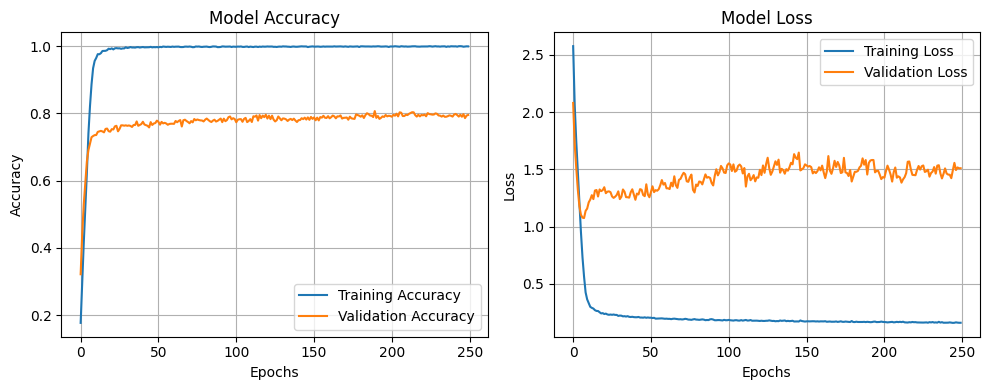

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


 1/74 [..............................] - ETA: 6:12


 4/74 [>.............................] - ETA: 1s  


 7/74 [=>............................] - ETA: 1s


10/74 [===>..........................] - ETA: 1s


13/74 [====>.........................] - ETA: 1s


16/74 [=====>........................] - ETA: 1s


19/74 [======>.......................] - ETA: 1s


22/74 [=======>......................] - ETA: 1s


25/74 [=========>....................] - ETA: 1s


28/74 [==========>...................] - ETA: 0s


31/74 [===========>..................] - ETA: 0s


34/74 [============>.................] - ETA: 0s


37/74 [==============>...............] - ETA: 0s


40/74 [===============>..............] - ETA: 0s


43/74 [================>.............] - ETA: 0s


46/74 [=================>............] - ETA: 0s


49/74 [==================>...........] - ETA: 0s


52/74 [====================>.........] - ETA: 0s


55/74 [=====================>........] - ETA: 0s


58/74 [======================>.......] - ETA: 0s


61/74 [=======================>......] - ETA: 0s


64/74 [========================>.....] - ETA: 0s


67/74 [==========================>...] - ETA: 0s


70/74 [===========================>..] - ETA: 0s


73/74 [============================>.] - ETA: 0s


74/74 [==============================] - 7s 21ms/step


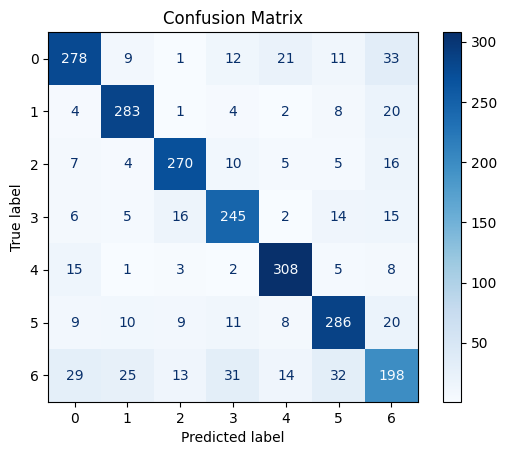

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = model.predict(x_test)
y_pred = np.argmax(preds[1] , axis = 1 )

y_true = np.argmax(y_test_class , axis = 1 )
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
del model

In [ ]:
from tensorflow.keras import backend as K

K.clear_session()

In [ ]:
import gc

gc.collect()

In [25]:
# Best accuracy model

from tensorflow.keras.models import load_model

model = load_model('best_model3_acc.keras')

In [30]:
loss = model.evaluate(x_test, {'bbox_output': y_test_bbox, 'class_output': y_test_class})
print("Test Loss:", loss[0])
print("Test Accuracy:", loss[4])


 1/74 [..............................] - ETA: 4s - loss: 1.8584 - bbox_output_loss: 0.1509 - class_output_loss: 1.6986 - bbox_output_mse: 0.1509 - class_output_accuracy: 0.7188 - class_output_class_output_precision: 0.7419 - class_output_class_output_recall: 0.7188


 4/74 [>.............................] - ETA: 1s - loss: 1.3275 - bbox_output_loss: 0.1519 - class_output_loss: 1.1666 - bbox_output_mse: 0.1519 - class_output_accuracy: 0.8281 - class_output_class_output_precision: 0.8413 - class_output_class_output_recall: 0.8281


 6/74 [=>............................] - ETA: 1s - loss: 1.4546 - bbox_output_loss: 0.1504 - class_output_loss: 1.2952 - bbox_output_mse: 0.1504 - class_output_accuracy: 0.7865 - class_output_class_output_precision: 0.8032 - class_output_class_output_recall: 0.7865


 8/74 [==>...........................] - ETA: 1s - loss: 1.4349 - bbox_output_loss: 0.1511 - class_output_loss: 1.2748 - bbox_output_mse: 0.1511 - class_output_accuracy: 0.7734 - class_output_class_output_precision: 0.7880 - class_output_class_output_recall: 0.7695


11/74 [===>..........................] - ETA: 1s - loss: 1.5279 - bbox_output_loss: 0.1507 - class_output_loss: 1.3682 - bbox_output_mse: 0.1507 - class_output_accuracy: 0.7585 - class_output_class_output_precision: 0.7710 - class_output_class_output_recall: 0.7557


13/74 [====>.........................] - ETA: 1s - loss: 1.4331 - bbox_output_loss: 0.1496 - class_output_loss: 1.2745 - bbox_output_mse: 0.1496 - class_output_accuracy: 0.7716 - class_output_class_output_precision: 0.7819 - class_output_class_output_recall: 0.7668


15/74 [=====>........................] - ETA: 1s - loss: 1.3880 - bbox_output_loss: 0.1496 - class_output_loss: 1.2294 - bbox_output_mse: 0.1496 - class_output_accuracy: 0.7833 - class_output_class_output_precision: 0.7941 - class_output_class_output_recall: 0.7792


17/74 [=====>........................] - ETA: 1s - loss: 1.3959 - bbox_output_loss: 0.1509 - class_output_loss: 1.2360 - bbox_output_mse: 0.1509 - class_output_accuracy: 0.7868 - class_output_class_output_precision: 0.7978 - class_output_class_output_recall: 0.7831


20/74 [=======>......................] - ETA: 1s - loss: 1.4243 - bbox_output_loss: 0.1506 - class_output_loss: 1.2647 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7922 - class_output_class_output_precision: 0.8013 - class_output_class_output_recall: 0.7875


22/74 [=======>......................] - ETA: 1s - loss: 1.3734 - bbox_output_loss: 0.1508 - class_output_loss: 1.2136 - bbox_output_mse: 0.1508 - class_output_accuracy: 0.7969 - class_output_class_output_precision: 0.8052 - class_output_class_output_recall: 0.7926


24/74 [========>.....................] - ETA: 1s - loss: 1.3551 - bbox_output_loss: 0.1506 - class_output_loss: 1.1955 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7995 - class_output_class_output_precision: 0.8071 - class_output_class_output_recall: 0.7956


26/74 [=========>....................] - ETA: 1s - loss: 1.3409 - bbox_output_loss: 0.1504 - class_output_loss: 1.1816 - bbox_output_mse: 0.1504 - class_output_accuracy: 0.8029 - class_output_class_output_precision: 0.8100 - class_output_class_output_recall: 0.7993


28/74 [==========>...................] - ETA: 1s - loss: 1.3810 - bbox_output_loss: 0.1507 - class_output_loss: 1.2213 - bbox_output_mse: 0.1507 - class_output_accuracy: 0.7969 - class_output_class_output_precision: 0.8034 - class_output_class_output_recall: 0.7935


31/74 [===========>..................] - ETA: 1s - loss: 1.4249 - bbox_output_loss: 0.1505 - class_output_loss: 1.2655 - bbox_output_mse: 0.1505 - class_output_accuracy: 0.7954 - class_output_class_output_precision: 0.8020 - class_output_class_output_recall: 0.7923


34/74 [============>.................] - ETA: 1s - loss: 1.4536 - bbox_output_loss: 0.1506 - class_output_loss: 1.2941 - bbox_output_mse: 0.1506 - class_output_accuracy: 0.7960 - class_output_class_output_precision: 0.8028 - class_output_class_output_recall: 0.7932


37/74 [==============>...............] - ETA: 0s - loss: 1.4465 - bbox_output_loss: 0.1513 - class_output_loss: 1.2862 - bbox_output_mse: 0.1513 - class_output_accuracy: 0.7956 - class_output_class_output_precision: 0.8024 - class_output_class_output_recall: 0.7922


40/74 [===============>..............] - ETA: 0s - loss: 1.4569 - bbox_output_loss: 0.1512 - class_output_loss: 1.2968 - bbox_output_mse: 0.1512 - class_output_accuracy: 0.7953 - class_output_class_output_precision: 0.8029 - class_output_class_output_recall: 0.7922


42/74 [================>.............] - ETA: 0s - loss: 1.4846 - bbox_output_loss: 0.1515 - class_output_loss: 1.3241 - bbox_output_mse: 0.1515 - class_output_accuracy: 0.7909 - class_output_class_output_precision: 0.7980 - class_output_class_output_recall: 0.7879


45/74 [=================>............] - ETA: 0s - loss: 1.4753 - bbox_output_loss: 0.1519 - class_output_loss: 1.3144 - bbox_output_mse: 0.1519 - class_output_accuracy: 0.7910 - class_output_class_output_precision: 0.7976 - class_output_class_output_recall: 0.7882


47/74 [==================>...........] - ETA: 0s - loss: 1.4701 - bbox_output_loss: 0.1522 - class_output_loss: 1.3090 - bbox_output_mse: 0.1522 - class_output_accuracy: 0.7926 - class_output_class_output_precision: 0.7988 - class_output_class_output_recall: 0.7892


50/74 [===================>..........] - ETA: 0s - loss: 1.4424 - bbox_output_loss: 0.1519 - class_output_loss: 1.2816 - bbox_output_mse: 0.1519 - class_output_accuracy: 0.7969 - class_output_class_output_precision: 0.8033 - class_output_class_output_recall: 0.7937


52/74 [====================>.........] - ETA: 0s - loss: 1.4372 - bbox_output_loss: 0.1519 - class_output_loss: 1.2763 - bbox_output_mse: 0.1519 - class_output_accuracy: 0.7969 - class_output_class_output_precision: 0.8030 - class_output_class_output_recall: 0.7939


55/74 [=====================>........] - ETA: 0s - loss: 1.4578 - bbox_output_loss: 0.1517 - class_output_loss: 1.2971 - bbox_output_mse: 0.1517 - class_output_accuracy: 0.7972 - class_output_class_output_precision: 0.8030 - class_output_class_output_recall: 0.7943


57/74 [======================>.......] - ETA: 0s - loss: 1.4658 - bbox_output_loss: 0.1518 - class_output_loss: 1.3050 - bbox_output_mse: 0.1518 - class_output_accuracy: 0.7933 - class_output_class_output_precision: 0.7989 - class_output_class_output_recall: 0.7906


60/74 [=======================>......] - ETA: 0s - loss: 1.4689 - bbox_output_loss: 0.1525 - class_output_loss: 1.3074 - bbox_output_mse: 0.1525 - class_output_accuracy: 0.7937 - class_output_class_output_precision: 0.7995 - class_output_class_output_recall: 0.7911


62/74 [========================>.....] - ETA: 0s - loss: 1.4648 - bbox_output_loss: 0.1526 - class_output_loss: 1.3033 - bbox_output_mse: 0.1526 - class_output_accuracy: 0.7954 - class_output_class_output_precision: 0.8009 - class_output_class_output_recall: 0.7928


65/74 [=========================>....] - ETA: 0s - loss: 1.4312 - bbox_output_loss: 0.1527 - class_output_loss: 1.2696 - bbox_output_mse: 0.1527 - class_output_accuracy: 0.7986 - class_output_class_output_precision: 0.8051 - class_output_class_output_recall: 0.7962


67/74 [==========================>...] - ETA: 0s - loss: 1.4363 - bbox_output_loss: 0.1528 - class_output_loss: 1.2745 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7976 - class_output_class_output_precision: 0.8046 - class_output_class_output_recall: 0.7952


70/74 [===========================>..] - ETA: 0s - loss: 1.4390 - bbox_output_loss: 0.1528 - class_output_loss: 1.2772 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7978 - class_output_class_output_precision: 0.8045 - class_output_class_output_recall: 0.7955


72/74 [============================>.] - ETA: 0s - loss: 1.4559 - bbox_output_loss: 0.1528 - class_output_loss: 1.2941 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7960 - class_output_class_output_precision: 0.8025 - class_output_class_output_recall: 0.7938


74/74 [==============================] - 2s 25ms/step - loss: 1.4453 - bbox_output_loss: 0.1528 - class_output_loss: 1.2835 - bbox_output_mse: 0.1528 - class_output_accuracy: 0.7969 - class_output_class_output_precision: 0.8034 - class_output_class_output_recall: 0.7948


Test Loss: 1.4452935457229614
Test Accuracy: 0.796928346157074


In [27]:
tf.saved_model.save(model, "saved_model_folder_acc/")

INFO:tensorflow:Assets written to: saved_model_folder_acc/assets


INFO:tensorflow:Assets written to: saved_model_folder_acc/assets


In [31]:
model.save('best_model3_acc_final.keras')


 1/74 [..............................] - ETA: 5:01


 4/74 [>.............................] - ETA: 1s  


 7/74 [=>............................] - ETA: 1s


10/74 [===>..........................] - ETA: 1s


13/74 [====>.........................] - ETA: 1s


16/74 [=====>........................] - ETA: 1s


19/74 [======>.......................] - ETA: 1s


22/74 [=======>......................] - ETA: 1s


25/74 [=========>....................] - ETA: 1s


28/74 [==========>...................] - ETA: 1s


31/74 [===========>..................] - ETA: 0s


34/74 [============>.................] - ETA: 0s


36/74 [=============>................] - ETA: 0s


39/74 [==============>...............] - ETA: 0s


42/74 [================>.............] - ETA: 0s


45/74 [=================>............] - ETA: 0s


48/74 [==================>...........] - ETA: 0s


51/74 [===================>..........] - ETA: 0s


54/74 [====================>.........] - ETA: 0s


57/74 [======================>.......] - ETA: 0s


60/74 [=======================>......] - ETA: 0s


63/74 [========================>.....] - ETA: 0s


66/74 [=========================>....] - ETA: 0s


69/74 [==========================>...] - ETA: 0s


72/74 [============================>.] - ETA: 0s


74/74 [==============================] - 6s 22ms/step


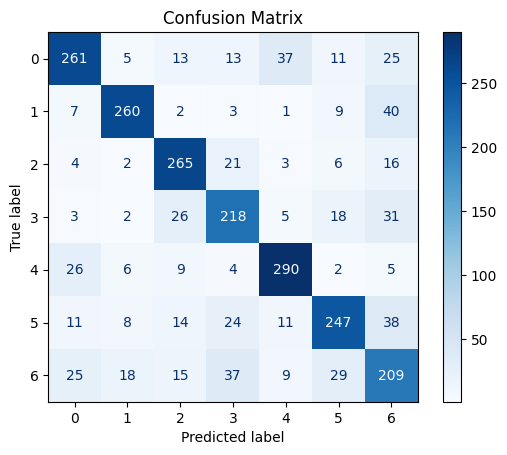

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = model.predict(x_test)
y_pred = np.argmax(preds[1] , axis = 1 )

y_true = np.argmax(y_test_class , axis = 1 )
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [29]:
import keras
keras.__version__

'3.3.2'